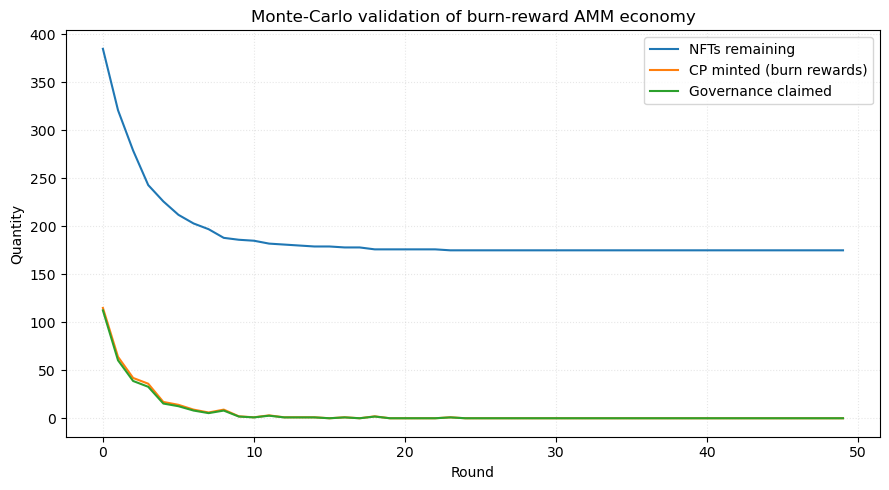

In [1]:
"""
Stochastic simulation validating the NFT burn–reward–AMM model
================================================================
각 주석에는
  • 논문 수식·섹션과의 매핑
  • 리뷰어 요구(R‑1~R‑4) 대응
  • 변수‧행동 선택 근거
를 명시했습니다.
"""

import random
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0) Global parameters  ─ 논문 Fig 2, 식 (2)–(4) 직접 대응
# ------------------------------------------------------------------
NUM_USERS = 500          # Reviewer‑2: down‑scaled community size
NUM_ROUNDS = 50          # ≈ 2개월 P2E 시즌

INITIAL_NFTS_PER_USER = 1
INITIAL_CP_SUPPLY      = 10_000   # cp in paper
INITIAL_GOV_SUPPLY     = 5_000    # g  in paper
Q_LIQUIDITY_PORTION    = 0.5      # q  (식 (2))

P_UPGRADE_SUCCESS      = 0.30     # p₀ (식 (5)–(7))
P_BURN_ON_FAIL         = 0.40     # Reviewer‑2: failure 후 즉시 burn 확률
ALPHA                  = 1.0      # α = pᵢ·I, 여기선 I=1

# ------------------------------------------------------------------
# 1) AMM (Constant‑Product Formula)  ─ 식 (2)–(4)
# ------------------------------------------------------------------
def amm_swap(cp_pool: float, gov_pool: float, cp_in: float):
    """Uniswap‑style CPF.  Reviewer‑1: 실증."""
    if cp_in <= 0:
        return 0.0, cp_pool, gov_pool
    k = cp_pool * gov_pool
    cp_new  = cp_pool + cp_in         # x' = x + Δx
    gov_new = k / cp_new              # y' = k / x'
    gov_out = max(gov_pool - gov_new, 0.0)
    return gov_out, cp_new, gov_new

# ------------------------------------------------------------------
# 2) User initialisation  ─ 표 2(U(N), U(S), U(F)) 매핑
# ------------------------------------------------------------------
users = [
    {"nft": INITIAL_NFTS_PER_USER,
     "type": random.choice(["upgrader", "burner", "hodler"])}
    for _ in range(NUM_USERS)
]

# ------------------------------------------------------------------
# 3) Initial AMM pools  ─ cp_pool = q·cp, gov_pool = g
# ------------------------------------------------------------------
cp_pool  = INITIAL_CP_SUPPLY * Q_LIQUIDITY_PORTION
gov_pool = INITIAL_GOV_SUPPLY
history  = defaultdict(list)

# ------------------------------------------------------------------
# 4) Main Monte‑Carlo loop  ─ Reviewer‑1 시뮬 요구 충족
# ------------------------------------------------------------------
for rnd in range(NUM_ROUNDS):
    cp_minted = 0.0
    gov_claim = 0.0

    for u in users:
        if u["nft"] == 0:
            continue

        # ─── 전략 1 : upgrader (U(S)/U(F)) ───────────────────────
        if u["type"] == "upgrader":
            if random.random() < P_UPGRADE_SUCCESS:     # 성공
                pass  # 가치 ri 증가(간략화)
            else:                                       # 실패
                if random.random() < P_BURN_ON_FAIL:    # burn
                    cp_minted += ALPHA
                    u["nft"] = 0

        # ─── 전략 2 : burner (즉시 소각) ─────────────────────────
        elif u["type"] == "burner":
            if random.random() < P_BURN_ON_FAIL:
                cp_minted += ALPHA
                u["nft"] = 0

        # ─── 전략 3 : hodler (U(N)) ─────────────────────────────
        else:
            pass  # 아무 행동 없음

    # AMM 교환  ─ 식 (2)–(4) 실행
    gov_out, cp_pool, gov_pool = amm_swap(cp_pool, gov_pool, cp_minted)
    gov_claim += gov_out

    # ─── 데이터 기록 (그래프·테이블용) ───────────────────────────
    history["round"].append(rnd)
    history["cp_minted"].append(cp_minted)
    history["gov_claim"].append(gov_claim)
    history["nfts_left"].append(sum(u["nft"] for u in users))
    history["cp_pool"].append(cp_pool)
    history["gov_pool"].append(gov_pool)

# ------------------------------------------------------------------
# 5) Plot results  ─ Reviewer‑4 직관 요청 대응
# ------------------------------------------------------------------
df = pd.DataFrame(history)

plt.figure(figsize=(9, 5))
plt.plot(df["round"], df["nfts_left"],  label="NFTs remaining")
plt.plot(df["round"], df["cp_minted"],  label="CP minted (burn rewards)")
plt.plot(df["round"], df["gov_claim"],  label="Governance claimed")
plt.title("Monte‑Carlo validation of burn‑reward AMM economy")
plt.xlabel("Round");  plt.ylabel("Quantity")
plt.grid(alpha=0.3, linestyle=":")
plt.legend();  plt.tight_layout();  plt.show()

# df.to_csv("simulation_output.csv", index=False)  # Supplementary 자료로 저장시


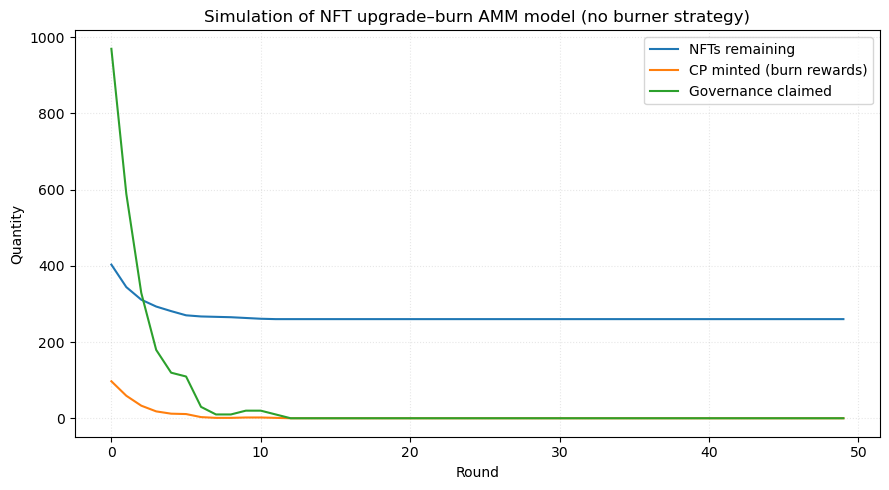

In [ ]:
"""
Stochastic simulation validating the NFT burn–reward–AMM model (corrected version)
===================================================================================
- 논문 수식 (2)–(7) 기반 시뮬레이션
- 사용자 전략: upgrader / hodler
- burner 전략 제거 (논문에 없음)
"""

import random
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0) Global parameters — 논문 수식 직접 대응
# ------------------------------------------------------------------
NUM_USERS = 500
NUM_ROUNDS = 50

INITIAL_NFTS_PER_USER = 1
INITIAL_CP_SUPPLY = 100_000
INITIAL_GOV_SUPPLY = 1_000_000  # 거버넌스 풀을 100만 이상
Q_LIQUIDITY_PORTION = 0.5      # q from Eq. (2)

P_UPGRADE_ATTEMPT = 0.6        # 시도 여부 확률 (논문 수식 외 선택)
P_UPGRADE_SUCCESS = 0.3        # 업그레이드 성공 확률 pᵢ (Eq. 5–6)
ALPHA = 1.0                    # 보상량 α = pᵢ·I, 여기선 I = 1

# ------------------------------------------------------------------
# 1) AMM (Constant Product Formula) — Eq. (2)–(4)
# ------------------------------------------------------------------
def amm_swap(cp_pool: float, gov_pool: float, cp_in: float):
    if cp_in <= 0:
        return 0.0, cp_pool, gov_pool
    k = cp_pool * gov_pool
    cp_new = cp_pool + cp_in
    gov_new = k / cp_new
    gov_out = max(gov_pool - gov_new, 0.0)
    return gov_out, cp_new, gov_new

# ------------------------------------------------------------------
# 2) User initialization — 업그레이드 시도 or HODL
# ------------------------------------------------------------------
users = [
    {"nft": INITIAL_NFTS_PER_USER,
     "type": random.choice(["upgrader", "hodler"])}
    for _ in range(NUM_USERS)
]

# ------------------------------------------------------------------
# 3) Initial AMM pools
# ------------------------------------------------------------------
cp_pool = INITIAL_CP_SUPPLY * Q_LIQUIDITY_PORTION
gov_pool = INITIAL_GOV_SUPPLY
history = defaultdict(list)

# ------------------------------------------------------------------
# 4) Monte Carlo simulation — 핵심 시뮬레이션
# ------------------------------------------------------------------
for rnd in range(NUM_ROUNDS):
    cp_minted = 0.0
    gov_claim = 0.0

    for u in users:
        if u["nft"] == 0:
            continue

        if u["type"] == "upgrader":
            if random.random() < P_UPGRADE_ATTEMPT:
                if random.random() < P_UPGRADE_SUCCESS:
                    pass  # 성공 → NFT 보존 (가치 r_i 증가 생략)
                else:
                    # 실패 → NFT 소각 + 보상 α 지급
                    cp_minted += ALPHA
                    u["nft"] = 0
        else:
            pass  # hodler → 아무 행동 없음

    gov_out, cp_pool, gov_pool = amm_swap(cp_pool, gov_pool, cp_minted)
    gov_claim += gov_out

    history["round"].append(rnd)
    history["cp_minted"].append(cp_minted)
    history["gov_claim"].append(gov_claim)
    history["nfts_left"].append(sum(u["nft"] for u in users))
    history["cp_pool"].append(cp_pool)
    history["gov_pool"].append(gov_pool)

# ------------------------------------------------------------------
# 5) Plot results
# ------------------------------------------------------------------
df = pd.DataFrame(history)

plt.figure(figsize=(9, 5))
plt.plot(df["round"], df["nfts_left"],  label="NFTs remaining")
plt.plot(df["round"], df["cp_minted"],  label="CP minted (burn rewards)")
plt.plot(df["round"], df["gov_claim"],  label="Governance claimed")
plt.title("Simulation of NFT upgrade–burn AMM model (no burner strategy)")
plt.xlabel("Round");  plt.ylabel("Quantity")
plt.grid(alpha=0.3, linestyle=":")
plt.legend();  plt.tight_layout();  plt.show()

# df.to_csv("simulation_output.csv", index=False)


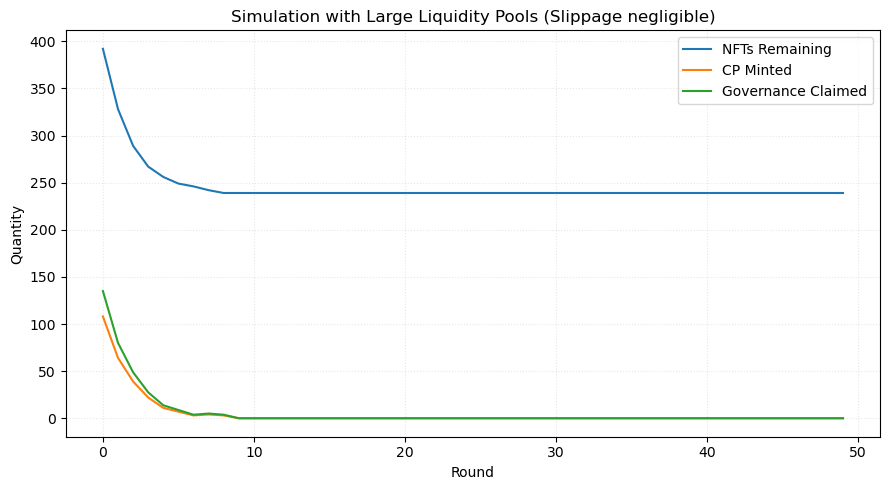

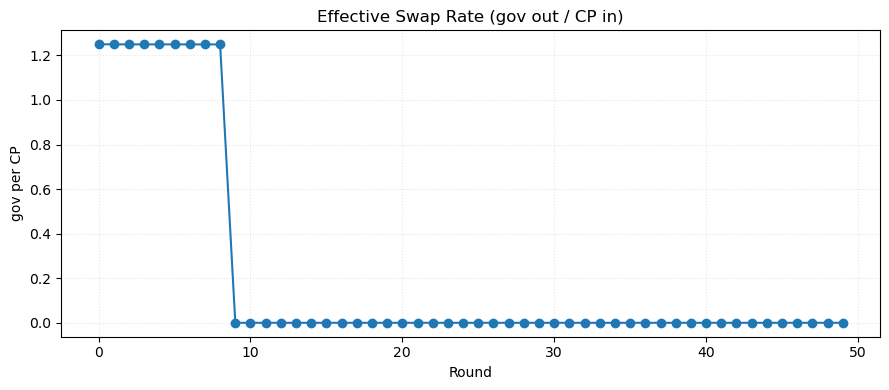

round  cp_minted   gov_claim  nfts_left  swap_rate   cp_pool       gov_pool
0      0      108.0  134.981777        392   1.249831  800108.0  999865.018223
1      1       64.0   79.972007        328   1.249563  800172.0  999785.046215
2      2       39.0   48.726669        289   1.249402  800211.0  999736.319546
3      3       22.0   27.484744        267   1.249307  800233.0  999708.834802
4      4       11.0   13.741805        256   1.249255  800244.0  999695.092997

In [5]:
import random
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Seed for reproducibility
random.seed(42)

# -----------------------------
# PARAMETERS (Large Liquidity)
# -----------------------------
NUM_USERS = 500
NUM_ROUNDS = 50

INITIAL_NFTS_PER_USER = 1
INITIAL_CP_SUPPLY = 1_000_000     # Large CP pool
INITIAL_GOV_SUPPLY = 1_000_000    # Large Gov pool
Q_LIQUIDITY_PORTION = 0.8         # 80% of CP in AMM

P_UPGRADE_ATTEMPT = 0.6
P_UPGRADE_SUCCESS = 0.3
ALPHA = 1.0

# -----------------------------
# AMM swap (CPF)
# -----------------------------
def amm_swap(cp_pool, gov_pool, cp_in):
    if cp_in <= 0:
        return 0.0, cp_pool, gov_pool
    k = cp_pool * gov_pool
    cp_new = cp_pool + cp_in
    gov_new = k / cp_new
    gov_out = max(gov_pool - gov_new, 0.0)
    return gov_out, cp_new, gov_new

# -----------------------------
# Initialize users
# -----------------------------
users = [{"nft": INITIAL_NFTS_PER_USER,
          "type": random.choice(["upgrader", "hodler"])}
         for _ in range(NUM_USERS)]

cp_pool = INITIAL_CP_SUPPLY * Q_LIQUIDITY_PORTION
gov_pool = INITIAL_GOV_SUPPLY
history = defaultdict(list)

# -----------------------------
# Simulation loop
# -----------------------------
for rnd in range(NUM_ROUNDS):
    cp_minted = 0.0
    gov_claim = 0.0

    for u in users:
        if u["nft"] == 0:
            continue
        if u["type"] == "upgrader":
            if random.random() < P_UPGRADE_ATTEMPT:
                if random.random() >= P_UPGRADE_SUCCESS:  # fail -> burn
                    cp_minted += ALPHA
                    u["nft"] = 0
        # hodler does nothing

    gov_out, cp_pool, gov_pool = amm_swap(cp_pool, gov_pool, cp_minted)
    gov_claim += gov_out

    history["round"].append(rnd)
    history["cp_minted"].append(cp_minted)
    history["gov_claim"].append(gov_claim)
    history["nfts_left"].append(sum(u["nft"] for u in users))
    history["swap_rate"].append(gov_out / cp_minted if cp_minted else 0)
    history["cp_pool"].append(cp_pool)
    history["gov_pool"].append(gov_pool)

# -----------------------------
# Plot results
# -----------------------------
df = pd.DataFrame(history)

plt.figure(figsize=(9, 5))
plt.plot(df["round"], df["nfts_left"], label="NFTs Remaining")
plt.plot(df["round"], df["cp_minted"], label="CP Minted")
plt.plot(df["round"], df["gov_claim"], label="Governance Claimed")
plt.title("Simulation with Large Liquidity Pools (Slippage negligible)")
plt.xlabel("Round")
plt.ylabel("Quantity")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

# Plot swap rate to show slippage effect
plt.figure(figsize=(9, 4))
plt.plot(df["round"], df["swap_rate"], marker='o')
plt.title("Effective Swap Rate (gov out / CP in)")
plt.xlabel("Round")
plt.ylabel("gov per CP")
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

# Show first few rows of dataframe for context
df.head()


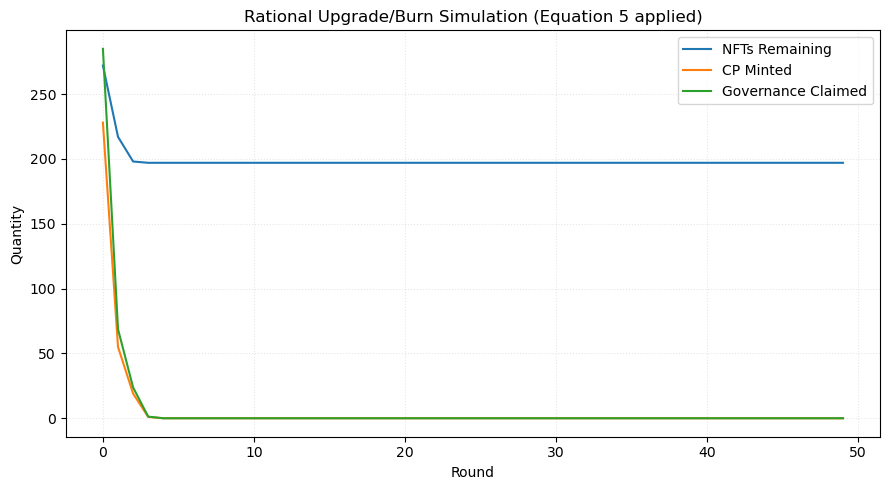

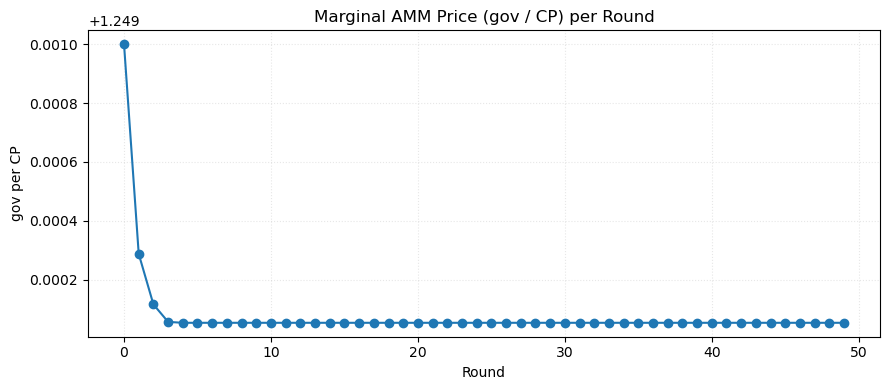

ModuleNotFoundError: No module named 'ace_tools'

In [7]:
import random
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Simulation purpose
# -----------------------------
# Validate Equation (5) rationality:
# Users attempt upgrade only if expected utility > current value.
# Expected utility = p_success * r + (1 - p_success) * alpha * (gov_pool / cp_pool)
# If attempt and fail they burn and receive alpha CP, which is swapped at AMM rate.

random.seed(1)

# -------------------------
# Parameters
# -------------------------
NUM_USERS = 500
NUM_ROUNDS = 50

INITIAL_NFTS_PER_USER = 1
INITIAL_CP_SUPPLY = 1_000_000       # Large pools
INITIAL_GOV_SUPPLY = 1_000_000
Q_LIQUIDITY_PORTION = 0.8           # portion of CP in AMM

P_UPGRADE_SUCCESS = 0.3             # p_i
ALPHA = 1.0                         # alpha = p_i * I, with I=1
R_UPGRADE = 1.5                     # r_i, upgrade boosts value by 50%

# -------------------------
# AMM helper (marginal price + swap many)
# -------------------------
def marginal_price(gov_pool, cp_pool):
    """Governance tokens per 1 CP for infinitesimal trade"""
    return gov_pool / cp_pool

def amm_swap(cp_pool, gov_pool, cp_in):
    if cp_in <= 0:
        return 0.0, cp_pool, gov_pool
    k = cp_pool * gov_pool
    cp_new = cp_pool + cp_in
    gov_new = k / cp_new
    gov_out = gov_pool - gov_new
    return gov_out, cp_new, gov_new

# -------------------------
# Users
# -------------------------
users = []
for _ in range(NUM_USERS):
    # 60% upgrader, 40% hodler
    utype = "upgrader" if random.random() < 0.6 else "hodler"
    users.append({"nft": INITIAL_NFTS_PER_USER, "type": utype})

cp_pool = INITIAL_CP_SUPPLY * Q_LIQUIDITY_PORTION
gov_pool = INITIAL_GOV_SUPPLY
history = defaultdict(list)

# -------------------------
# Simulation loop
# -------------------------
for rnd in range(NUM_ROUNDS):
    cp_minted = 0.0
    gov_claimed = 0.0

    price = marginal_price(gov_pool, cp_pool)  # instantaneous rate

    for u in users:
        if u["nft"] == 0:
            continue

        if u["type"] == "upgrader":
            # expected value of attempting upgrade
            expected_val = (
                P_UPGRADE_SUCCESS * R_UPGRADE +
                (1 - P_UPGRADE_SUCCESS) * ALPHA * price
            )
            if expected_val > 1.0:  # current value normalized to 1
                # attempt
                if random.random() < P_UPGRADE_SUCCESS:
                    # success: keep NFT worth r times (not tracked)
                    pass
                else:
                    # failure -> burn & receive CP
                    cp_minted += ALPHA
                    u["nft"] = 0
            else:
                # decide to hold if not worth it
                pass
        # hodlers do nothing

    # Swap all CP minted to governance tokens
    gov_out, cp_pool, gov_pool = amm_swap(cp_pool, gov_pool, cp_minted)
    gov_claimed += gov_out

    # record
    history["round"].append(rnd)
    history["nfts_left"].append(sum(u["nft"] for u in users))
    history["cp_minted"].append(cp_minted)
    history["gov_claimed"].append(gov_claimed)
    history["swap_rate"].append(price)
    history["cp_pool"].append(cp_pool)
    history["gov_pool"].append(gov_pool)

# -------------------------
# DataFrame and plots
# -------------------------
df = pd.DataFrame(history)

plt.figure(figsize=(9,5))
plt.plot(df["round"], df["nfts_left"], label="NFTs Remaining")
plt.plot(df["round"], df["cp_minted"], label="CP Minted")
plt.plot(df["round"], df["gov_claimed"], label="Governance Claimed")
plt.title("Rational Upgrade/Burn Simulation (Equation 5 applied)")
plt.xlabel("Round")
plt.ylabel("Quantity")
plt.grid(alpha=0.3, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.plot(df["round"], df["swap_rate"], marker="o")
plt.title("Marginal AMM Price (gov / CP) per Round")
plt.xlabel("Round")
plt.ylabel("gov per CP")
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="Rational Simulation Results", dataframe=df.head())


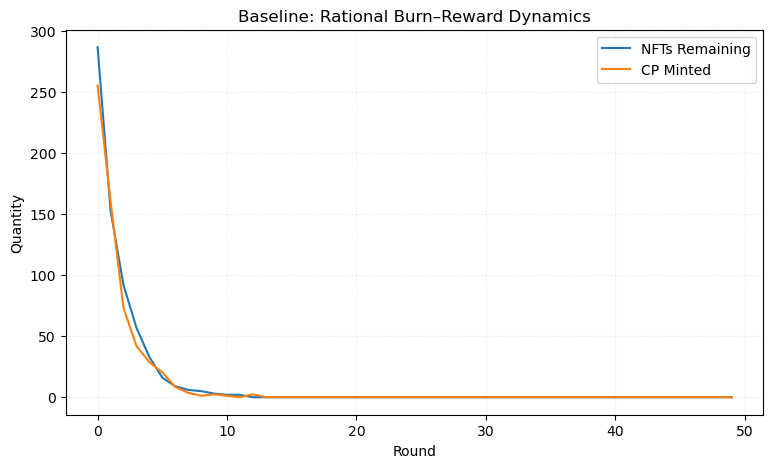

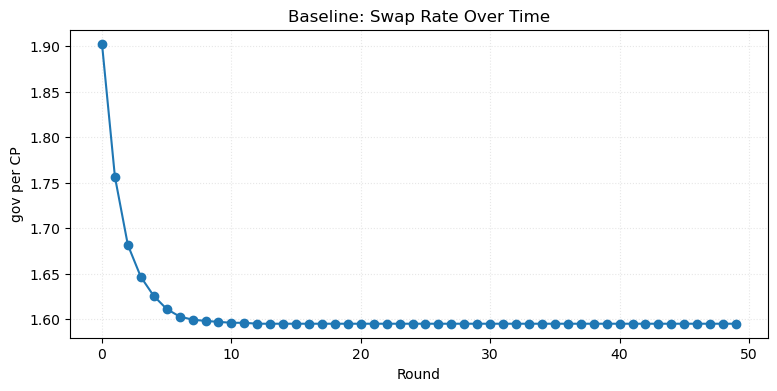

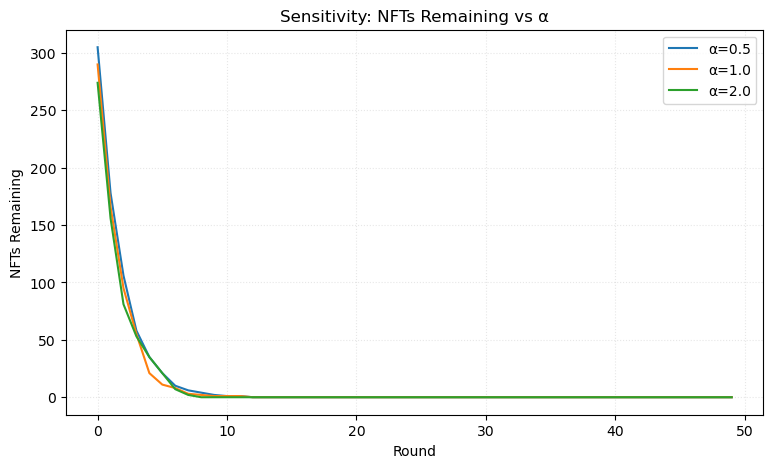

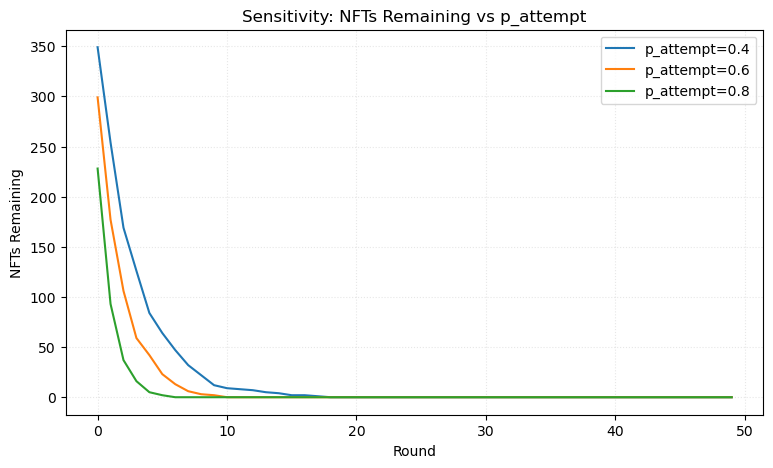

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ──────────────────────────────────────────────────────────
# 0) 기본 설정
# ──────────────────────────────────────────────────────────
NUM_USERS   = 500
NUM_ROUNDS  = 50

INITIAL_NFTS = 1
CP_INIT      = 10_000
GOV_INIT     = 10_000
Q            = 0.5       # AMM 유동성 비율

P_SUCCESS    = 0.3       # 업그레이드 성공 확률 p_i
R            = 1.2       # 업그레이드 시 가치 계수 r_i
CP_I         = 1.0       # 정규화된 현재 NFT 가치

# ──────────────────────────────────────────────────────────
# 1) 시뮬레이션 함수 (합리적 의사결정 포함)
# ──────────────────────────────────────────────────────────
def simulate(alpha, p_attempt):
    # 에이전트 초기화
    users = [INITIAL_NFTS]*NUM_USERS  # 1 or 0
    cp_pool = CP_INIT * Q
    gov_pool = GOV_INIT
    swap_rate = gov_pool / cp_pool    # 초기 swap rate
    
    # 기록용
    rounds, nfts_remaining, cp_minted, swap_rates = [], [], [], []
    
    for rnd in range(NUM_ROUNDS):
        minted = 0.0
        gov_out = 0.0
        
        # ── 에이전트 행동 결정 (H1′)
        for i in range(NUM_USERS):
            if users[i] == 0:
                continue
            if random.random() < p_attempt:
                if random.random() < P_SUCCESS:
                    # 성공: NFT 유지(가치만 상승)
                    pass
                else:
                    # 실패 시 기대가치 계산 (Eq.5)
                    E_up = (P_SUCCESS * (R*CP_I) +
                            (1 - P_SUCCESS) * (alpha * R * CP_I * swap_rate))
                    if E_up > CP_I:
                        # 소각 → CP 보상
                        users[i] = 0
                        minted += alpha * R * CP_I
        
        # ── AMM swap (Eq.2-4)
        if minted > 0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new
        
        # ── swap rate 업데이트
        swap_rate = gov_out / minted if minted > 0 else swap_rate
        
        # ── 기록
        rounds.append(rnd)
        nfts_remaining.append(sum(users))
        cp_minted.append(minted)
        swap_rates.append(swap_rate)
    
    return {
        "rounds": rounds,
        "nfts": nfts_remaining,
        "cp": cp_minted,
        "swap": swap_rates
    }

# ──────────────────────────────────────────────────────────
# 2) 기본 시나리오 실행 & 시각화
# ──────────────────────────────────────────────────────────
data = simulate(alpha=1.0, p_attempt=0.6)

plt.figure(figsize=(9,5))
plt.plot(data["rounds"], data["nfts"], label="NFTs Remaining")
plt.plot(data["rounds"], data["cp"],  label="CP Minted")
plt.title("Baseline: Rational Burn–Reward Dynamics")
plt.xlabel("Round"); plt.ylabel("Quantity")
plt.grid(alpha=0.3, linestyle=":"); plt.legend(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(data["rounds"], data["swap"], marker="o")
plt.title("Baseline: Swap Rate Over Time")
plt.xlabel("Round"); plt.ylabel("gov per CP")
plt.grid(alpha=0.3, linestyle=":"); plt.show()

# ──────────────────────────────────────────────────────────
# 3) 민감도 분석
#    (a) α 변화에 따른 NFT 잔량
# ──────────────────────────────────────────────────────────
plt.figure(figsize=(9,5))
for a in [0.5, 1.0, 2.0]:
    res = simulate(alpha=a, p_attempt=0.6)
    plt.plot(res["rounds"], res["nfts"], label=f"α={a}")
plt.title("Sensitivity: NFTs Remaining vs α")
plt.xlabel("Round"); plt.ylabel("NFTs Remaining")
plt.grid(alpha=0.3, linestyle=":"); plt.legend(); plt.show()

# ──────────────────────────────────────────────────────────
#    (b) p_attempt 변화에 따른 NFT 잔량
# ──────────────────────────────────────────────────────────
plt.figure(figsize=(9,5))
for p in [0.4, 0.6, 0.8]:
    res = simulate(alpha=1.0, p_attempt=p)
    plt.plot(res["rounds"], res["nfts"], label=f"p_attempt={p}")
plt.title("Sensitivity: NFTs Remaining vs p_attempt")
plt.xlabel("Round"); plt.ylabel("NFTs Remaining")
plt.grid(alpha=0.3, linestyle=":"); plt.legend(); plt.show()


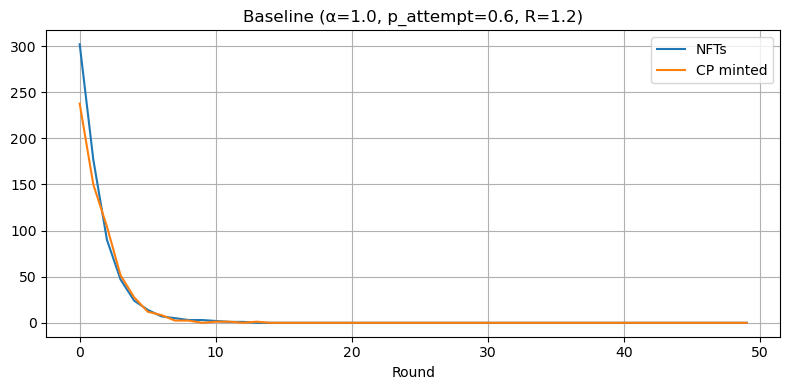

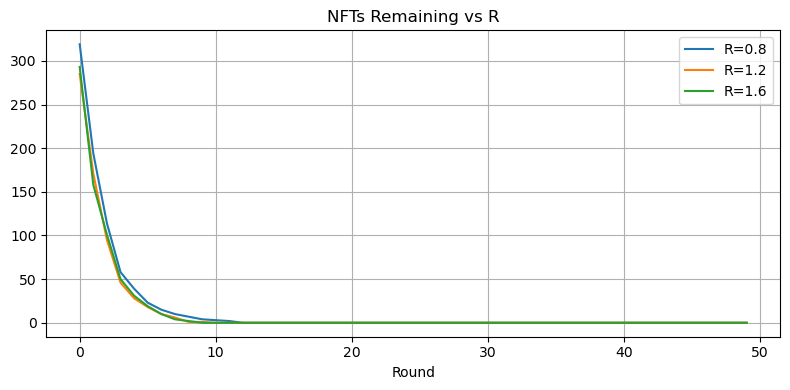

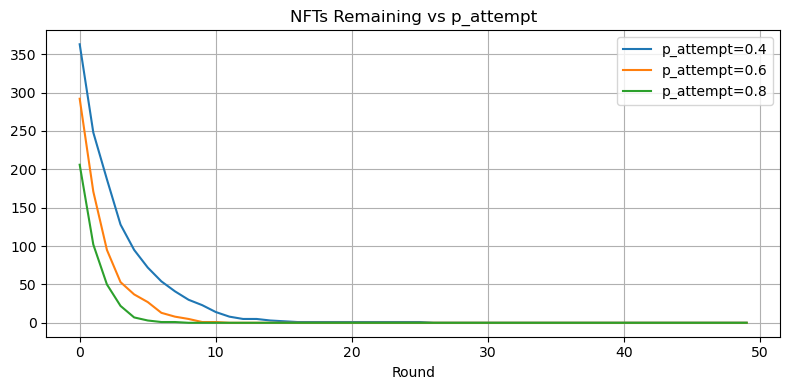

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ──────────────────────────────────────────────────────────
# 0) 파라미터 설정
# ──────────────────────────────────────────────────────────
NUM_USERS   = 500
NUM_ROUNDS  = 50

INITIAL_NFTS = 1
CP_INIT      = 10_000   # 총 CP 토큰
GOV_INIT     = 10_000   # 총 거버넌스 토큰
Q            = 0.5      # AMM 유동성 비율

P_SUCCESS    = 0.3      # 업그레이드 성공 확률 p_i
CP_I         = 1.0      # 현재 NFT의 가치 (정규화)

# ──────────────────────────────────────────────────────────
# 1) 시뮬레이션 함수 정의
# ──────────────────────────────────────────────────────────
def simulate(alpha, p_attempt, R):
    # 에이전트: 각자 1개의 NFT를 보유 (0 또는 1)
    users = [INITIAL_NFTS] * NUM_USERS
    cp_pool = CP_INIT * Q
    gov_pool = GOV_INIT
    swap_rate = gov_pool / cp_pool  # 초기 슬리피지 없는 상태

    history = defaultdict(list)

    for rnd in range(NUM_ROUNDS):
        minted = 0.0
        gov_out = 0.0

        # 1) 각 에이전트의 합리적 의사결정 (Eq.5 기반)
        for i in range(NUM_USERS):
            if users[i] == 0:
                continue
            if random.random() < p_attempt:
                if random.random() < P_SUCCESS:
                    # 성공: NFT 보존 (가치는 R×CP_I 로 상승하나 tracking 생략)
                    pass
                else:
                    # 실패: 기대가치 계산
                    E_up = (P_SUCCESS * (R * CP_I) +
                            (1 - P_SUCCESS) * (alpha * R * CP_I * swap_rate))
                    if E_up > CP_I:
                        # 합리적으로 burn
                        users[i] = 0
                        minted += alpha * R * CP_I

        # 2) AMM swap (x·y=k)
        if minted > 0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new

        # 3) swap rate 업데이트
        swap_rate = (gov_out / minted) if minted > 0 else swap_rate

        # 4) 기록
        history["round"].append(rnd)
        history["nfts_remaining"].append(sum(users))
        history["cp_minted"].append(minted)
        history["swap_rate"].append(swap_rate)

    return history

# ──────────────────────────────────────────────────────────
# 2) 결과 그려보기
# ──────────────────────────────────────────────────────────

# (a) R = 1.2 (baseline)
hist_base = simulate(alpha=1.0, p_attempt=0.6, R=1.2)
plt.figure(figsize=(8,4))
plt.plot(hist_base["round"], hist_base["nfts_remaining"], label="NFTs")
plt.plot(hist_base["round"], hist_base["cp_minted"],       label="CP minted")
plt.title("Baseline (α=1.0, p_attempt=0.6, R=1.2)")
plt.xlabel("Round"); plt.legend(); plt.grid(True); plt.tight_layout()

# (b) R 민감도 (Eq.7 임계치 전후)
Rs = [0.8, 1.2, 1.6]
plt.figure(figsize=(8,4))
for r in Rs:
    h = simulate(alpha=1.0, p_attempt=0.6, R=r)
    plt.plot(h["round"], h["nfts_remaining"], label=f"R={r}")
plt.title("NFTs Remaining vs R")
plt.xlabel("Round"); plt.legend(); plt.grid(True); plt.tight_layout()

# (c) p_attempt 민감도
ps = [0.4, 0.6, 0.8]
plt.figure(figsize=(8,4))
for p in ps:
    h = simulate(alpha=1.0, p_attempt=p, R=1.2)
    plt.plot(h["round"], h["nfts_remaining"], label=f"p_attempt={p}")
plt.title("NFTs Remaining vs p_attempt")
plt.xlabel("Round"); plt.legend(); plt.grid(True); plt.tight_layout()

plt.show()


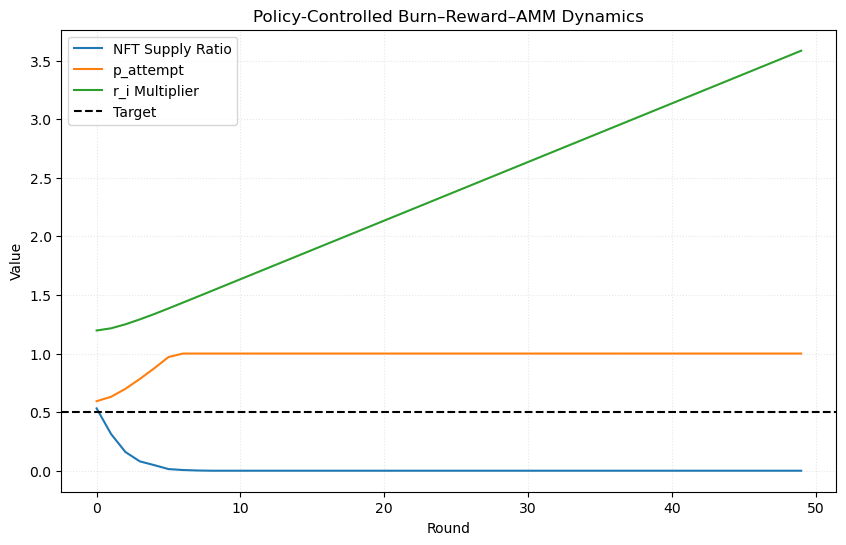

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────
# 0) 파라미터
# ──────────────────────────────────────────────────────────
NUM_USERS = 500
NUM_ROUNDS = 50

CP_INIT  = 10_000
GOV_INIT = 10_000
Q        = 0.5

P_SUCCESS = 0.3    # Eq.(5)의 p_i
CP_I      = 1.0

# 정책·충격 파라미터
INITIAL_P_ATTEMPT    = 0.6
INITIAL_R            = 1.2
SIGMA_P              = 0.05   # 브라우니안 충격 크기
KAPPA_P              = 0.2    # p_attempt 조정 계수
KAPPA_R              = 0.1    # r_i 조정 계수
TARGET_SUPPLY_RATIO  = 0.5    # 목표 NFT 보유 비율

def simulate_control(alpha=1.0):
    # 초기 상태
    users = [1]*NUM_USERS
    cp_pool = CP_INIT * Q
    gov_pool = GOV_INIT
    swap_rate = gov_pool / cp_pool

    p_attempt = INITIAL_P_ATTEMPT
    r = INITIAL_R

    # 기록
    rounds = []
    supply_ratio = []
    p_hist = []
    r_hist = []

    for rnd in range(NUM_ROUNDS):
        # 1) 브라우니안 충격 반영
        p_hat = np.clip(p_attempt + np.random.normal(0, SIGMA_P), 0, 1)

        # 2) Eq.(5) 기반 의사결정 → 소각·CP 발행
        minted = 0.0
        for i in range(NUM_USERS):
            if users[i] == 0:
                continue
            if random.random() < p_hat:
                if random.random() < P_SUCCESS:
                    pass
                else:
                    E_up = (P_SUCCESS * (r*CP_I) +
                            (1-P_SUCCESS) * (alpha*r*CP_I*swap_rate))
                    if E_up > CP_I:
                        users[i] = 0
                        minted += alpha * r * CP_I

        # 3) AMM swap
        if minted > 0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new
            swap_rate = gov_out / minted

        # 4) 공급 비율 및 정책 업데이트
        S = sum(users)/NUM_USERS
        error = S - TARGET_SUPPLY_RATIO
        p_attempt = np.clip(p_attempt - KAPPA_P*error, 0, 1)
        r         = max(r - KAPPA_R*error, 0.01)

        # 5) 기록
        rounds.append(rnd)
        supply_ratio.append(S)
        p_hist.append(p_attempt)
        r_hist.append(r)

    return rounds, supply_ratio, p_hist, r_hist

# ──────────────────────────────────────────────────────────
# 6) 실행 및 플롯
# ──────────────────────────────────────────────────────────
rounds, supply_ratio, p_hist, r_hist = simulate_control(alpha=1.0)

plt.figure(figsize=(10,6))
plt.plot(rounds, supply_ratio, label="NFT Supply Ratio")
plt.plot(rounds, p_hist,      label="p_attempt")
plt.plot(rounds, r_hist,      label="r_i Multiplier")
plt.axhline(TARGET_SUPPLY_RATIO, color='k', linestyle='--', label="Target")
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Policy-Controlled Burn–Reward–AMM Dynamics")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")
plt.show()


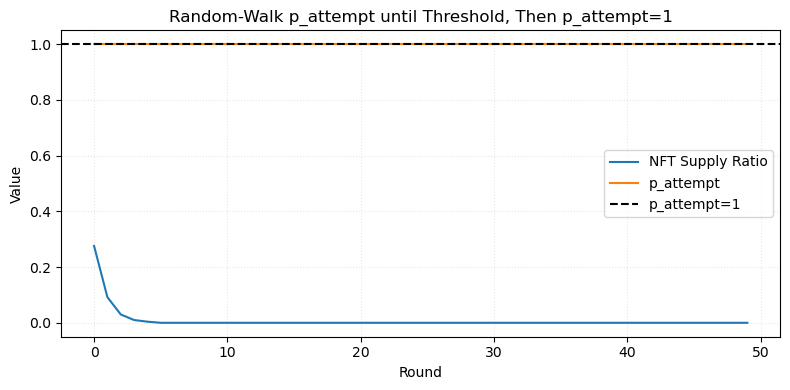

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ─── 파라미터 ────────────────────────────────────────
NUM_USERS   = 500
NUM_ROUNDS  = 50

CP_INIT     = 10_000
GOV_INIT    = 10_000
Q           = 0.5

P_SUCCESS   = 0.3    # p_i
CP_I        = 1.0    # normalized NFT value
INITIAL_R   = 1.2    # r_i

SIGMA_P     = 0.1    # 브라우니안 충격 표준편차
INITIAL_P   = 0.5    # 초기 p_attempt

def simulate_rw_threshold(alpha=1.0):
    # 초기화
    users      = [1]*NUM_USERS
    cp_pool    = CP_INIT * Q
    gov_pool   = GOV_INIT
    swap_rate  = gov_pool / cp_pool
    
    p_attempt  = INITIAL_P
    r          = INITIAL_R

    rounds, supply, p_hist = [], [], []

    for t in range(NUM_ROUNDS):
        # 1) E_upgrade 계산
        E_up = (P_SUCCESS * (r*CP_I)
                + (1 - P_SUCCESS) * (alpha * r * CP_I * swap_rate))

        # 2) p_attempt 업데이트
        if E_up > CP_I:
            p_attempt = 1.0
        else:
            p_attempt = np.clip(p_attempt + np.random.normal(0, SIGMA_P), 0, 1)

        # 3) 에이전트 행동
        minted = 0.0
        for i in range(NUM_USERS):
            if users[i] == 0: continue
            if random.random() < p_attempt:
                if random.random() >= P_SUCCESS:
                    # 실패 시 rational burn
                    users[i] = 0
                    minted += alpha * r * CP_I

        # 4) AMM swap
        if minted > 0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new
            swap_rate = gov_out / minted

        # 5) 기록
        rounds.append(t)
        supply.append(sum(users)/NUM_USERS)
        p_hist.append(p_attempt)

    return rounds, supply, p_hist

# ─── 실행 & 플롯 ───────────────────────────────────
rounds, supply, p_hist = simulate_rw_threshold(alpha=1.0)

plt.figure(figsize=(8,4))
plt.plot(rounds, supply,  label="NFT Supply Ratio")
plt.plot(rounds, p_hist,  label="p_attempt")
plt.axhline(1.0, color='k', linestyle='--', label="p_attempt=1")
plt.xlabel("Round"); plt.ylabel("Value")
plt.title("Random-Walk p_attempt until Threshold, Then p_attempt=1")
plt.legend(); plt.grid(alpha=0.3, linestyle=":"); plt.tight_layout()
plt.show()


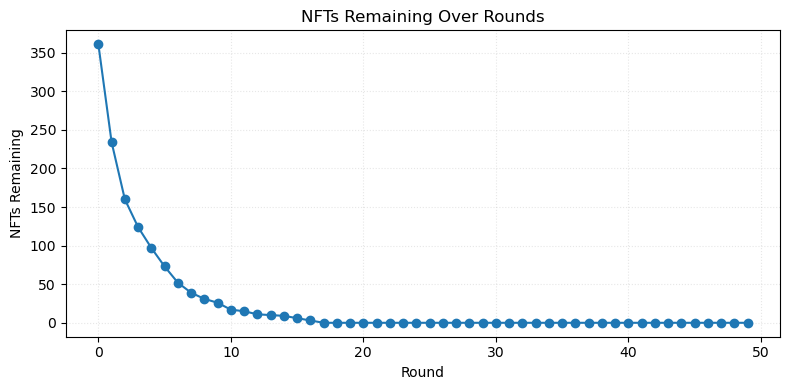

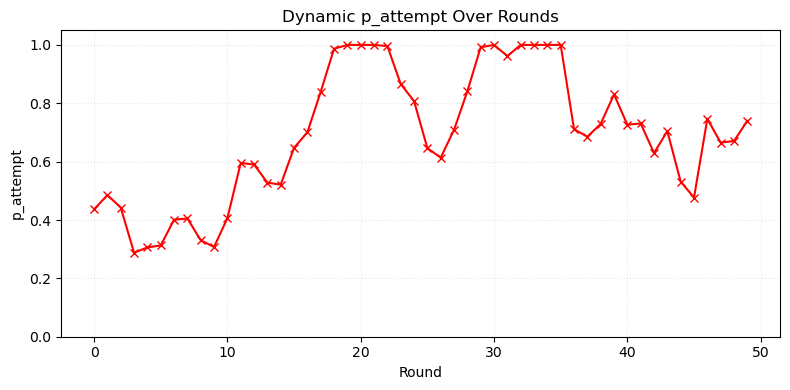

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ──────────────────────────────────────────────────────────
# 0) 파라미터 설정
# ──────────────────────────────────────────────────────────
NUM_USERS   = 500
NUM_ROUNDS  = 50

CP_INIT     = 10_000   # 총 CP 토큰
GOV_INIT    = 1_000   # 총 거버넌스 토큰
Q           = 0.5      # AMM 유동성 비율

P_SUCCESS   = 0.3      # 업그레이드 성공 확률 p_i
CP_I        = 1.0      # 현재 NFT 가치 (정규화)
INITIAL_R   = 1.2      # 업그레이드 가치 계수 r_i

SIGMA_P     = 0.1      # 브라우니안 충격 표준편차
INITIAL_P   = 0.5      # 초기 p_attempt

# ──────────────────────────────────────────────────────────
# 1) 시뮬레이션 함수
# ──────────────────────────────────────────────────────────
def simulate_rw_threshold(alpha, initial_p, R):
    users     = [1]*NUM_USERS
    cp_pool   = CP_INIT * Q
    gov_pool  = GOV_INIT
    swap_rate = gov_pool / cp_pool

    p_attempt = initial_p
    history   = defaultdict(list)

    for rnd in range(NUM_ROUNDS):
        # 1) 기대 업그레이드 가치 E_upgrade (Eq.5)
        E_up = (
            P_SUCCESS * (R * CP_I)
            + (1 - P_SUCCESS) * (alpha * R * CP_I * swap_rate)
        )

        # 2) p_attempt 업데이트
        if E_up > CP_I:
            # 임계점 돌파: 모든 에이전트가 시도
            p_attempt = 1.0
        else:
            # 아직 임계점 미도달: 랜덤 워크
            p_attempt = np.clip(p_attempt + np.random.normal(0, SIGMA_P), 0, 1)

        # 3) 에이전트 행동 (burn-only 모델)
        minted = 0.0
        for i in range(NUM_USERS):
            if users[i] == 1 and random.random() < p_attempt:
                if random.random() >= P_SUCCESS:
                    users[i] = 0
                    minted += alpha * R * CP_I

        # 4) AMM swap (x·y = k)
        if minted > 0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new
            swap_rate = gov_out / minted

        # 5) 기록
        history["round"].append(rnd)
        history["nfts_remaining"].append(sum(users))
        history["p_attempt"].append(p_attempt)

    return history

# ──────────────────────────────────────────────────────────
# 2) 실행 및 시각화
# ──────────────────────────────────────────────────────────
hist = simulate_rw_threshold(alpha=1.0, initial_p=INITIAL_P, R=INITIAL_R)

# NFTs 남은 수
plt.figure(figsize=(8,4))
plt.plot(hist["round"], hist["nfts_remaining"], marker='o')
plt.title("NFTs Remaining Over Rounds")
plt.xlabel("Round")
plt.ylabel("NFTs Remaining")
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

# p_attempt 변화
plt.figure(figsize=(8,4))
plt.plot(hist["round"], hist["p_attempt"], marker='x', color='r')
plt.title("Dynamic p_attempt Over Rounds")
plt.xlabel("Round")
plt.ylabel("p_attempt")
plt.ylim(0,1.05)
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()


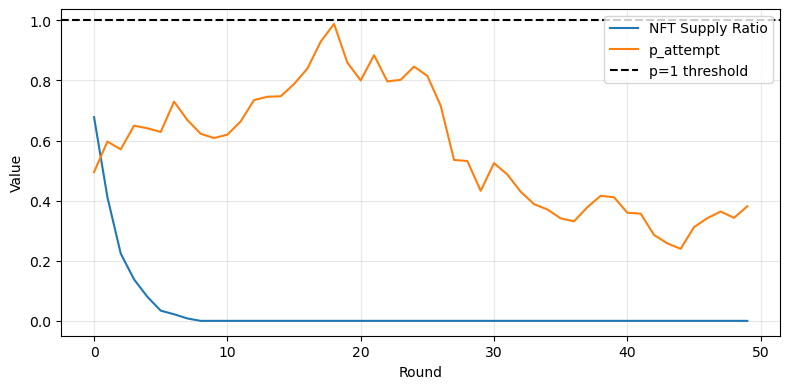

In [16]:
import numpy as np
import random

# ─ 파라미터
NUM_USERS   = 500
NUM_ROUNDS  = 50
DT          = 1.0      # 시간 간격
MU          = 0.0      # drift for p_attempt
SIGMA       = 0.1      # vol for p_attempt
INITIAL_P   = 0.5      # p_attempt 초기값
P_SUCCESS   = 0.3
CP_I        = 1.0
INITIAL_R   = 1.2
CP_INIT     = 1e4
GOV_INIT    = 1e3
Q           = 0.5

def gbm_step(p, mu=MU, sigma=SIGMA, dt=DT):
    """기하 브라운 운동 한 스텝"""
    # dW ~ N(0, sqrt(dt))
    dW = np.random.normal(0, np.sqrt(dt))
    return p * np.exp((mu - 0.5 * sigma**2)*dt + sigma * dW)

def simulate_gbm(alpha=1.0):
    users     = [1]*NUM_USERS
    cp_pool   = CP_INIT * Q
    gov_pool  = GOV_INIT
    swap_rate = gov_pool / cp_pool

    p_attempt = INITIAL_P
    rounds, supply, ps = [], [], []

    for t in range(NUM_ROUNDS):
        # 1) GBM으로 p_attempt 업데이트
        p_attempt = np.clip(gbm_step(p_attempt), 0, 1)

        # 2) E_upgrade 계산 (Eq.5)
        E_up = (P_SUCCESS * (INITIAL_R * CP_I)
                + (1 - P_SUCCESS) * (alpha * INITIAL_R * CP_I * swap_rate))

        # 3) threshold 돌파 시 all-in
        if E_up > CP_I:
            p_attempt = 1.0

        # 4) 에이전트 행동 & AMM 소각
        minted = 0.0
        for i in range(NUM_USERS):
            if users[i] and random.random() < p_attempt:
                if random.random() >= P_SUCCESS:
                    users[i] = 0
                    minted += alpha * INITIAL_R * CP_I

        if minted>0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new
            swap_rate = gov_out / minted

        # 5) 기록
        rounds.append(t)
        supply.append(sum(users)/NUM_USERS)
        ps.append(p_attempt)

    return rounds, supply, ps

# 실행 & 플롯
import matplotlib.pyplot as plt
r, s, p_hist = simulate_gbm()

plt.figure(figsize=(8,4))
plt.plot(r, s, label="NFT Supply Ratio")
plt.plot(r, p_hist, label="p_attempt")
plt.axhline(1.0, color='k', linestyle='--', label="p=1 threshold")
plt.xlabel("Round"); plt.ylabel("Value")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


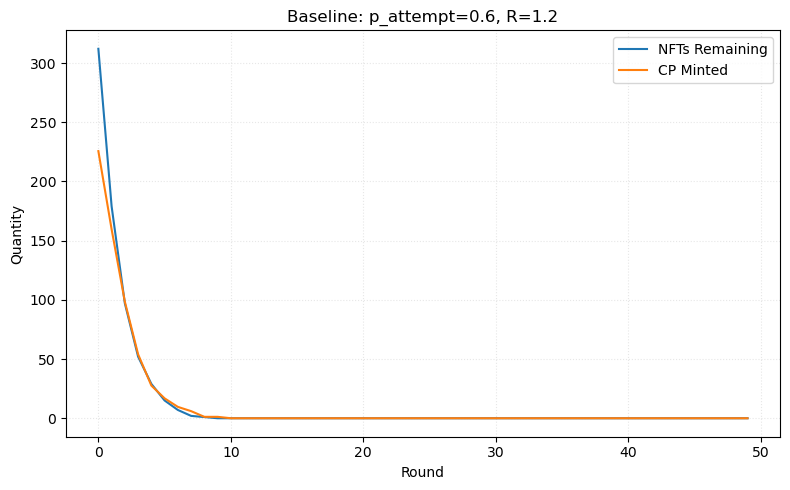

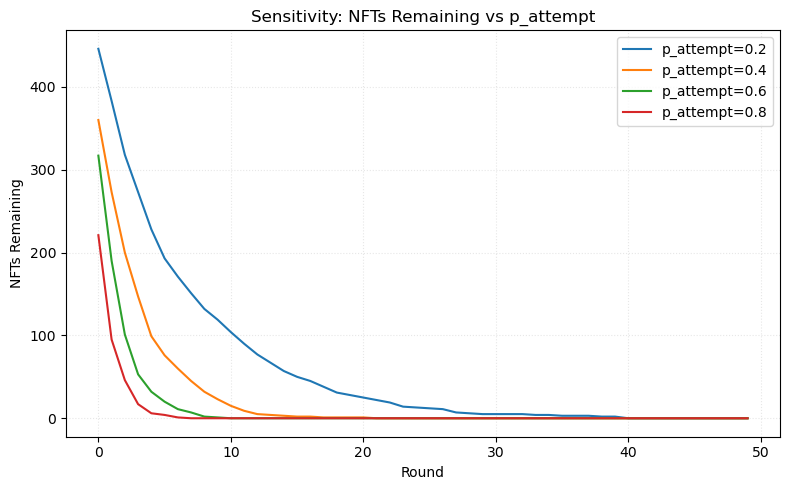

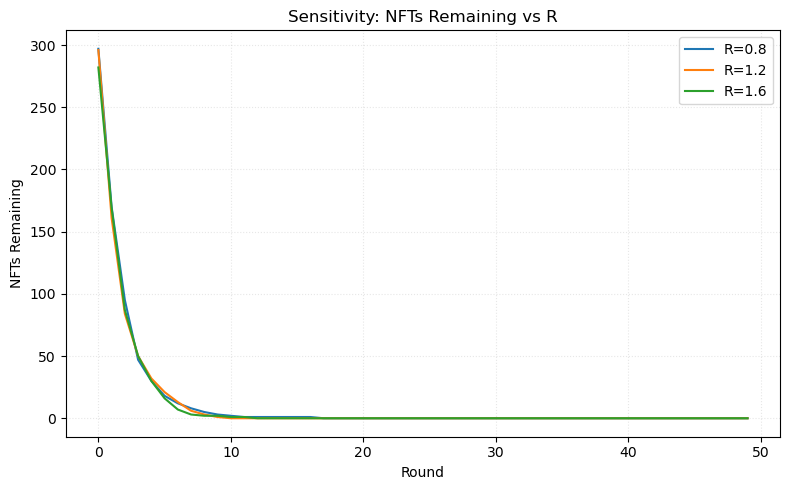

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ──────────────────────────────────────────────────────────
# 0) 시뮬레이션 파라미터 (고정 p_attempt)
# ──────────────────────────────────────────────────────────
NUM_USERS   = 500
NUM_ROUNDS  = 50

CP_INIT     = 10_000   # 총 CP 토큰 (초기)
GOV_INIT    = 10_000   # 총 거버넌스 토큰 (초기)
Q           = 0.5      # AMM 유동성 비율

P_SUCCESS   = 0.3      # 업그레이드 성공 확률 p_i
CP_I        = 1.0      # 정규화된 NFT 기본 가치

# ──────────────────────────────────────────────────────────
# 1) 고정 p_attempt, R용 시뮬레이션 함수
# ──────────────────────────────────────────────────────────
def simulate_fixed(alpha, p_attempt, R):
    users    = [1]*NUM_USERS      # 각 에이전트가 1개 NFT 보유(0 또는 1)
    cp_pool  = CP_INIT * Q
    gov_pool = GOV_INIT
    swap_rate = gov_pool / cp_pool

    history = defaultdict(list)

    for rnd in range(NUM_ROUNDS):
        minted = 0.0

        # ─ 에이전트 행동 (업그레이드 시도 확률 고정)
        for i in range(NUM_USERS):
            if users[i] == 0:
                continue
            if random.random() < p_attempt:
                if random.random() < P_SUCCESS:
                    pass  # 성공: NFT 유지
                else:
                    # 실패: 기대 보상 계산 및 rational burn
                    E_up = (P_SUCCESS * (R * CP_I)
                            + (1 - P_SUCCESS) * (alpha * R * CP_I * swap_rate))
                    if E_up > CP_I:
                        users[i] = 0
                        minted += alpha * R * CP_I

        # ─ AMM swap: CP→거버넌스
        if minted > 0:
            k = cp_pool * gov_pool
            cp_pool += minted
            gov_new = k / cp_pool
            gov_out = max(gov_pool - gov_new, 0.0)
            gov_pool = gov_new
            swap_rate = gov_out / minted

        # ─ 기록
        history["round"].append(rnd)
        history["nfts_remaining"].append(sum(users))
        history["cp_minted"].append(minted)
        history["swap_rate"].append(swap_rate)

    return history

# ──────────────────────────────────────────────────────────
# 2) 베이스라인 실행 및 플롯 (p_attempt=0.6, R=1.2)
# ──────────────────────────────────────────────────────────
hist = simulate_fixed(alpha=1.0, p_attempt=0.6, R=1.2)

plt.figure(figsize=(8,5))
plt.plot(hist["round"], hist["nfts_remaining"], label="NFTs Remaining")
plt.plot(hist["round"], hist["cp_minted"],       label="CP Minted")
plt.title("Baseline: p_attempt=0.6, R=1.2")
plt.xlabel("Round")
plt.ylabel("Quantity")
plt.grid(alpha=0.3, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────
# 3) p_attempt 민감도 분석
# ──────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
for p in [0.2, 0.4, 0.6, 0.8]:
    h = simulate_fixed(alpha=1.0, p_attempt=p, R=1.2)
    plt.plot(h["round"], h["nfts_remaining"], label=f"p_attempt={p}")
plt.title("Sensitivity: NFTs Remaining vs p_attempt")
plt.xlabel("Round")
plt.ylabel("NFTs Remaining")
plt.grid(alpha=0.3, linestyle=":")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────
# 4) Rarity Multiplier(R) 민감도 분석
# ──────────────────────────────────────────────────────────
plt.figure(figsize=(8,5))
for R in [0.8, 1.2, 1.6]:
    h = simulate_fixed(alpha=1.0, p_attempt=0.6, R=R)
    plt.plot(h["round"], h["nfts_remaining"], label=f"R={R}")
plt.title("Sensitivity: NFTs Remaining vs R")
plt.xlabel("Round")
plt.ylabel("NFTs Remaining")
plt.grid(alpha=0.3, linestyle=":")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


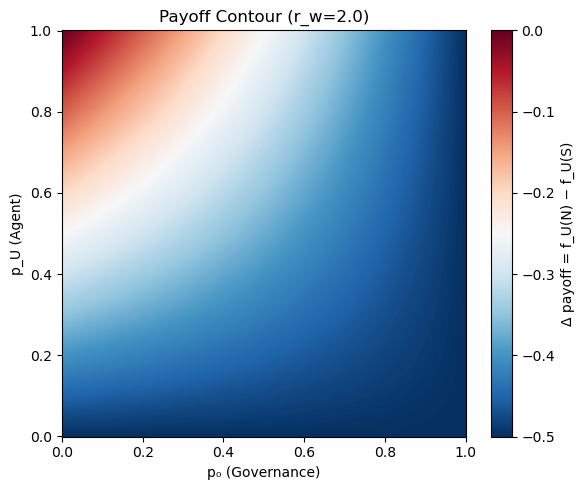

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 수정된 r_w
r_w = 2.0

def f_U_N(pU, p0):
    return 0.5 + 0.5*pU - 0.5*pU*p0*r_w

def f_U_S(pU, p0):
    return pU - 0.5*pU*p0 + 0.5*(1-pU)*r_w

# 그리드 준비
N = 400
pU = np.linspace(0,1,N)
p0 = np.linspace(0,1,N)
P0, PU = np.meshgrid(p0, pU)
Z = f_U_N(PU,P0) - f_U_S(PU,P0)

plt.figure(figsize=(6,5))
# 부드러운 컬러맵
mesh = plt.pcolormesh(P0, PU, Z, shading='auto', cmap='RdBu_r')
plt.colorbar(mesh, label='Δ payoff = f_U(N) − f_U(S)')
# Δ=0 커브
cont = plt.contour(P0, PU, Z, levels=[0], colors='k', linewidths=2)
plt.clabel(cont, fmt='Δ=0', fontsize=10)
plt.xlabel('p₀ (Governance)')
plt.ylabel('p_U (Agent)')
plt.title(f'Payoff Contour (r_w={r_w})')
plt.tight_layout()
plt.show()


시뮬레이션을 시작합니다...
제안 모델 시뮬레이션 완료.
통제 모델 시뮬레이션 완료.
결과를 시각화합니다.


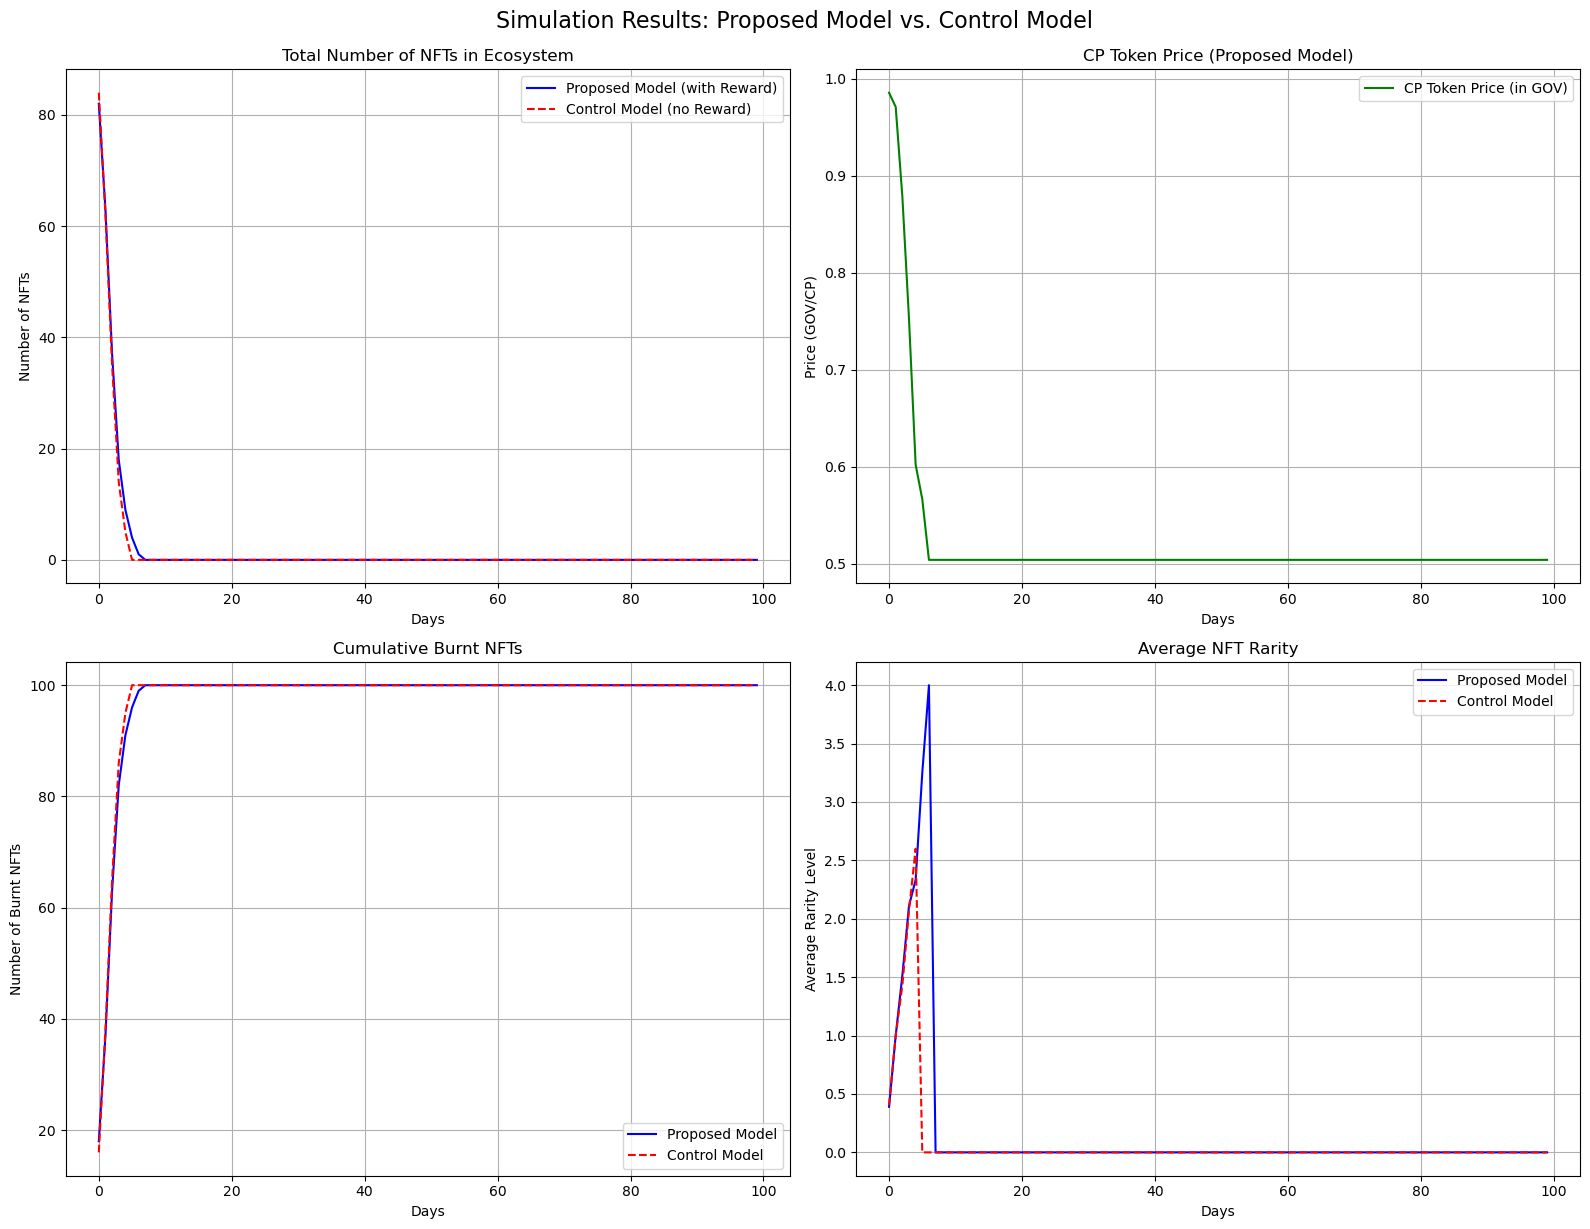

In [20]:
import random
import matplotlib.pyplot as plt
import numpy as np

# --- 시뮬레이션 환경 설정 (논문 파라미터에 맞춰 조정 가능) ---
INITIAL_AGENTS = 50                 # 초기 참여자 수
INITIAL_NFTS_PER_AGENT = 2          # 에이전트당 초기 NFT 수
SIMULATION_STEPS = 100              # 시뮬레이션 진행 기간 (일)

# NFT 업그레이드 관련 설정
# 각 희귀도(rarity) 레벨에서의 업그레이드 성공 확률 (0 -> 1, 1 -> 2, ...)
UPGRADE_PROBS = [0.6, 0.4, 0.2, 0.1] 
# 각 희귀도 레벨 NFT의 가치 (CP 토큰 기준)
NFT_VALUES_IN_CP = [10, 50, 250, 1000, 5000] 
# 실패 보상 계수 (alpha). 논문의 alpha_i * cp_{i+1} 에 해당
# 여기서는 단순화를 위해 alpha를 상수로 가정
REWARD_DECAY_FACTOR = 0.8 

# AMM (CP-GOV Pool) 관련 설정
INITIAL_CP_LIQUIDITY = 10000        # 초기 CP 토큰 유동성
INITIAL_GOV_LIQUIDITY = 10000       # 초기 거버넌스 토큰 유동성 (1 GOV = 1 CP 로 시작)

# --- 핵심 클래스 정의 ---

class AMM:
    """
    CP-거버넌스 토큰 간의 교환을 담당하는 Automated Market Maker 클래스.
    논문의 AMM 메커니즘을 단순화하여 구현.
    """
    def __init__(self, cp_reserves, gov_reserves):
        self.cp_reserves = cp_reserves
        self.gov_reserves = gov_reserves
        if cp_reserves <= 0 or gov_reserves <= 0:
            self.k = 0
        else:
            self.k = cp_reserves * gov_reserves

    def get_cp_price_in_gov(self):
        """CP 토큰 1개의 가치를 거버넌스 토큰 기준으로 반환"""
        if self.cp_reserves == 0:
            return 0
        return self.gov_reserves / self.cp_reserves

    def add_liquidity_cp(self, amount):
        """보상으로 지급된 CP 토큰이 시장에 유동성으로 공급되는 것을 시뮬레이션"""
        # 실제로는 복잡하지만, 여기서는 유동성이 늘어나는 효과만 반영
        self.cp_reserves += amount
        if self.cp_reserves > 0:
            self.gov_reserves = self.k / self.cp_reserves


class Agent:
    """
    P2E 게임에 참여하는 사용자를 나타내는 에이전트 클래스.
    """
    def __init__(self, agent_id):
        self.id = agent_id
        # 각 NFT는 희귀도(rarity) 레벨(정수)로 표현
        self.nfts = [0] * INITIAL_NFTS_PER_AGENT 
        self.cp_tokens = 0

    def decide_action(self):
        """
        에이전트의 행동 결정 로직.
        논문의 'greedy' 가설에 따라, NFT가 있으면 항상 업그레이드를 시도.
        """
        if self.nfts:
            # 가장 낮은 등급의 NFT를 업그레이드 시도
            return 'upgrade'
        return 'idle'

class P2E_Ecosystem:
    """
    P2E 생태계 전체를 시뮬레이션하는 메인 클래스.
    """
    def __init__(self, use_reward_model):
        self.use_reward_model = use_reward_model # True이면 제안 모델, False이면 통제 모델
        self.agents = [Agent(i) for i in range(INITIAL_AGENTS)]
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        
        # 데이터 기록용
        self.history = {
            'total_nfts': [],
            'cp_price': [],
            'burnt_nfts': [],
            'avg_rarity': []
        }
        self.total_burnt_nfts = 0

    def upgrade_nft(self, agent):
        if not agent.nfts:
            return

        # 가장 낮은 등급의 NFT 선택
        rarity = min(agent.nfts)
        agent.nfts.remove(rarity)

        # 업그레이드 시도
        if rarity < len(UPGRADE_PROBS) and random.random() < UPGRADE_PROBS[rarity]:
            # 성공
            agent.nfts.append(rarity + 1)
        else:
            # 실패 (소각)
            self.total_burnt_nfts += 1
            if self.use_reward_model:
                # 제안 모델: 보상 지급
                # 다음 레벨 NFT 가치의 일부를 CP 토큰으로 보상
                if rarity + 1 < len(NFT_VALUES_IN_CP):
                    reward = NFT_VALUES_IN_CP[rarity + 1] * REWARD_DECAY_FACTOR
                    agent.cp_tokens += reward
                    # 보상으로 지급된 토큰이 시장에 영향을 미치는 것을 시뮬레이션
                    self.amm.add_liquidity_cp(reward * 0.1) # 일부만 유동성으로 추가
                
    def step(self):
        """한 타임 스텝(하루)을 진행"""
        random.shuffle(self.agents) # 행동 순서를 무작위로 섞음
        for agent in self.agents:
            action = agent.decide_action()
            if action == 'upgrade':
                self.upgrade_nft(agent)
        
        # 이탈(Churn) 시뮬레이션: NFT가 모두 없어진 에이전트는 떠날 확률이 생김
        agents_to_remove = []
        for agent in self.agents:
            if not agent.nfts and random.random() < 0.1: # 10% 확률로 이탈
                agents_to_remove.append(agent)
        
        for agent in agents_to_remove:
            self.agents.remove(agent)

    def log_data(self):
        """현재 상태의 데이터를 기록"""
        total_nfts = sum(len(a.nfts) for a in self.agents)
        self.history['total_nfts'].append(total_nfts)
        self.history['cp_price'].append(self.amm.get_cp_price_in_gov())
        self.history['burnt_nfts'].append(self.total_burnt_nfts)
        if total_nfts > 0:
            avg_rarity = sum(sum(a.nfts) for a in self.agents) / total_nfts
            self.history['avg_rarity'].append(avg_rarity)
        else:
            self.history['avg_rarity'].append(0)

    def run_simulation(self):
        """전체 시뮬레이션 실행"""
        for day in range(SIMULATION_STEPS):
            self.step()
            self.log_data()
        return self.history

# --- 시뮬레이션 실행 및 결과 비교 ---

print("시뮬레이션을 시작합니다...")

# 시나리오 1: 제안 모델 실행
proposed_sim = P2E_Ecosystem(use_reward_model=True)
proposed_results = proposed_sim.run_simulation()
print("제안 모델 시뮬레이션 완료.")

# 시나리오 2: 통제 모델 실행
control_sim = P2E_Ecosystem(use_reward_model=False)
control_results = control_sim.run_simulation()
print("통제 모델 시뮬레이션 완료.")

# --- 결과 시각화 ---
print("결과를 시각화합니다.")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
steps = range(SIMULATION_STEPS)

# 1. 총 NFT 수량 변화
axs[0, 0].plot(steps, proposed_results['total_nfts'], label='Proposed Model (with Reward)', color='blue')
axs[0, 0].plot(steps, control_results['total_nfts'], label='Control Model (no Reward)', color='red', linestyle='--')
axs[0, 0].set_title('Total Number of NFTs in Ecosystem')
axs[0, 0].set_xlabel('Days')
axs[0, 0].set_ylabel('Number of NFTs')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. CP 토큰 가격 변화 (제안 모델만 해당)
axs[0, 1].plot(steps, proposed_results['cp_price'], label='CP Token Price (in GOV)', color='green')
axs[0, 1].set_title('CP Token Price (Proposed Model)')
axs[0, 1].set_xlabel('Days')
axs[0, 1].set_ylabel('Price (GOV/CP)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. 누적 소각 NFT 수
axs[1, 0].plot(steps, proposed_results['burnt_nfts'], label='Proposed Model', color='blue')
axs[1, 0].plot(steps, control_results['burnt_nfts'], label='Control Model', color='red', linestyle='--')
axs[1, 0].set_title('Cumulative Burnt NFTs')
axs[1, 0].set_xlabel('Days')
axs[1, 0].set_ylabel('Number of Burnt NFTs')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. 평균 NFT 희귀도
axs[1, 1].plot(steps, proposed_results['avg_rarity'], label='Proposed Model', color='blue')
axs[1, 1].plot(steps, control_results['avg_rarity'], label='Control Model', color='red', linestyle='--')
axs[1, 1].set_title('Average NFT Rarity')
axs[1, 1].set_xlabel('Days')
axs[1, 1].set_ylabel('Average Rarity Level')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.suptitle('Simulation Results: Proposed Model vs. Control Model', fontsize=16, y=1.02)
plt.show()

시뮬레이션을 시작합니다...
제안 모델 시뮬레이션 완료.
통제 모델 시뮬레이션 완료.
결과를 시각화합니다.


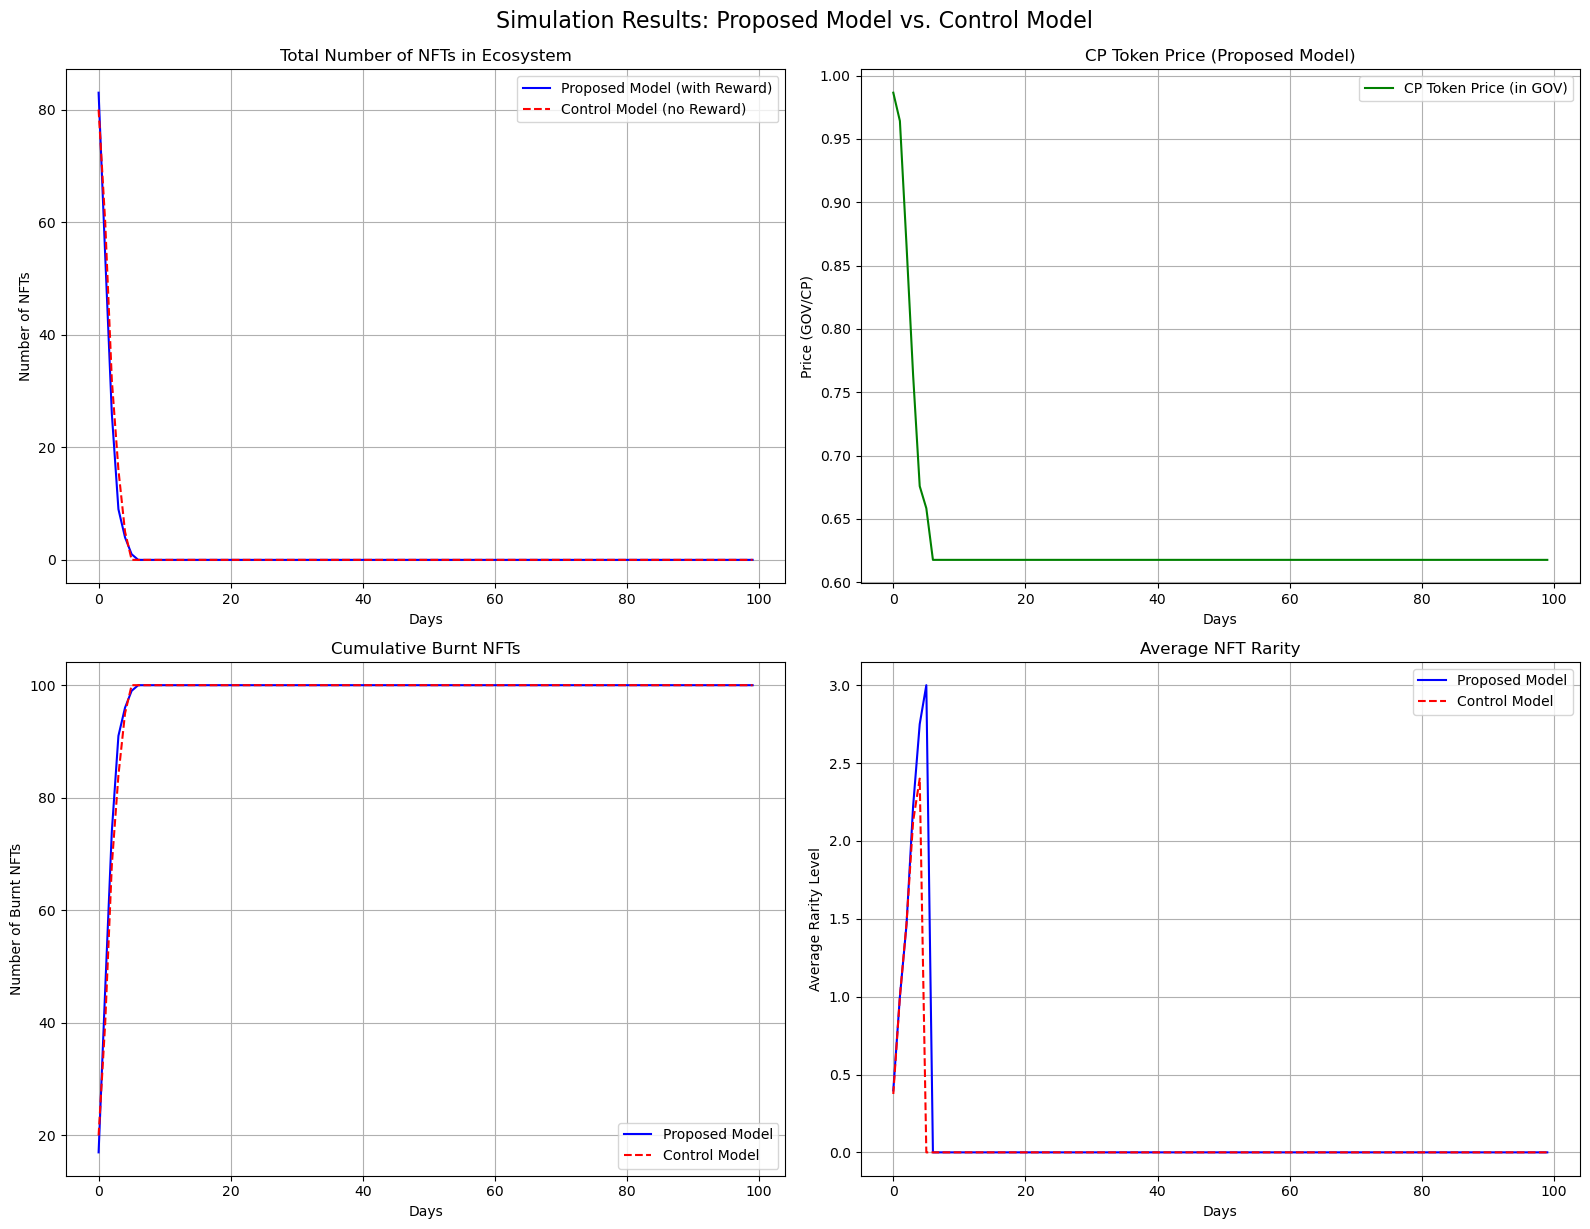

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np

# --- 시뮬레이션 환경 설정 (논문 파라미터에 맞춰 조정 가능) ---
INITIAL_AGENTS = 50                 # 초기 참여자 수
INITIAL_NFTS_PER_AGENT = 2          # 에이전트당 초기 NFT 수
SIMULATION_STEPS = 100              # 시뮬레이션 진행 기간 (일)

# NFT 업그레이드 관련 설정
# 각 희귀도(rarity) 레벨에서의 업그레이드 성공 확률 (0 -> 1, 1 -> 2, ...)
UPGRADE_PROBS = [0.6, 0.4, 0.2, 0.1] 
# 각 희귀도 레벨 NFT의 가치 (CP 토큰 기준)
NFT_VALUES_IN_CP = [10, 50, 250, 1000, 5000] 
# 실패 보상 계수 (alpha). 논문의 alpha_i * cp_{i+1} 에 해당
# 여기서는 단순화를 위해 alpha를 상수로 가정
REWARD_DECAY_FACTOR = 0.8 

# AMM (CP-GOV Pool) 관련 설정
INITIAL_CP_LIQUIDITY = 10000        # 초기 CP 토큰 유동성
INITIAL_GOV_LIQUIDITY = 10000       # 초기 거버넌스 토큰 유동성 (1 GOV = 1 CP 로 시작)

# --- 핵심 클래스 정의 ---

class AMM:
    """
    CP-거버넌스 토큰 간의 교환을 담당하는 Automated Market Maker 클래스.
    논문의 AMM 메커니즘을 단순화하여 구현.
    """
    def __init__(self, cp_reserves, gov_reserves):
        self.cp_reserves = cp_reserves
        self.gov_reserves = gov_reserves
        if cp_reserves <= 0 or gov_reserves <= 0:
            self.k = 0
        else:
            self.k = cp_reserves * gov_reserves

    def get_cp_price_in_gov(self):
        """CP 토큰 1개의 가치를 거버넌스 토큰 기준으로 반환"""
        if self.cp_reserves == 0:
            return 0
        return self.gov_reserves / self.cp_reserves

    def add_liquidity_cp(self, amount):
        """보상으로 지급된 CP 토큰이 시장에 유동성으로 공급되는 것을 시뮬레이션"""
        # 실제로는 복잡하지만, 여기서는 유동성이 늘어나는 효과만 반영
        self.cp_reserves += amount
        if self.cp_reserves > 0:
            self.gov_reserves = self.k / self.cp_reserves


class Agent:
    """
    P2E 게임에 참여하는 사용자를 나타내는 에이전트 클래스.
    """
    def __init__(self, agent_id):
        self.id = agent_id
        # 각 NFT는 희귀도(rarity) 레벨(정수)로 표현
        self.nfts = [0] * INITIAL_NFTS_PER_AGENT 
        self.cp_tokens = 0

    def decide_action(self):
        """
        에이전트의 행동 결정 로직.
        논문의 'greedy' 가설에 따라, NFT가 있으면 항상 업그레이드를 시도.
        """
        if self.nfts:
            # 가장 낮은 등급의 NFT를 업그레이드 시도
            return 'upgrade'
        return 'idle'

class P2E_Ecosystem:
    """
    P2E 생태계 전체를 시뮬레이션하는 메인 클래스.
    """
    def __init__(self, use_reward_model):
        self.use_reward_model = use_reward_model # True이면 제안 모델, False이면 통제 모델
        self.agents = [Agent(i) for i in range(INITIAL_AGENTS)]
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        
        # 데이터 기록용
        self.history = {
            'total_nfts': [],
            'cp_price': [],
            'burnt_nfts': [],
            'avg_rarity': []
        }
        self.total_burnt_nfts = 0

    def upgrade_nft(self, agent):
        if not agent.nfts:
            return

        # 가장 낮은 등급의 NFT 선택
        rarity = min(agent.nfts)
        agent.nfts.remove(rarity)

        # 업그레이드 시도
        if rarity < len(UPGRADE_PROBS) and random.random() < UPGRADE_PROBS[rarity]:
            # 성공
            agent.nfts.append(rarity + 1)
        else:
            # 실패 (소각)
            self.total_burnt_nfts += 1
            if self.use_reward_model:
                # 제안 모델: 보상 지급
                # 다음 레벨 NFT 가치의 일부를 CP 토큰으로 보상
                if rarity + 1 < len(NFT_VALUES_IN_CP):
                    reward = NFT_VALUES_IN_CP[rarity + 1] * REWARD_DECAY_FACTOR
                    agent.cp_tokens += reward
                    # 보상으로 지급된 토큰이 시장에 영향을 미치는 것을 시뮬레이션
                    self.amm.add_liquidity_cp(reward * 0.1) # 일부만 유동성으로 추가
                
    def step(self):
        """한 타임 스텝(하루)을 진행"""
        random.shuffle(self.agents) # 행동 순서를 무작위로 섞음
        for agent in self.agents:
            action = agent.decide_action()
            if action == 'upgrade':
                self.upgrade_nft(agent)
        
        # 이탈(Churn) 시뮬레이션: NFT가 모두 없어진 에이전트는 떠날 확률이 생김
        agents_to_remove = []
        for agent in self.agents:
            if not agent.nfts and random.random() < 0.1: # 10% 확률로 이탈
                agents_to_remove.append(agent)
        
        for agent in agents_to_remove:
            self.agents.remove(agent)

    def log_data(self):
        """현재 상태의 데이터를 기록"""
        total_nfts = sum(len(a.nfts) for a in self.agents)
        self.history['total_nfts'].append(total_nfts)
        self.history['cp_price'].append(self.amm.get_cp_price_in_gov())
        self.history['burnt_nfts'].append(self.total_burnt_nfts)
        if total_nfts > 0:
            avg_rarity = sum(sum(a.nfts) for a in self.agents) / total_nfts
            self.history['avg_rarity'].append(avg_rarity)
        else:
            self.history['avg_rarity'].append(0)

    def run_simulation(self):
        """전체 시뮬레이션 실행"""
        for day in range(SIMULATION_STEPS):
            self.step()
            self.log_data()
        return self.history

# --- 시뮬레이션 실행 및 결과 비교 ---

print("시뮬레이션을 시작합니다...")

# 시나리오 1: 제안 모델 실행
proposed_sim = P2E_Ecosystem(use_reward_model=True)
proposed_results = proposed_sim.run_simulation()
print("제안 모델 시뮬레이션 완료.")

# 시나리오 2: 통제 모델 실행
control_sim = P2E_Ecosystem(use_reward_model=False)
control_results = control_sim.run_simulation()
print("통제 모델 시뮬레이션 완료.")

# --- 결과 시각화 ---
print("결과를 시각화합니다.")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
steps = range(SIMULATION_STEPS)

# 1. 총 NFT 수량 변화
axs[0, 0].plot(steps, proposed_results['total_nfts'], label='Proposed Model (with Reward)', color='blue')
axs[0, 0].plot(steps, control_results['total_nfts'], label='Control Model (no Reward)', color='red', linestyle='--')
axs[0, 0].set_title('Total Number of NFTs in Ecosystem')
axs[0, 0].set_xlabel('Days')
axs[0, 0].set_ylabel('Number of NFTs')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. CP 토큰 가격 변화 (제안 모델만 해당)
axs[0, 1].plot(steps, proposed_results['cp_price'], label='CP Token Price (in GOV)', color='green')
axs[0, 1].set_title('CP Token Price (Proposed Model)')
axs[0, 1].set_xlabel('Days')
axs[0, 1].set_ylabel('Price (GOV/CP)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. 누적 소각 NFT 수
axs[1, 0].plot(steps, proposed_results['burnt_nfts'], label='Proposed Model', color='blue')
axs[1, 0].plot(steps, control_results['burnt_nfts'], label='Control Model', color='red', linestyle='--')
axs[1, 0].set_title('Cumulative Burnt NFTs')
axs[1, 0].set_xlabel('Days')
axs[1, 0].set_ylabel('Number of Burnt NFTs')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. 평균 NFT 희귀도
axs[1, 1].plot(steps, proposed_results['avg_rarity'], label='Proposed Model', color='blue')
axs[1, 1].plot(steps, control_results['avg_rarity'], label='Control Model', color='red', linestyle='--')
axs[1, 1].set_title('Average NFT Rarity')
axs[1, 1].set_xlabel('Days')
axs[1, 1].set_ylabel('Average Rarity Level')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.suptitle('Simulation Results: Proposed Model vs. Control Model', fontsize=16, y=1.02)
plt.show()

In [23]:
# ... (기존 AMM, P2E_Ecosystem 클래스 구조 유지) ...

class Agent:
    def __init__(self, agent_id):
        self.id = agent_id
        self.nfts = [0] * INITIAL_NFTS_PER_AGENT
        self.cp_tokens = 0

    def calculate_expected_values(self, ecosystem):
        """
        자신의 현재 상태를 바탕으로 각 행동의 기대 가치를 계산.
        이것이 이번 시뮬레이션의 핵심입니다.
        """
        if not self.nfts:
            return {'hold': -1, 'upgrade': -1} # 행동 불가

        current_rarity = min(self.nfts)
        next_rarity = current_rarity + 1
        
        # 1. EV(Hold) 계산
        # 현재 NFT의 가치는 '지금 당장 소각했을 때 받을 수 있는 보상'으로 근사 가능
        current_value_in_cp = NFT_VALUES_IN_CP[current_rarity]
        cp_price_in_gov = ecosystem.amm.get_cp_price_in_gov()
        ev_hold = current_value_in_cp * cp_price_in_gov

        # 2. EV(Upgrade) 계산
        if next_rarity >= len(UPGRADE_PROBS): # 최대 레벨이면 업그레이드 불가
             return {'hold': ev_hold, 'upgrade': -1}

        p_success = UPGRADE_PROBS[current_rarity]
        
        # 성공 가치
        next_nft_value_in_cp = NFT_VALUES_IN_CP[next_rarity]
        ev_success = (next_nft_value_in_cp * cp_price_in_gov) * p_success
        
        # 실패 보상 가치 (논문의 alpha_i * cp_{i+1} 와 I 팩터 반영)
        # alpha_i 는 논문에서 p_i * I 로도 표현되므로 이를 활용
        inflation_factor = ecosystem.inflation_factor # DAO가 설정한 I 값
        alpha = p_success * inflation_factor
        
        # 실패 시 받는 CP 토큰 보상
        reward_on_fail_cp = alpha * next_nft_value_in_cp
        # 실패 보상의 실질 가치
        ev_fail = (reward_on_fail_cp * cp_price_in_gov) * (1 - p_success)

        ev_upgrade = ev_success + ev_fail
        
        return {'hold': ev_hold, 'upgrade': ev_upgrade}

    def decide_action(self, ecosystem):
        """기대 가치가 가장 높은 행동을 선택"""
        evs = self.calculate_expected_values(ecosystem)
        
        if evs['upgrade'] > evs['hold']:
            return 'upgrade'
        else:
            return 'hold'

class P2E_Ecosystem:
    def __init__(self, use_reward_model):
        # ... (기존 초기화 코드) ...
        self.inflation_factor = 1.0 # DAO가 조절하는 인플레이션 팩터 'I'

    # ... step, log_data, run_simulation 등 ...

    def check_and_apply_policy(self):
        """
        DAO의 역할을 수행: 시장 상황을 보고 정책(I, p)을 조정.
        이 함수를 매 스텝마다 호출.
        """
        # 예시: 목표 1의 인플레이션 대응 정책
        total_nfts = sum(len(a.nfts) for a in self.agents)
        if total_nfts > INITIAL_AGENTS * INITIAL_NFTS_PER_AGENT * 1.2: # 초기 NFT 수량보다 20% 많으면
            self.inflation_factor = 1.5 # 실패 보상을 늘려서 소각 유도
            print(f"Day {self.current_step}: Inflation detected. Setting I = {self.inflation_factor}")
        else:
            self.inflation_factor = 1.0 # 평소에는 1.0 유지
            
    def run_simulation(self):
        for day in range(SIMULATION_STEPS):
            self.current_step = day
            
            # 목표 2: 외부 충격 시나리오
            if day == 50:
                print(f"Day 50: External shock! GOV token price crashes.")
                self.amm.gov_reserves *= 0.5
                self.amm.k = self.amm.cp_reserves * self.amm.gov_reserves # k 값 재설정
                # DAO의 대응: 충격 흡수를 위해 보상 팩터 대폭 증가
                self.inflation_factor = 2.0 
                print(f"Day 50: DAO reacts. Setting I = {self.inflation_factor} to stabilize.")

            self.check_and_apply_policy() # 매일 DAO 정책 확인
            
            # 에이전트 행동 결정 및 실행 (이제 decide_action은 ecosystem 정보를 필요로 함)
            actions = [(agent, agent.decide_action(self)) for agent in self.agents]
            random.shuffle(actions)
            for agent, action in actions:
                if action == 'upgrade':
                    self.upgrade_nft(agent)
            
            self.log_data()
        return self.history


--- Running Scenario: INFLATION ---
Simulating: Proposed Model
Day 20: New NFTs supplied to all agents (Inflation event)
Day 40: New NFTs supplied to all agents (Inflation event)
Day 60: New NFTs supplied to all agents (Inflation event)
Day 80: New NFTs supplied to all agents (Inflation event)
Day 100: New NFTs supplied to all agents (Inflation event)
Day 120: New NFTs supplied to all agents (Inflation event)
Day 140: New NFTs supplied to all agents (Inflation event)
Simulating: Control Model
Day 20: New NFTs supplied to all agents (Inflation event)
Day 40: New NFTs supplied to all agents (Inflation event)
Day 60: New NFTs supplied to all agents (Inflation event)
Day 80: New NFTs supplied to all agents (Inflation event)
Day 100: New NFTs supplied to all agents (Inflation event)
Day 120: New NFTs supplied to all agents (Inflation event)
Day 140: New NFTs supplied to all agents (Inflation event)


ValueError: keyword alpha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

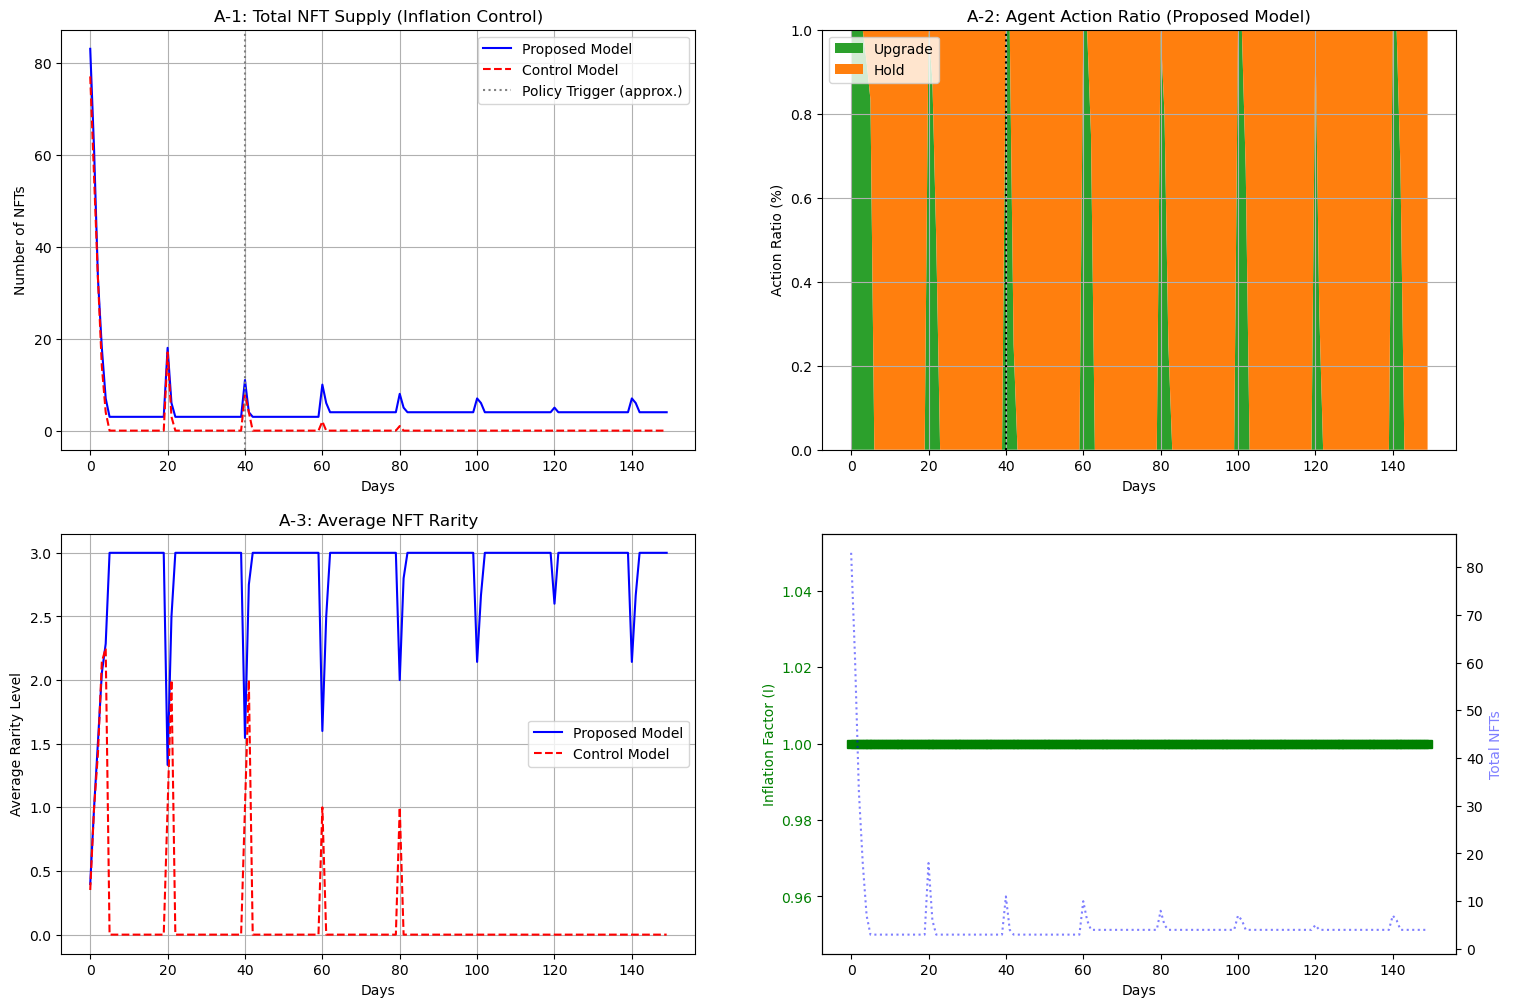

In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 시뮬레이션 환경 설정 ---

# 기본 설정
INITIAL_AGENTS = 50
INITIAL_NFTS_PER_AGENT = 2
SIMULATION_STEPS = 150

# NFT 및 업그레이드 관련 설정
UPGRADE_PROBS = [0.6, 0.4, 0.2, 0.1, 0.05]  # 희귀도 0->1, 1->2, ...
NFT_VALUES_IN_CP = [10, 50, 250, 1000, 5000, 20000] # 각 희귀도 레벨 NFT의 CP 기준 가치

# AMM 및 토큰 관련 설정
INITIAL_CP_LIQUIDITY = 50000
INITIAL_GOV_LIQUIDITY = 50000
# 외부 시장에서의 GOV 토큰 가격 (시뮬레이션의 '실질 가치' 계산에 사용)
GOV_EXTERNAL_PRICE = 1.0 

# --- 2. 핵심 클래스 정의 ---

class AMM:
    """AMM 클래스: CP-GOV 토큰 풀을 관리"""
    def __init__(self, cp_reserves, gov_reserves):
        self.cp_reserves = float(cp_reserves)
        self.gov_reserves = float(gov_reserves)
        self.k = self.cp_reserves * self.gov_reserves

    def get_cp_price_in_gov(self):
        """AMM 내부의 CP 토큰 가격을 GOV 토큰 기준으로 반환"""
        if self.cp_reserves == 0 or self.gov_reserves == 0:
            return 0
        return self.gov_reserves / self.cp_reserves

    def swap_cp_for_gov(self, cp_amount):
        """CP를 팔고 GOV를 얻는 스왑 (여기서는 사용되지 않지만 완전한 형태를 위해 포함)"""
        new_cp_reserves = self.cp_reserves + cp_amount
        new_gov_reserves = self.k / new_cp_reserves
        gov_received = self.gov_reserves - new_gov_reserves
        self.cp_reserves = new_cp_reserves
        self.gov_reserves = new_gov_reserves
        return gov_received

class Agent:
    """에이전트 클래스: 합리적 의사결정 모델 포함"""
    def __init__(self, agent_id):
        self.id = agent_id
        self.nfts = [0] * INITIAL_NFTS_PER_AGENT
        self.cp_tokens = 0.0

    def calculate_expected_values(self, ecosystem):
        """행동의 기대 가치(EV)를 계산 (논문의 게임이론 모델과 직접 연결)"""
        if not self.nfts:
            return {'hold': -1, 'upgrade': -1}

        current_rarity = min(self.nfts)
        next_rarity = current_rarity + 1
        
        # 실질 가치 계산을 위한 현재 CP 토큰의 가격
        cp_price_real = ecosystem.amm.get_cp_price_in_gov() * ecosystem.gov_external_price

        # EV(Hold): 현재 NFT의 가치를 '현재'의 CP 가치로 환산
        ev_hold = NFT_VALUES_IN_CP[current_rarity] * cp_price_real
        
        if next_rarity >= len(NFT_VALUES_IN_CP):
            return {'hold': ev_hold, 'upgrade': -1}

        # EV(Upgrade) 계산
        p_success = ecosystem.upgrade_probs[current_rarity]
        
        # 성공 시 기대 가치
        ev_success = (NFT_VALUES_IN_CP[next_rarity] * cp_price_real) * p_success
        
        # 실패 시 기대 가치 (DAO의 정책 'I' 팩터 반영)
        alpha = p_success * ecosystem.inflation_factor
        reward_on_fail_cp = alpha * NFT_VALUES_IN_CP[next_rarity]
        ev_fail = (reward_on_fail_cp * cp_price_real) * (1 - p_success)

        ev_upgrade = ev_success + ev_fail
        
        return {'hold': ev_hold, 'upgrade': ev_upgrade}

    def decide_action(self, ecosystem):
        """기대 가치가 가장 높은 행동을 선택"""
        if not self.nfts:
            return 'idle'
            
        # 보상 모델이 없는 경우, 무조건 업그레이드 시도 (greedy)
        if not ecosystem.use_reward_model:
            return 'upgrade'

        # 제안 모델의 경우, 합리적으로 판단
        evs = self.calculate_expected_values(ecosystem)
        if evs['upgrade'] > evs['hold']:
            return 'upgrade'
        else:
            return 'hold'

class P2E_Ecosystem:
    """P2E 생태계 메인 클래스: 시나리오 및 DAO 정책 포함"""
    def __init__(self, use_reward_model):
        self.use_reward_model = use_reward_model
        self.agents = [Agent(i) for i in range(INITIAL_AGENTS)]
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        
        # DAO 정책 변수
        self.inflation_factor = 1.0  # 인플레이션 팩터 'I'
        self.upgrade_probs = UPGRADE_PROBS[:] # 기본 성공 확률
        
        # 외부 환경 변수
        self.gov_external_price = GOV_EXTERNAL_PRICE

        # 데이터 로깅용
        self.history = {
            'total_nfts': [], 'active_agents': [], 'avg_rarity': [],
            'cp_price_real': [], 'tvl': [],
            'action_hold': [], 'action_upgrade': [], 'policy_I': [],
        }

    def step(self, day, scenario, new_nft_day):
        # 시나리오에 따른 이벤트 적용
        if scenario == 'inflation' and day > 0 and day % new_nft_day == 0:
            print(f"Day {day}: New NFTs supplied to all agents (Inflation event)")
            for agent in self.agents:
                agent.nfts.append(0)

        if scenario == 'shock' and day == 75:
            print(f"Day {day}: External Shock! GOV token price crashes by 50%.")
            self.gov_external_price *= 0.5

        # DAO 정책 결정 (시나리오별)
        self.apply_dao_policy(day, scenario)

        # 에이전트 행동
        actions_today = {'hold': 0, 'upgrade': 0}
        random.shuffle(self.agents)
        for agent in self.agents:
            action = agent.decide_action(self)
            actions_today[action] = actions_today.get(action, 0) + 1
            if action == 'upgrade':
                self.process_upgrade(agent)
        
        # 사용자 이탈 시뮬레이션
        self.agents = [a for a in self.agents if a.nfts or random.random() > 0.05]
        
        # 데이터 기록
        self.log_data(actions_today)

    def apply_dao_policy(self, day, scenario):
        if not self.use_reward_model: return

        # 목표 1: 인플레이션 대응 정책
        if scenario == 'inflation':
            total_nfts = sum(len(a.nfts) for a in self.agents)
            if total_nfts > INITIAL_AGENTS * INITIAL_NFTS_PER_AGENT * 1.5:
                if self.inflation_factor == 1.0:
                    print(f"Day {day}: Inflation detected. DAO increases rewards for burning (I=1.5).")
                self.inflation_factor = 1.5
            else:
                self.inflation_factor = 1.0
        
        # 목표 2: 외부 충격 대응 정책
        if scenario == 'shock' and day >= 75:
            if self.gov_external_price < GOV_EXTERNAL_PRICE * 0.6:
                 if self.inflation_factor != 2.0:
                    print(f"Day {day}: DAO reacts to shock. Boosting rewards to stabilize (I=2.0).")
                 self.inflation_factor = 2.0

    def process_upgrade(self, agent):
        rarity = min(agent.nfts)
        agent.nfts.remove(rarity)

        if rarity < len(self.upgrade_probs) and random.random() < self.upgrade_probs[rarity]:
            agent.nfts.append(rarity + 1)
        else: # 실패
            if self.use_reward_model:
                next_rarity = rarity + 1
                if next_rarity < len(NFT_VALUES_IN_CP):
                    p_success = self.upgrade_probs[rarity]
                    alpha = p_success * self.inflation_factor
                    reward = alpha * NFT_VALUES_IN_CP[next_rarity]
                    agent.cp_tokens += reward
                    # 보상 토큰의 일부가 시장에 풀리는 효과 (유동성 공급)
                    self.amm.cp_reserves += reward * 0.1
                    self.amm.k = self.amm.cp_reserves * self.amm.gov_reserves
    
    def log_data(self, actions):
        total_nfts = sum(len(a.nfts) for a in self.agents)
        self.history['total_nfts'].append(total_nfts)
        self.history['active_agents'].append(len(self.agents))
        self.history['avg_rarity'].append(sum(sum(a.nfts) for a in self.agents) / total_nfts if total_nfts > 0 else 0)
        
        cp_price_real = self.amm.get_cp_price_in_gov() * self.gov_external_price
        self.history['cp_price_real'].append(cp_price_real)
        
        nft_total_value = sum(NFT_VALUES_IN_CP[r] for a in self.agents for r in a.nfts) * cp_price_real
        amm_total_value = (self.amm.cp_reserves * cp_price_real) + (self.amm.gov_reserves * self.gov_external_price)
        self.history['tvl'].append(nft_total_value + amm_total_value)
        
        total_actions = actions['hold'] + actions['upgrade']
        self.history['action_hold'].append(actions['hold'] / total_actions if total_actions > 0 else 0)
        self.history['action_upgrade'].append(actions['upgrade'] / total_actions if total_actions > 0 else 0)
        self.history['policy_I'].append(self.inflation_factor)

def run_simulation(scenario, new_nft_day=20):
    """시나리오를 실행하고 결과를 반환하는 함수"""
    print(f"\n--- Running Scenario: {scenario.upper()} ---")
    
    # 제안 모델
    print("Simulating: Proposed Model")
    proposed_sim = P2E_Ecosystem(use_reward_model=True)
    for day in range(SIMULATION_STEPS):
        proposed_sim.step(day, scenario, new_nft_day)
    
    # 통제 모델
    print("Simulating: Control Model")
    control_sim = P2E_Ecosystem(use_reward_model=False)
    for day in range(SIMULATION_STEPS):
        control_sim.step(day, scenario, new_nft_day)
        
    return proposed_sim.history, control_sim.history

# --- 3. 시각화 함수 ---

def plot_inflation_results(proposed, control, event_day):
    """목표 1: 인플레이션 대응 시나리오 결과 시각화"""
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    steps = range(SIMULATION_STEPS)
    
    # (1,1) 총 NFT 수량
    axs[0, 0].plot(steps, proposed['total_nfts'], 'b-', label='Proposed Model')
    axs[0, 0].plot(steps, control['total_nfts'], 'r--', label='Control Model')
    axs[0, 0].axvline(x=event_day, color='grey', linestyle=':', label=f'Policy Trigger (approx.)')
    axs[0, 0].set_title('A-1: Total NFT Supply (Inflation Control)')
    axs[0, 0].set_xlabel('Days'); axs[0, 0].set_ylabel('Number of NFTs')
    axs[0, 0].legend(); axs[0, 0].grid(True)
    
    # (1,2) 에이전트 행동 비율
    axs[0, 1].stackplot(steps, [proposed['action_upgrade'], proposed['action_hold']], 
                        labels=['Upgrade', 'Hold'], colors=['#2ca02c', '#ff7f0e'])
    axs[0, 1].axvline(x=event_day, color='black', linestyle=':')
    axs[0, 1].set_title('A-2: Agent Action Ratio (Proposed Model)')
    axs[0, 1].set_xlabel('Days'); axs[0, 1].set_ylabel('Action Ratio (%)')
    axs[0, 1].legend(loc='upper left'); axs[0, 1].grid(True); axs[0, 1].set_ylim(0, 1)

    # (2,1) 평균 NFT 희귀도
    axs[1, 0].plot(steps, proposed['avg_rarity'], 'b-', label='Proposed Model')
    axs[1, 0].plot(steps, control['avg_rarity'], 'r--', label='Control Model')
    axs[1, 0].set_title('A-3: Average NFT Rarity')
    axs[1, 0].set_xlabel('Days'); axs[1, 0].set_ylabel('Average Rarity Level')
    axs[1, 0].legend(); axs[1, 0].grid(True)
    
    # (2,2) DAO 정책 지표
    ax2 = axs[1, 1].twinx()
    axs[1, 1].plot(steps, proposed['policy_I'], 'g-s', label='Inflation Factor (I)')
    axs[1, 1].set_xlabel('Days'); axs[1, 1].set_ylabel('Inflation Factor (I)', color='g')
    axs[1, 1].tick_params(axis='y', labelcolor='g')
    ax2.plot(steps, proposed['total_nfts'], 'b:', alpha=0.5, label='Total NFTs (for context)')
    ax2.set_ylabel('Total NFTs', color='b', alpha=0.5)
    ax2.tick_params(axis='y', labelcolor='b', alpha=0.5)
    axs[1, 1].set_title('A-4: DAO Policy Indicator (I)')
    axs[1, 1].grid(True)

    fig.suptitle('Figure A: Inflation Response Mechanism Simulation', fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_shock_results(proposed, control, event_day):
    """목표 2: 외부 충격 대응 시나리오 결과 시각화"""
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    steps = range(SIMULATION_STEPS)
    
    # (1,1) 생태계 총 가치 (TVL)
    axs[0, 0].plot(steps, proposed['tvl'], 'b-', label='Proposed Model')
    axs[0, 0].plot(steps, control['tvl'], 'r--', label='Control Model')
    axs[0, 0].axvline(x=event_day, color='k', linestyle=':', label='External Shock')
    axs[0, 0].set_title('B-1: Total Value Locked (TVL) in Ecosystem')
    axs[0, 0].set_xlabel('Days'); axs[0, 0].set_ylabel('Total Value (in GOV)')
    axs[0, 0].legend(); axs[0, 0].grid(True)

    # (1,2) CP 토큰 실질 가치
    axs[0, 1].plot(steps, proposed['cp_price_real'], 'g-', label='CP Token Real Value')
    axs[0, 1].axvline(x=event_day, color='k', linestyle=':')
    axs[0, 1].set_title('B-2: Real Value of CP Token (Proposed Model)')
    axs[0, 1].set_xlabel('Days'); axs[0, 1].set_ylabel('Value (in GOV)')
    axs[0, 1].legend(); axs[0, 1].grid(True)
    
    # (2,1) 활성 사용자 수
    axs[1, 0].plot(steps, proposed['active_agents'], 'b-', label='Proposed Model')
    axs[1, 0].plot(steps, control['active_agents'], 'r--', label='Control Model')
    axs[1, 0].axvline(x=event_day, color='k', linestyle=':')
    axs[1, 0].set_title('B-3: Number of Active Agents (User Retention)')
    axs[1, 0].set_xlabel('Days'); axs[1, 0].set_ylabel('Number of Agents')
    axs[1, 0].legend(); axs[1, 0].grid(True)
    
    # (2,2) DAO 정책 대응
    ax2 = axs[1, 1].twinx()
    axs[1, 1].plot(steps, proposed['policy_I'], 'g-s', label='Inflation Factor (I)')
    axs[1, 1].axvline(x=event_day, color='k', linestyle=':')
    axs[1, 1].set_xlabel('Days'); axs[1, 1].set_ylabel('Inflation Factor (I)', color='g')
    axs[1, 1].tick_params(axis='y', labelcolor='g')
    ax2.plot(steps, proposed['cp_price_real'], 'm:', alpha=0.5, label='CP Price (for context)')
    ax2.set_ylabel('CP Price', color='m', alpha=0.5)
    ax2.tick_params(axis='y', labelcolor='m', alpha=0.5)
    axs[1, 1].set_title('B-4: DAO Policy Reaction to Shock')
    axs[1, 1].grid(True)

    fig.suptitle('Figure B: External Shock Response Simulation', fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- 4. 메인 실행부 ---

if __name__ == '__main__':
    # 목표 1 시뮬레이션 및 시각화
    # NFT가 매 20일마다 공급되는 인플레이션 상황
    prop_inf, ctrl_inf = run_simulation(scenario='inflation', new_nft_day=20)
    # 정책 발동 시점은 대략 40일 근처로 예상
    plot_inflation_results(prop_inf, ctrl_inf, event_day=40)

    # 목표 2 시뮬레이션 및 시각화
    # 75일째에 외부 충격 발생
    prop_shk, ctrl_shk = run_simulation(scenario='shock')
    plot_shock_results(prop_shk, ctrl_shk, event_day=75)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.06
Round 20 completed. Current Swap Rate: 2.12
Round 30 completed. Current Swap Rate: 2.17
Round 40 completed. Current Swap Rate: 2.23
--- Round 50: External Shock! Gov_pool is halved. ---
Round 50 completed. Current Swap Rate: 1.14
Round 60 completed. Current Swap Rate: 1.15
Round 70 completed. Current Swap Rate: 1.17
Round 80 completed. Current Swap Rate: 1.20
Round 90 completed. Current Swap Rate: 1.24
Round 100 completed. Current Swap Rate: 1.29
Simulation finished. Plotting results...


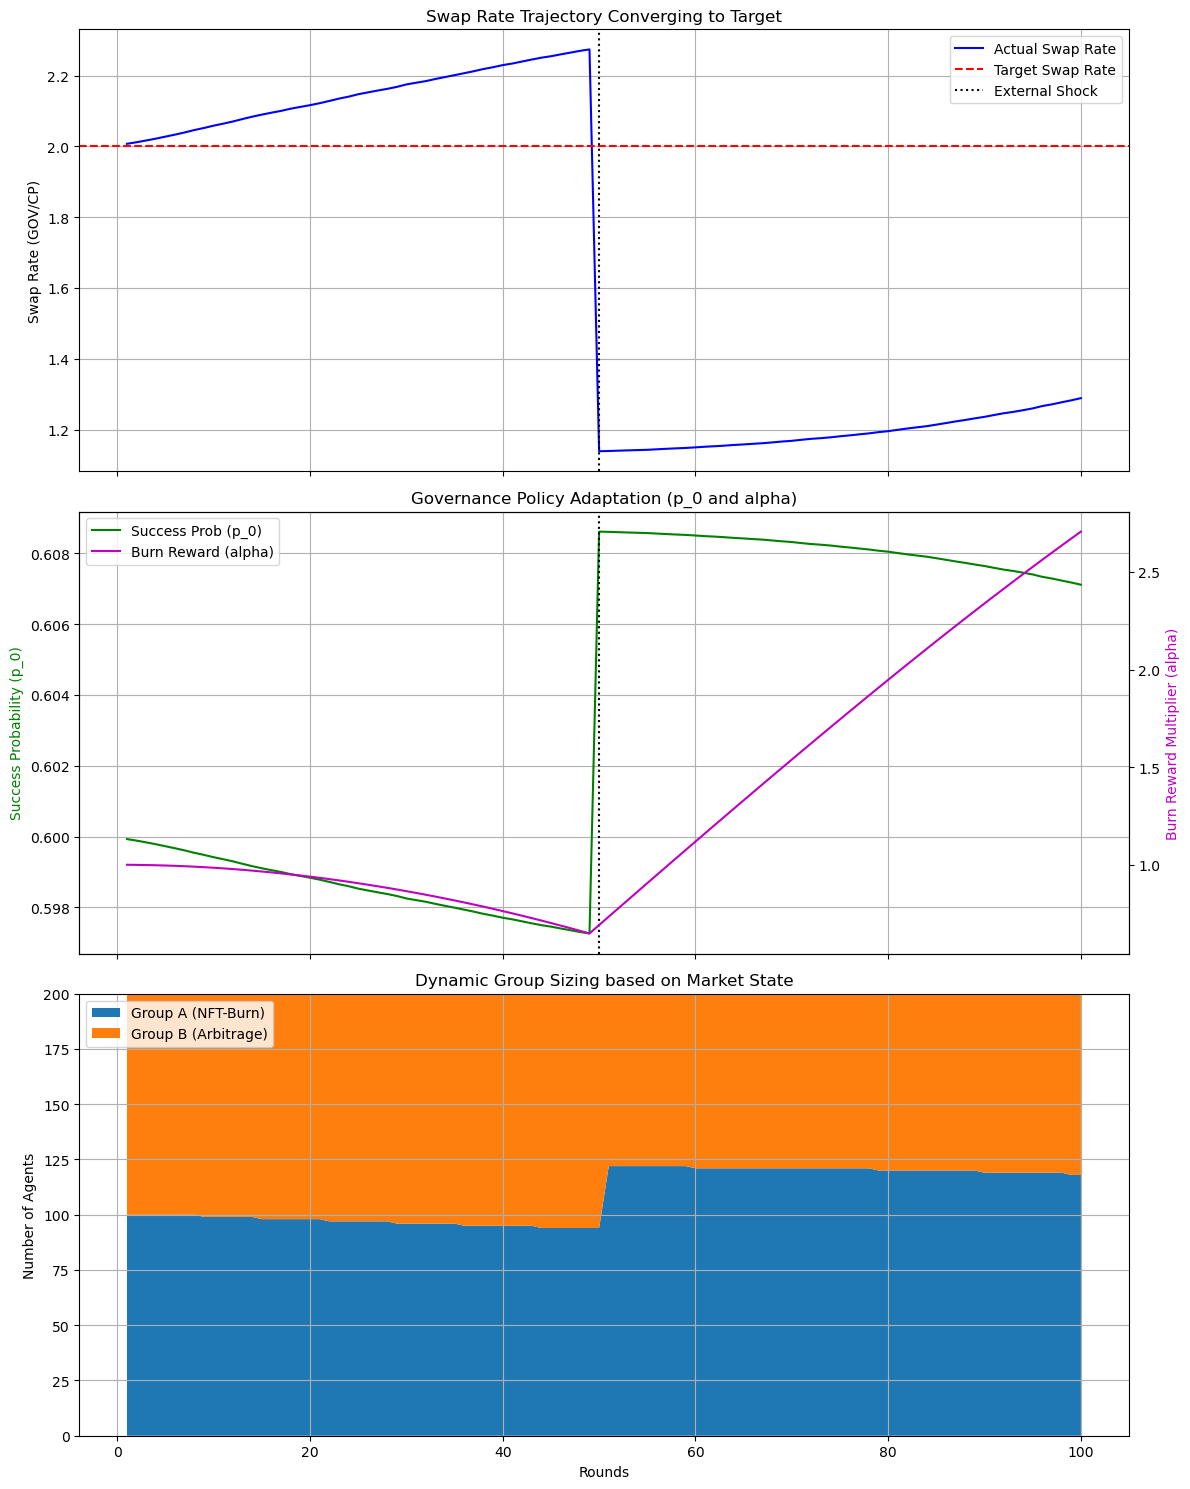

In [28]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math

# --- 1. 시뮬레이션 환경 설정 ---

# 기본 설정
TOTAL_AGENTS = 10000  # 전체 모집단
SAMPLE_SIZE = 200     # 라운드당 샘플 크기 N
SIMULATION_ROUNDS = 100 # 총 라운드 수

# AMM 및 토큰 관련 설정
INITIAL_CP_LIQUIDITY = 100000.0  # L
TARGET_SWAP_RATE = 2.0         # 목표 swap_rate X
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE # L * X

# NFT 및 업그레이드 관련 설정
NFT_LEVELS = 5
# 각 레벨의 NFT 가치 (r_i). 논문의 r_i와는 다른 개념, 여기서는 기본 보상량으로 사용
BASE_REWARD_VALUES = [10, 20, 40, 80, 160] 

# 거버넌스 및 정책 파라미터
# Group B 비율 결정 민감도 kappa
KAPPA = 0.5 
# 정책 피드백 민감도 (학습률 eta)
ETA_P = 0.01  # p_i 조정 민감도
ETA_ALPHA = 0.05 # alpha 조정 민감도

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    """시그모이드 함수"""
    # math.exp()의 오버플로우 방지
    if x >= 0:
        return 1 / (1 + math.exp(-x))
    else:
        return math.exp(x) / (1 + math.exp(x))

class AMM:
    """AMM 클래스: CP-GOV 토큰 풀 관리"""
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.update_k()

    def update_k(self):
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        """현재 swap_rate (GOV/CP)를 반환"""
        if self.cp_pool == 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap(self, cp_change, gov_change):
        """풀의 토큰 양을 직접 조절"""
        self.cp_pool += cp_change
        self.gov_pool += gov_change
        if self.cp_pool <= 0 or self.gov_pool <= 0: # 풀 고갈 방지
            # 실제로는 거래가 중단되지만, 시뮬레이션에서는 작은 값으로 유지
            self.cp_pool = max(self.cp_pool, 1.0)
            self.gov_pool = max(self.gov_pool, 1.0)
        self.update_k()

class Governance:
    """DAO 클래스: 정책(p, alpha)을 관리하고 업데이트"""
    def __init__(self):
        self.p_i = [0.6, 0.4, 0.2, 0.1, 0.05] # 초기 업그레이드 성공 확률
        self.original_p_i = self.p_i[:]
        self.alpha = 1.0 # 초기 burn 보상 계수

    def update_policy(self, error):
        """오차(error)에 기반하여 정책을 피드백 제어 방식으로 업데이트"""
        # p_i 업데이트: error가 양수(과열)일 때 p_i 감소
        self.p_i = [p - ETA_P * error for p in self.original_p_i]
        # 확률이므로 0과 1 사이로 값 제한
        self.p_i = [max(0.01, min(0.99, p)) for p in self.p_i]
        
        # alpha 업데이트: error가 음수(침체)일 때 alpha 증가
        self.alpha = self.alpha - ETA_ALPHA * error
        # alpha는 양수로 유지
        self.alpha = max(0.1, self.alpha)

class Simulation:
    """시뮬레이션 전체를 관리하고 실행"""
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        
        # 데이터 로깅용
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()],
            'p_i_0': [self.governance.p_i[0]], # 레벨0의 p_i 변화 추적
            'alpha': [self.governance.alpha],
            'group_a_size': [],
            'group_b_size': [],
        }

    def run_round(self, round_num):
        # 1. 역할 분배 (비대칭)
        last_swap_rate = self.history['swap_rate'][-1]
        error_for_role = KAPPA * (last_swap_rate - TARGET_SWAP_RATE)
        ratio_b = sigmoid(error_for_role) # Group B (Arbitrage)의 비율
        
        num_group_b = int(SAMPLE_SIZE * ratio_b)
        num_group_a = SAMPLE_SIZE - num_group_b
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # 2. Group A (NFT) 행동
        failures_a = 0
        for _ in range(num_group_a):
            # 단순화를 위해 모든 에이전트가 레벨 0 NFT를 업그레이드 시도한다고 가정
            if random.random() > self.governance.p_i[0]:
                failures_a += 1
        
        # Group A로 인해 발생한 총 CP 보상량
        # 여기서는 기본 보상값 r_i를 BASE_REWARD_VALUES[0]로 가정
        delta_cp_a = failures_a * self.governance.alpha * BASE_REWARD_VALUES[0]

        # 3. Group B (Arbitrage) 행동
        # 제안대로 ΔCP_B(t) = ΔCP_A(t) 로 매칭
        delta_cp_b_demanded = delta_cp_a
        # Group B가 이만큼의 CP를 사기 위해 지불해야 하는 GOV의 양
        gov_to_pay = delta_cp_b_demanded * last_swap_rate
        
        # 4. AMM 풀 업데이트
        # Group A는 CP를 팔고(풀에 CP 증가) GOV를 산다(풀에서 GOV 감소)
        # Group B는 GOV를 팔고(풀에 GOV 증가) CP를 산다(풀에서 CP 감소)
        net_cp_change = delta_cp_a - delta_cp_b_demanded # 실제로는 0이 됨
        net_gov_change = gov_to_pay - (delta_cp_a * last_swap_rate) # 실제로는 0이 됨
        
        # 위 로직은 상쇄되므로, 조금 더 현실적인 모델로 수정:
        # A는 CP를 풀에 넣고, B는 CP를 풀에서 가져감
        # A는 GOV를 풀에서 가져가고, B는 GOV를 풀에 넣음
        gov_for_a = delta_cp_a / last_swap_rate # A가 가져가는 GOV
        
        final_cp_change = delta_cp_a - delta_cp_b_demanded
        final_gov_change = gov_to_pay - gov_for_a
        
        self.amm.swap(final_cp_change, final_gov_change)

        # ** 외부 충격 시나리오 **
        if round_num == 50:
            print(f"--- Round {round_num}: External Shock! Gov_pool is halved. ---")
            self.amm.gov_pool /= 2
            self.amm.update_k()

        # 5. 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        error = current_swap_rate - TARGET_SWAP_RATE
        self.governance.update_policy(error)
        
        # 6. 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i_0'].append(self.governance.p_i[0])
        self.history['alpha'].append(self.governance.alpha)

def plot_results(history, shock_round):
    """시뮬레이션 결과 시각화 (수정된 버전)"""
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    # X축 데이터: 1부터 100까지의 라운드 번호
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    # --- Y축 데이터 슬라이싱 수정 ---
    # history에 저장된 값들은 [초기값, 1라운드값, 2라운드값, ...] 형태이므로
    # 라운드 진행에 따른 변화를 보려면 [1:] 슬라이싱을 사용해야 함.
    actual_swap_rates = history['swap_rate'][1:]
    p_i_0_history = history['p_i_0'][1:]
    alpha_history = history['alpha'][1:]

    # 1. Swap Rate Trajectory
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate')
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].axvline(x=shock_round, color='k', linestyle=':', label='External Shock')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend()
    axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_0_history, 'g-', label='Success Prob (p_0)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_0)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_0 and alpha)')
    axs[1].axvline(x=shock_round, color='k', linestyle=':')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    # 3. Group Size Dynamics
    # 이 데이터들은 라운드 1부터 기록되므로 100개, 슬라이싱 필요 없음
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing based on Market State')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left')
    axs[2].grid(True)
    axs[2].set_ylim(0, SAMPLE_SIZE)
    
    plt.tight_layout()
    plt.show()

# --- 3. 메인 실행부 ---

if __name__ == '__main__':
    simulation = Simulation()
    shock_round_num = 50
    
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}")
    
    print("Simulation finished. Plotting results...")
    plot_results(simulation.history, shock_round_num)



Starting simulation...
Round 10 completed. Current Swap Rate: 1.02
Round 20 completed. Current Swap Rate: 1.04
Round 30 completed. Current Swap Rate: 1.06
Round 40 completed. Current Swap Rate: 1.09
Round 50 completed. Current Swap Rate: 1.12
Round 60 completed. Current Swap Rate: 1.14
Round 70 completed. Current Swap Rate: 1.16
Round 80 completed. Current Swap Rate: 1.19
Round 90 completed. Current Swap Rate: 1.22
Round 100 completed. Current Swap Rate: 1.25
Simulation finished. Plotting results...
[1.0, 1.003012283100448, 1.0031012328173208, 1.0068959698492312, 1.0078629413911795, 1.0097763882832915, 1.0112099552828997, 1.0118385942478507, 1.013298965804605, 1.0172179501487255, 1.017217661847329, 1.0190011336452953, 1.0195619728677234, 1.0207683236223912, 1.0242714741951449, 1.0245436197487132, 1.0282971000619954, 1.0323878611672543, 1.0353140610207825, 1.037911632091549, 1.0381671143013786, 1.0392138221692164, 1.0397695055374172, 1.0408826764452392, 1.0428995987124965, 1.04712095484

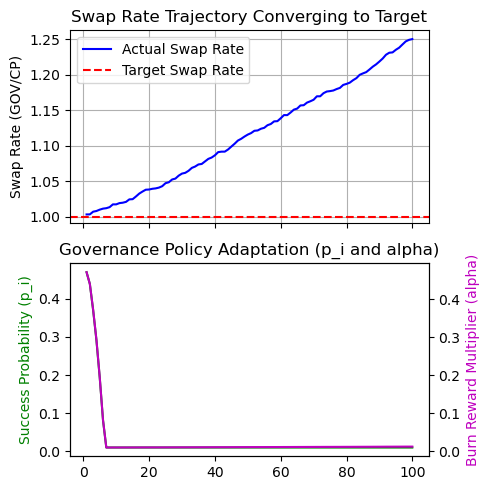

In [ ]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 (동일) ---
TOTAL_AGENTS = 10000
SAMPLE_SIZE = 200
SIMULATION_ROUNDS = 100
INITIAL_CP_LIQUIDITY = 100000.0
RARITY_RATE = 1.2 # NFT 희귀도 증가율
TARGET_SWAP_RATE = 1.0 # swap rate = GOV/CP
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_REWARD_VALUES = 1.0 # Base NFT value in CP
#KAPPA = 0.5
ETA_P = 0.01

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 (AMM 클래스 수정) ---

def sigmoid(x):
    if x >= 0:
        return 1 / (1 + math.exp(-x))
    else:
        return math.exp(x) / (1 + math.exp(x))

class AMM:
    """AMM 클래스: 실제 Uniswap v2 스타일의 스왑 로직으로 수정"""
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool

    def get_swap_rate(self):
        """현재 스왑 비율 (GOV/CP)을 반환"""
        if self.cp_pool == 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        """CP를 풀에 넣고 GOV를 받는 스왑 (슬리피지 발생)"""
        if cp_in <= 0: return 0
        
        # x * y = k 유지
        new_cp_pool = self.cp_pool + cp_in
        new_gov_pool = self.k / new_cp_pool
        gov_out = self.gov_pool - new_gov_pool
        
        # 풀 상태 업데이트
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool
        return gov_out

    def swap_gov_to_cp(self, gov_in):
        """GOV를 풀에 넣고 CP를 받는 스왑 (슬리피지 발생)"""
        if gov_in <= 0: return 0

        # x * y = k 유지
        new_gov_pool = self.gov_pool + gov_in
        new_cp_pool = self.k / new_gov_pool
        cp_out = self.cp_pool - new_cp_pool
        
        # 풀 상태 업데이트
        self.gov_pool = new_gov_pool
        self.cp_pool = new_cp_pool
        return cp_out

class Governance: # (수정 없음)
    def __init__(self, initial_p=0.5, TARGET_SWAP_RATE=TARGET_SWAP_RATE):
        # Probability of success p_i (레벨 0 NFT의 성공 확률)
        self.p_i = initial_p
        self.alpha = TARGET_SWAP_RATE * self.p_i  # 초기 burn 보상 계수
        self.TARGET_SWAP_RATE = TARGET_SWAP_RATE

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.TARGET_SWAP_RATE
        # p_i 업데이트: error가 양수(과열)일 때 p_i 감소
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        self.alpha = current_swap_rate * self.p_i

class Simulation:
    """시뮬레이션 전체 관리 (run_round 메소드 로직 수정)"""
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()],
            'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha],
            'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        # 1. 역할 분배
        last_swap_rate = self.history['swap_rate'][-1]
        error_for_role = KAPPA * (last_swap_rate - TARGET_SWAP_RATE)
        ratio_b = sigmoid(error_for_role)
        
        num_group_a = random.randint(0, SAMPLE_SIZE)
        num_group_b = SAMPLE_SIZE - num_group_a
        
        #num_group_b = int(SAMPLE_SIZE * ratio_b)
        #num_group_a = SAMPLE_SIZE - num_group_b
        
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # 2. Group A (NFT) 행동
        failures_a = 0
        for _ in range(num_group_a):
            if random.random() > self.governance.p_i:
                failures_a += 1
                
        # Total burning reward for Group A
        delta_cp_a = failures_a * self.governance.alpha * BASE_REWARD_VALUES
        
        # 3. AMM 업데이트: 두 그룹의 행동을 '순차적인 집계 스왑'으로 처리
        
        # 3.1. Group A가 총 보상 CP를 시장에 판매 (첫 번째 충격)
        self.amm.swap_cp_to_gov(delta_cp_a)

        # 3.2. Group B가 GOV로 CP를 구매 (두 번째 충격)
        # Group B의 목표: 가장 저렴한 NFT를 사는 것. 즉, CP를 구매
        # swap ratio = GOV/CP
        
        cp_needed_per_agent_b = BASE_REWARD_VALUES
        # 지불할 GOV 총량은 이전 라운드 가격 기준
        gov_to_pay_by_b = num_group_b * cp_needed_per_agent_b * last_swap_rate
        self.amm.swap_gov_to_cp(gov_to_pay_by_b)
        
        # 4. 외부 충격 시나리오
        #if round_num == 50:
        #    print(f"--- Round {round_num}: External Shock! Gov_pool is halved. ---")
        #    self.amm.gov_pool /= 2
        #    self.amm.k = self.amm.cp_pool * self.amm.gov_pool
        
        # 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 6. 기록 (동일)
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)

# --- plot_results 및 메인 실행부 (수정 없음) ---
def plot_results(history):
    #fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    # --- Y축 데이터 슬라이싱 수정 ---
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    # 1. Swap Rate Trajectory    
    #axs[0].plot(rounds, [history['swap_rate'][0] for i in range(1, SIMULATION_ROUNDS + 1)], 'b-', label='Ideal Swap Rate')
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate')
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend(); axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    
    '''
    axs[1].axvline(x=shock_round, color='k', linestyle=':')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing based on Market State')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left')
    axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)
    '''
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}")
    print("Simulation finished. Plotting results...")
    print(simulation.history['swap_rate'])
    print(simulation.history['p_i'])
    print(simulation.history['alpha'])
    print(simulation.history['group_a_size'])
    print(simulation.history['group_b_size'])
    
    
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.28, p_i: 0.48
Round 20 completed. Current Swap Rate: 2.61, p_i: 0.44
Round 30 completed. Current Swap Rate: 3.03, p_i: 0.36
Round 40 completed. Current Swap Rate: 3.89, p_i: 0.21
Round 50 completed. Current Swap Rate: 5.14, p_i: 0.01
Round 60 completed. Current Swap Rate: 6.90, p_i: 0.01
Round 70 completed. Current Swap Rate: 10.11, p_i: 0.01
Round 80 completed. Current Swap Rate: 15.55, p_i: 0.01
Round 90 completed. Current Swap Rate: 27.64, p_i: 0.01
Round 100 completed. Current Swap Rate: 58.87, p_i: 0.01
Simulation finished. Plotting results...
[0.5, 0.499891277228816, 0.4992918773726244, 0.49839764839350537, 0.496921071686146, 0.49509496675891024, 0.49268209898279225, 0.4903518904783688, 0.4879973744151405, 0.48561484193417, 0.48280013286478723, 0.47991598312440603, 0.47662956946473073, 0.4730704139139692, 0.4692009885766035, 0.4651470511229804, 0.46039690843256703, 0.4553213271334036, 0.44952311935611045, 0.443521985

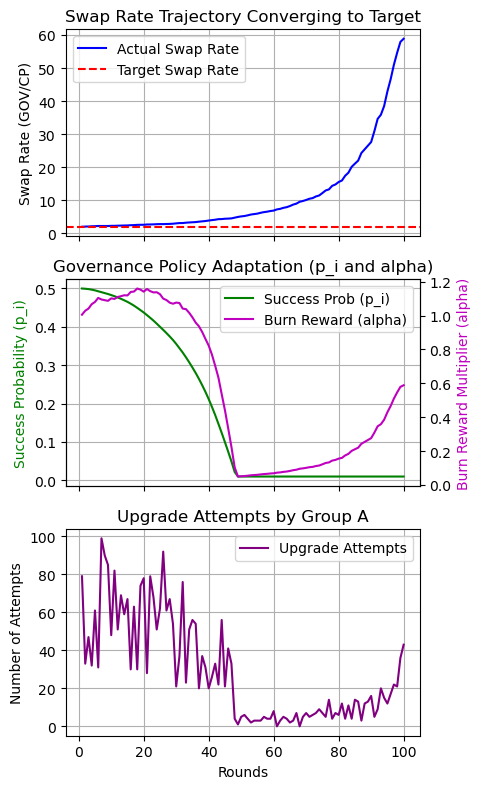

In [67]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
TOTAL_AGENTS = 10000
SAMPLE_SIZE = 200
SIMULATION_ROUNDS = 100
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0         # 목표 swap rate = GOV/CP
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0          # 기본 NFT의 가치 (CP 기준)
RARITY_RATE = 1.2              # 업그레이드 성공 시 가치 증가율 r_i
ETA_P = 0.01                   # 정책 반응 민감도

# --- 2. 헬퍼 함수 및 클래스 정의 ---
def sigmoid(x):
    # 수치적 안정성을 위한 구현
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool

    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        gov_out = self.gov_pool - new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool
        return gov_out

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        cp_out = self.cp_pool - new_cp_pool
        self.gov_pool = new_gov_pool
        self.cp_pool = new_cp_pool
        return cp_out

class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        # alpha는 p_i와 시장 상황에 따라 결정되는 종속 변수
        self.alpha = self.target_swap_rate * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        # alpha는 항상 현재 시장 상황과 업데이트된 p_i를 반영
        self.alpha = current_swap_rate * self.p_i

class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()],
            'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha],
            'group_a_size': [], 'group_b_size': [],
            'attempts': [], # 업그레이드 시도 횟수 추적
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        # 1. 역할 분배 (무작위 할당으로 단순화하여 안정성 확보)
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # 2. Group A (NFT) 행동: 기대 효용 기반 행동 선택
        failures_a = 0
        attempts_a = 0
        for _ in range(num_group_a):
            # 2.1. 기대 효용(Expected Utility) 계산
            # 성공 시 가치: 기본 가치 * 희귀도 증가율
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            # 실패 시 보상 가치: 기본 가치 * alpha
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            
            # 기대 효용 = (성공확률 * 성공가치) + (실패확률 * 실패보상)
            # 이 가치는 CP 토큰 기준임.
            expected_utility_cp = (self.governance.p_i * value_on_success) + \
                                  ((1 - self.governance.p_i) * reward_on_fail)

            # 2.2. 행동 결정: 기대 효용을 현재 가치(유지)와 비교
            # 현재 가치는 BASE_NFT_VALUE.
            # 기대 효용이 현재 가치보다 높으면 시도할 유인이 생김
            # 공저자 제안대로, 기대 효용이 높을수록 시도할 확률이 높아지는 모델 적용
            attempt_probability = expected_utility_cp / (BASE_NFT_VALUE * 2) # 정규화를 위한 분모 조정
            attempt_probability = max(0, min(1, attempt_probability)) # 0~1 사이로 제한
            
            if random.random() < attempt_probability:
                # 에이전트가 업그레이드를 '시도'하기로 결정
                attempts_a += 1
                
                # 2.3. 시도 결과 판정
                if random.random() > self.governance.p_i:
                    # 실패! -> burning 발생
                    failures_a += 1

        self.history['attempts'].append(attempts_a)
                
        # 2.4. 총 보상량 계산
        delta_cp_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 3. AMM 업데이트
        # 3.1. Group A가 총 보상 CP를 시장에 판매
        self.amm.swap_cp_to_gov(delta_cp_a)

        # 3.2. Group B가 GOV로 CP를 구매
        cp_needed_per_agent_b = BASE_NFT_VALUE
        gov_to_pay_by_b = (num_group_b * cp_needed_per_agent_b) * last_swap_rate
        self.amm.swap_gov_to_cp(gov_to_pay_by_b)
        
        # 4. 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 5. 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True) # 3x1로 변경
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    # 1. Swap Rate Trajectory    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend(); axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    # 3. Group A 행동 변화 (시도 횟수)
    axs[2].plot(rounds, history['attempts'], color='purple', label='Upgrade Attempts')
    axs[2].set_title('Upgrade Attempts by Group A')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Attempts')
    axs[2].legend(); axs[2].grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}")
    print("Simulation finished. Plotting results...")
    print(simulation.history['p_i'])
    print(simulation.history['alpha'])
    print(simulation.history['group_a_size'])
    print(simulation.history['group_b_size'])
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.44, p_i: 0.26, alpha: 0.31
Round 20 completed. Current Swap Rate: 3.12, p_i: 0.01, alpha: 0.02
Round 30 completed. Current Swap Rate: 4.10, p_i: 0.01, alpha: 0.02
Round 40 completed. Current Swap Rate: 6.09, p_i: 0.01, alpha: 0.02
Round 50 completed. Current Swap Rate: 8.52, p_i: 0.01, alpha: 0.02
Round 60 completed. Current Swap Rate: 13.73, p_i: 0.01, alpha: 0.02
Round 70 completed. Current Swap Rate: 22.29, p_i: 0.01, alpha: 0.02
Round 80 completed. Current Swap Rate: 46.92, p_i: 0.01, alpha: 0.02
Round 90 completed. Current Swap Rate: 147.47, p_i: 0.01, alpha: 0.02
Round 100 completed. Current Swap Rate: 2171.32, p_i: 0.01, alpha: 0.02
Simulation finished. Plotting results...


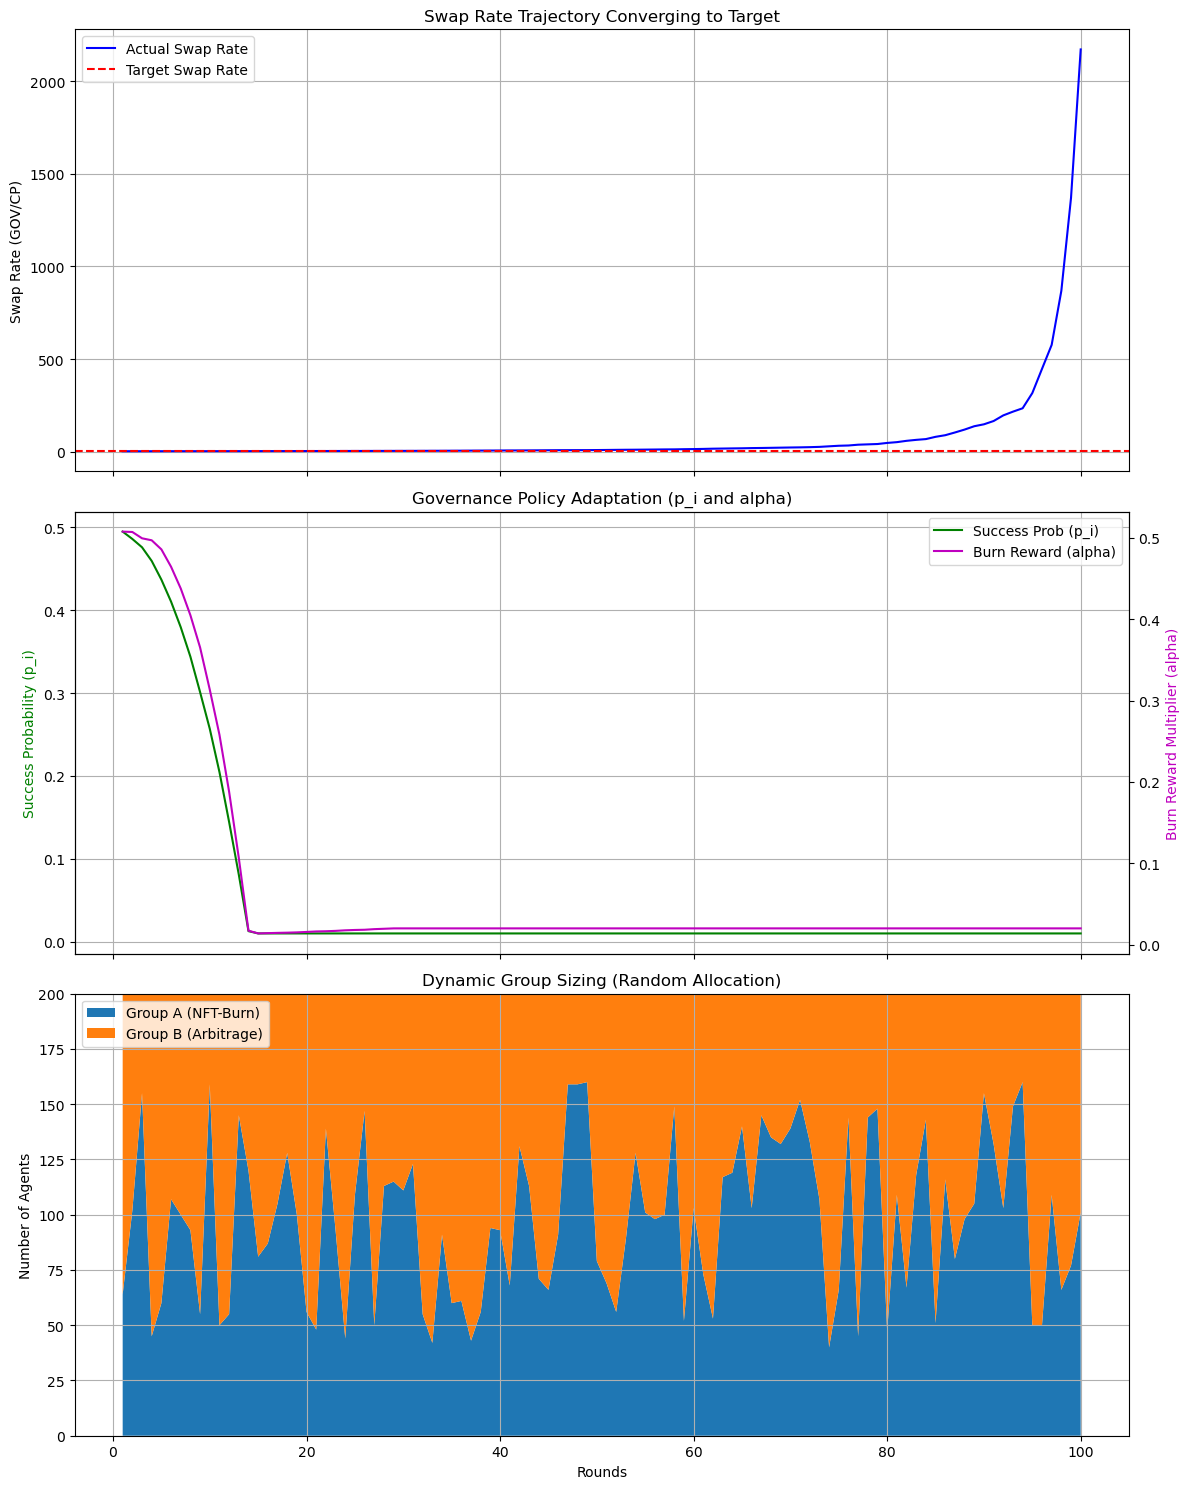

In [75]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
TOTAL_AGENTS = 10000
SAMPLE_SIZE = 200
SIMULATION_ROUNDS = 100
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0         # 목표 swap rate = GOV/CP
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0          # 기본 NFT의 가치 (CP 기준)
RARITY_RATE = 1.2              # 업그레이드 성공 시 가치 증가율
ETA_P = 0.1                   # 정책 반응 민감도
INFLATION_FACTOR_CAP = 2.0     # I의 상한선 (DAO의 규칙)

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---
def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool

    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        gov_out = self.gov_pool - new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool
        return gov_out

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        cp_out = self.cp_pool - new_cp_pool
        self.gov_pool = new_gov_pool
        self.cp_pool = new_cp_pool
        return cp_out

class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        # alpha는 p_i와 시장 상황(I)에 따라 결정되는 종속 변수
        self.alpha = 1.0 * self.p_i # 초기 I=1.0 가정

    def update_policy(self, current_swap_rate):
        # 1. 오차 계산
        error = current_swap_rate - self.target_swap_rate
        
        # 2. p_i 업데이트 (점진적 조정)
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))

        # 3. alpha 업데이트 (논문 정의를 정확히 따름)
        # 3.1. 인플레이션 팩터 I 계산
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        # 3.2. I에 상한선 적용 (DAO의 규칙)
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        # 3.3. 최종 alpha 계산
        self.alpha = self.p_i * capped_I


class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()],
            'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha],
            'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        # 1. 역할 분배 (안정적인 무작위 할당)
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # 2. Group A 행동: 기대 효용 기반 행동 선택
        failures_a = 0
        for _ in range(num_group_a):
            # 2.1. 기대 효용 계산
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            expected_utility_cp = (self.governance.p_i * value_on_success) + \
                                  ((1 - self.governance.p_i) * reward_on_fail)
            
            # 2.2. 행동 결정
            attempt_probability = expected_utility_cp / (BASE_NFT_VALUE * 2)
            attempt_probability = max(0, min(1, attempt_probability))
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
                
        # 2.3. 총 보상량 계산
        delta_cp_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 3. AMM 업데이트
        self.amm.swap_cp_to_gov(delta_cp_a)
        
        cp_needed_per_agent_b = BASE_NFT_VALUE
        gov_to_pay_by_b = (num_group_b * cp_needed_per_agent_b) * last_swap_rate
        self.amm.swap_gov_to_cp(gov_to_pay_by_b)
        
        # 4. 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 5. 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    # 1. Swap Rate Trajectory    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend(); axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    # 3. Group Size Dynamics
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left')
    axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.42, p_i: 0.31, alpha: 0.37
Round 20 completed. Current Swap Rate: 2.99, p_i: 0.01, alpha: 0.01
Round 30 completed. Current Swap Rate: 4.12, p_i: 0.01, alpha: 0.02
Round 40 completed. Current Swap Rate: 6.24, p_i: 0.01, alpha: 0.02
Round 50 completed. Current Swap Rate: 8.72, p_i: 0.01, alpha: 0.02
Round 60 completed. Current Swap Rate: 14.34, p_i: 0.01, alpha: 0.02
Round 70 completed. Current Swap Rate: 30.32, p_i: 0.01, alpha: 0.02
Round 80 completed. Current Swap Rate: 74.18, p_i: 0.01, alpha: 0.02
Round 90 completed. Current Swap Rate: 476.14, p_i: 0.01, alpha: 0.02
Round 100 completed. Current Swap Rate: 671876882.29, p_i: 0.01, alpha: 0.02
Simulation finished. Plotting results...


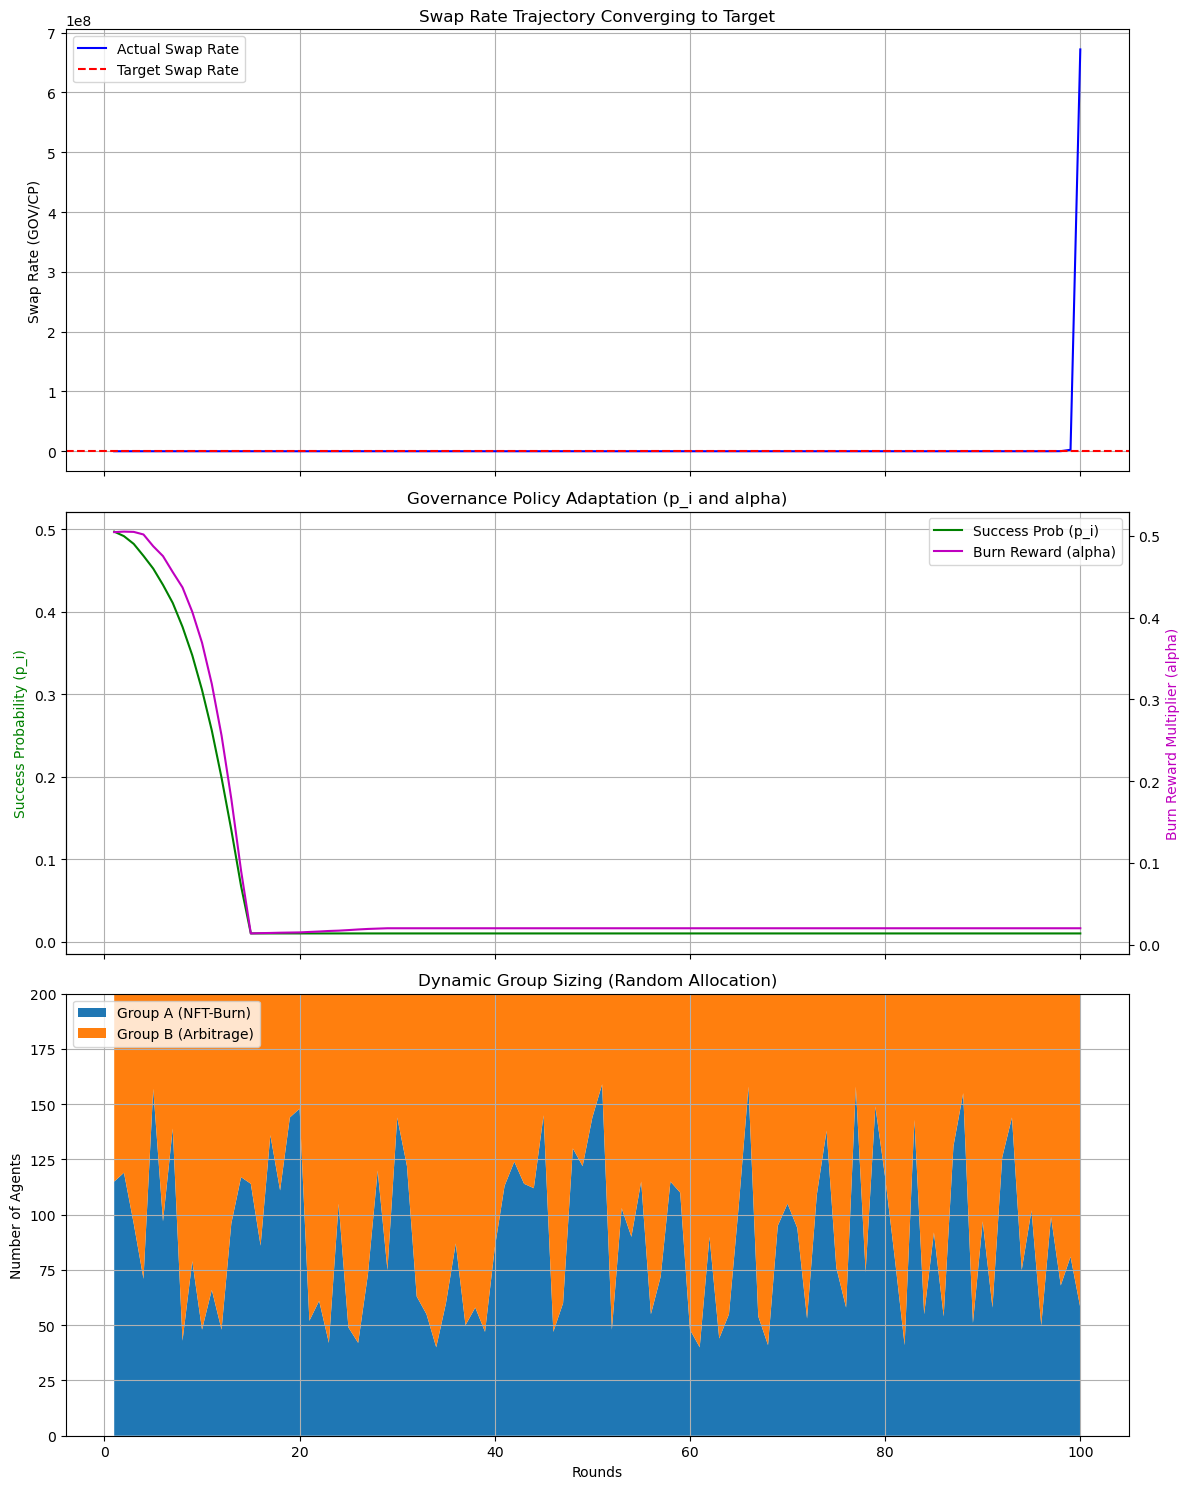

In [ ]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
TOTAL_AGENTS = 10000
SAMPLE_SIZE = 200
SIMULATION_ROUNDS = 100
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0         # 목표 swap rate = GOV/CP
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0          # 기본 NFT의 가치 (CP 기준)
RARITY_RATE = 1.2              # 업그레이드 성공 시 가치 증가율
ETA_P = 0.1                   # 정책 반응 민감도
INFLATION_FACTOR_CAP = 2.0     # I의 상한선 (DAO의 규칙)

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---
def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool

    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        gov_out = self.gov_pool - new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool
        return gov_out

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        cp_out = self.cp_pool - new_cp_pool
        self.gov_pool = new_gov_pool
        self.cp_pool = new_cp_pool
        return cp_out

class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        # alpha는 p_i와 시장 상황(I)에 따라 결정되는 종속 변수
        self.alpha = 1.0 * self.p_i # 초기 I=1.0 가정

    def update_policy(self, current_swap_rate):
        # 1. 오차 계산
        error = current_swap_rate - self.target_swap_rate
        
        # 2. p_i 업데이트 (점진적 조정)
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))

        # 3. alpha 업데이트 (논문 정의를 정확히 따름)
        # 3.1. 인플레이션 팩터 I 계산
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        # 3.2. I에 상한선 적용 (DAO의 규칙)
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        # 3.3. 최종 alpha 계산
        self.alpha = self.p_i * capped_I


class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()],
            'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha],
            'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        # 1. 역할 분배 (안정적인 무작위 할당)
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # 2. Group A 행동: 기대 효용 기반 행동 선택
        failures_a = 0
        for _ in range(num_group_a):
            # 2.1. 기대 효용 계산
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            expected_utility_cp = (self.governance.p_i * value_on_success) + \
                                  ((1 - self.governance.p_i) * reward_on_fail)
            
            # 2.2. 행동 결정
            attempt_probability = expected_utility_cp / (BASE_NFT_VALUE * 2)
            attempt_probability = max(0, min(1, attempt_probability))
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
                
        # 2.3. 총 보상량 계산
        delta_cp_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 3. AMM 업데이트
        self.amm.swap_cp_to_gov(delta_cp_a)
        
        cp_needed_per_agent_b = BASE_NFT_VALUE
        gov_to_pay_by_b = (num_group_b * cp_needed_per_agent_b) * last_swap_rate
        self.amm.swap_gov_to_cp(gov_to_pay_by_b)
        
        # 4. 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 5. 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    # 1. Swap Rate Trajectory    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend(); axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    # 3. Group Size Dynamics
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left')
    axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.52, p_i: 0.19, alpha: 0.24
Round 20 completed. Current Swap Rate: 3.22, p_i: 0.01, alpha: 0.02
Round 30 completed. Current Swap Rate: 4.51, p_i: 0.01, alpha: 0.02
Round 40 completed. Current Swap Rate: 6.55, p_i: 0.01, alpha: 0.02
Round 50 completed. Current Swap Rate: 11.05, p_i: 0.01, alpha: 0.02
Round 60 completed. Current Swap Rate: 20.49, p_i: 0.01, alpha: 0.02
Round 70 completed. Current Swap Rate: 57.12, p_i: 0.01, alpha: 0.02
Round 80 completed. Current Swap Rate: 242.15, p_i: 0.01, alpha: 0.02
Round 90 completed. Current Swap Rate: 124761.53, p_i: 0.01, alpha: 0.02
Round 100 completed. Current Swap Rate: inf, p_i: 0.01, alpha: 0.02
Simulation finished. Plotting results...


/usr/lib/python3.13/site-packages/matplotlib/ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


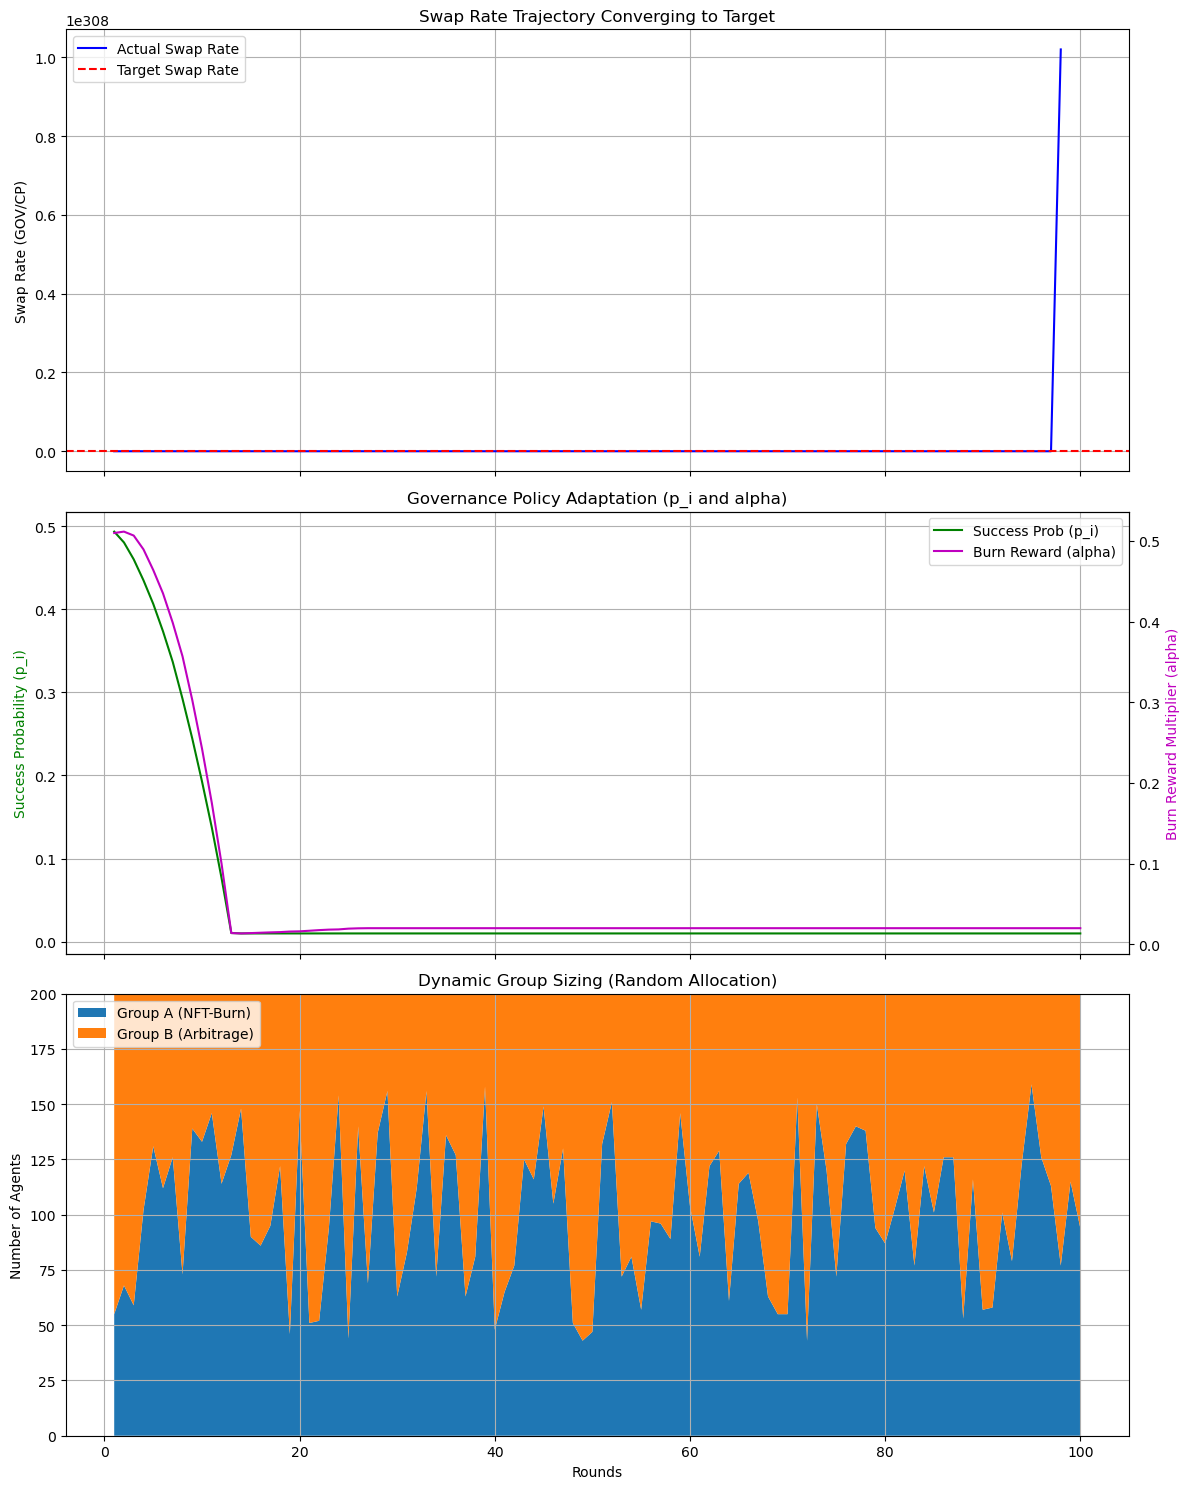

In [78]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
TOTAL_AGENTS = 10000
SAMPLE_SIZE = 200
SIMULATION_ROUNDS = 100
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0         # 목표 swap rate = GOV/CP
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0          # 기본 NFT의 가치 (CP 기준)
RARITY_RATE = 1.2              # 업그레이드 성공 시 가치 증가율
ETA_P = 0.1                   # 정책 반응 민감도
INFLATION_FACTOR_CAP = 2.0     # I의 상한선 (DAO의 규칙)

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---
def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool

    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        gov_out = self.gov_pool - new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool
        return gov_out

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        cp_out = self.cp_pool - new_cp_pool
        self.gov_pool = new_gov_pool
        self.cp_pool = new_cp_pool
        return cp_out

class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        # alpha는 p_i와 시장 상황(I)에 따라 결정되는 종속 변수
        self.alpha = 1.0 * self.p_i # 초기 I=1.0 가정

    def update_policy(self, current_swap_rate):
        # 1. 오차 계산
        error = current_swap_rate - self.target_swap_rate
        
        # 2. p_i 업데이트 (점진적 조정)
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))

        # 3. alpha 업데이트 (논문 정의를 정확히 따름)
        # 3.1. 인플레이션 팩터 I 계산
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        # 3.2. I에 상한선 적용 (DAO의 규칙)
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        # 3.3. 최종 alpha 계산
        self.alpha = self.p_i * capped_I


class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()],
            'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha],
            'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        # 1. 역할 분배 (안정적인 무작위 할당)
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # 2. Group A 행동: 기대 효용 기반 행동 선택
        failures_a = 0
        for _ in range(num_group_a):
            # 2.1. 기대 효용 계산
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            expected_utility_cp = (self.governance.p_i * value_on_success) + \
                                  ((1 - self.governance.p_i) * reward_on_fail)
            
            # 2.2. 행동 결정
            attempt_probability = expected_utility_cp / (BASE_NFT_VALUE * 2)
            attempt_probability = max(0, min(1, attempt_probability))
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
                
        # 2.3. 총 보상량 계산
        delta_cp_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 3. AMM 업데이트
        self.amm.swap_cp_to_gov(delta_cp_a)
        
        cp_needed_per_agent_b = BASE_NFT_VALUE * RARITY_RATE
        gov_to_pay_by_b = (num_group_b * cp_needed_per_agent_b) * last_swap_rate
        self.amm.swap_gov_to_cp(gov_to_pay_by_b)
        
        # 4. 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 5. 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    # 1. Swap Rate Trajectory    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend(); axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    # 3. Group Size Dynamics
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left')
    axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.53, p_i: 0.27, alpha: 0.34
Round 20 completed. Current Swap Rate: 3.30, p_i: 0.01, alpha: 0.02
Round 30 completed. Current Swap Rate: 4.54, p_i: 0.01, alpha: 0.02
Round 40 completed. Current Swap Rate: 6.61, p_i: 0.01, alpha: 0.02
Round 50 completed. Current Swap Rate: 10.83, p_i: 0.01, alpha: 0.02
Round 60 completed. Current Swap Rate: 18.76, p_i: 0.01, alpha: 0.02
Round 70 completed. Current Swap Rate: 35.22, p_i: 0.01, alpha: 0.02
Round 80 completed. Current Swap Rate: 135.27, p_i: 0.01, alpha: 0.02
Round 90 completed. Current Swap Rate: 7362.44, p_i: 0.01, alpha: 0.02
Round 100 completed. Current Swap Rate: inf, p_i: 0.01, alpha: 0.02
Simulation finished. Plotting results...
{'cp_pool': 2.860587752246056e-156, 'gov_pool': 6.9915701709540435e+165, 'swap_rate': inf}


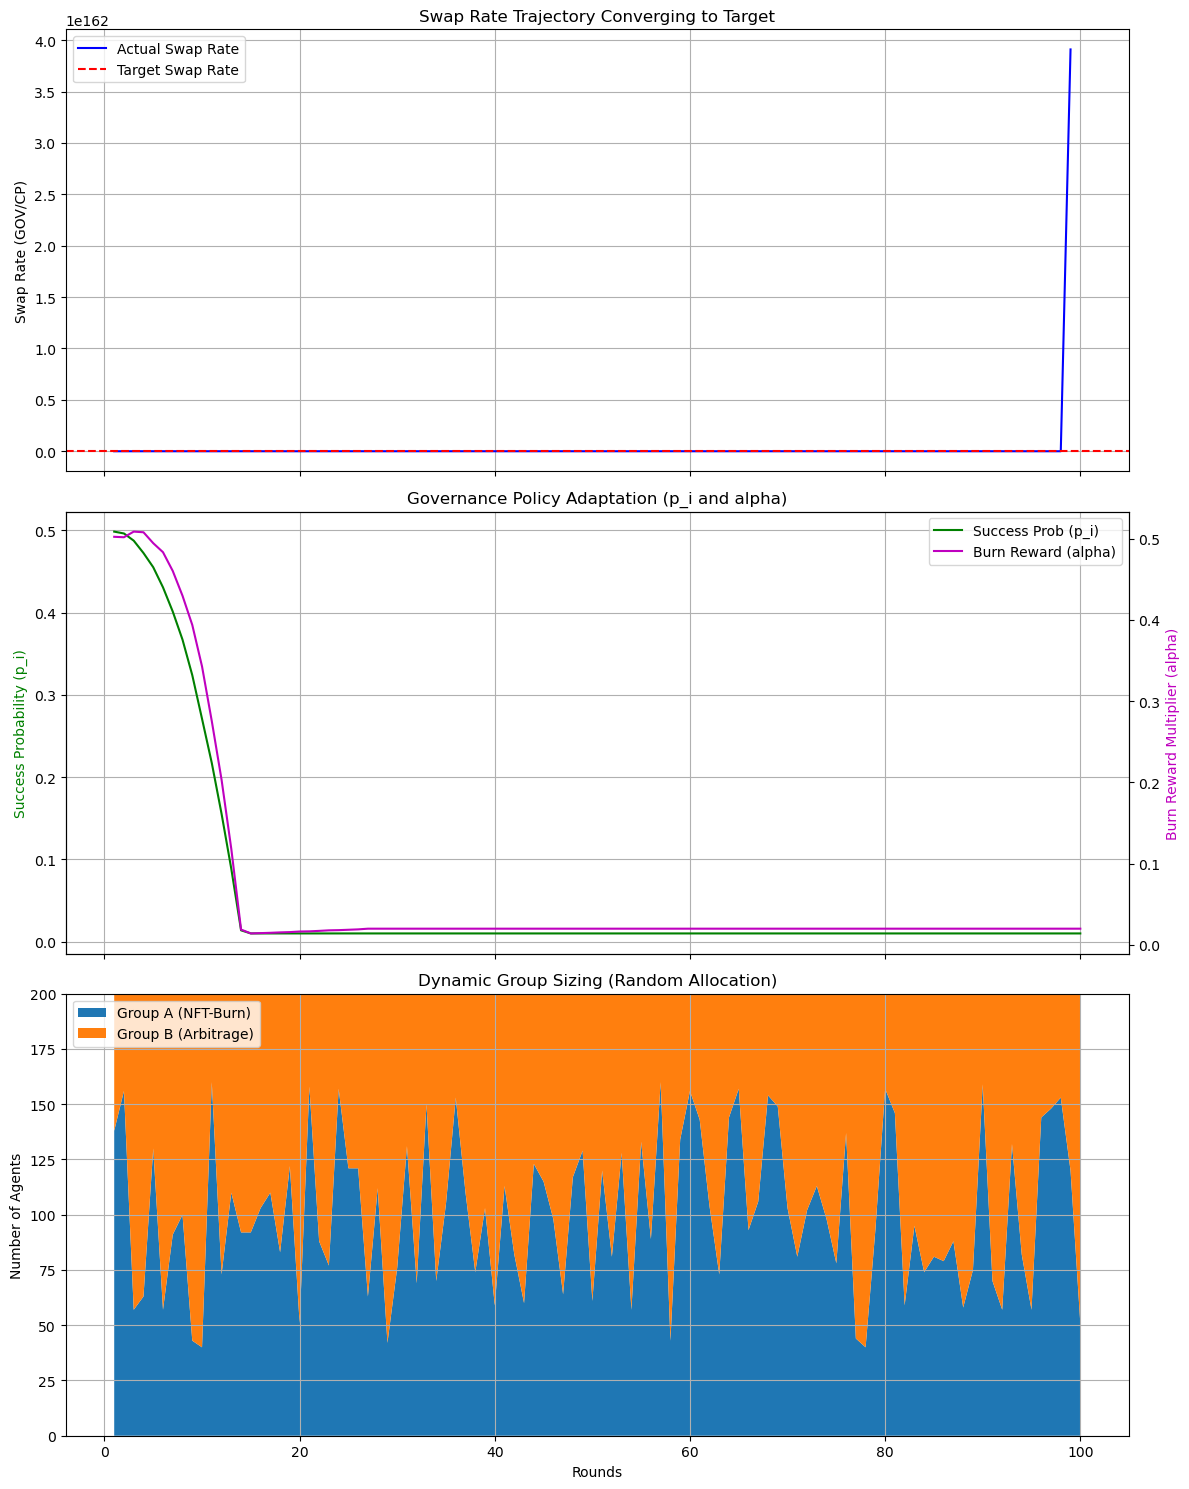

In [88]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200

# AMM & Token Parameters
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE

# NFT & Reward Parameters
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2

# Governance & Agent Behavior Parameters
ETA_P = 0.1  # 정책 반응 속도 (DAO)
INFLATION_FACTOR_CAP = 2.0 # I의 상한선 (DAO)

# --- 공저자 제안 핵심 파라미터 ---
# 에이전트 행동 결정 민감도 (Agent)
BETA = 0.5 
# 비활동 시 발생하는 전략적 손해 (기회비용) (Agent)
# 이 값은 DAO가 p_i를 낮출 때 함께 조절할 수도 있음
GAMMA = 0.5 

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---
def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    # ... (이전과 동일, 수정 없음)
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool
    
    def get_cp_pool_amount(self):
        return self.cp_pool
    
    def get_gov_pool_amount(self):
        return self.gov_pool
    
    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        gov_out = self.gov_pool - new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool
        return gov_out
    
    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        cp_out = self.cp_pool - new_cp_pool
        self.gov_pool = new_gov_pool
        self.cp_pool = new_cp_pool
        return cp_out

class Governance:
    # ... (이전과 동일, 수정 없음)
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i
        
    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()], 'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha], 'group_a_size': [], 'group_b_size': [],
            'attempts': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # --- Group A 행동: 기대 효용 + 기회비용 기반 행동 선택 (핵심 수정) ---
        failures_a = 0
        attempts_a = 0
        for _ in range(num_group_a):
            # 1. 시도했을 때의 효용 계산
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            
            # 2. 가만히 있을 때의 효용 (기회비용)
            # 논문의 철학: p_i가 낮아질수록, 다른 사람이 성공할 확률이 높아져
            # 나의 상대적 가치가 하락하므로 '가만히 있는 것'의 손실이 커진다.
            # 이 손실을 p_i에 반비례하도록 모델링.
            # p_i가 0.01일 때 최대 손실 GAMMA, p_i가 0.99일 때 최소 손실 0
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)

            # 3. 효용 차이를 이용한 시도 확률 계산
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                attempts_a += 1
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        self.history['attempts'].append(attempts_a)
                
        # --- AMM 업데이트 및 기타 로직 (이전과 동일) ---
        cp_to_sell_per_fail = self.governance.alpha * BASE_NFT_VALUE
        delta_cp_a = failures_a * cp_to_sell_per_fail
        
        gov_to_pay_per_b = (BASE_NFT_VALUE * RARITY_RATE) * last_swap_rate
        total_gov_to_pay_by_b = num_group_b * gov_to_pay_per_b

        # 순차적 개별 스왑 로직을 단순화하여 집계 스왑으로 변경 (안정성 확보)
        # 1. Group A가 먼저 시장에 판매
        self.amm.swap_cp_to_gov(delta_cp_a)
        # 2. Group B가 시장에서 구매
        self.amm.swap_gov_to_cp(total_gov_to_pay_by_b)
        
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)
        
    def get_pool_info(self):
        return {
            'cp_pool': self.amm.get_cp_pool_amount(),
            'gov_pool': self.amm.get_gov_pool_amount(),
            'swap_rate': self.amm.get_swap_rate()
        }


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    # 1. Swap Rate Trajectory    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)')
    axs[0].legend(); axs[0].grid(True)
    
    # 2. Governance Policy Dynamics
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    axs[1].grid(True)
    
    # 3. Group Size Dynamics
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds')
    axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left')
    axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    print(simulation.get_pool_info())
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 1.99, p_i: 0.50, alpha: 0.50
Round 20 completed. Current Swap Rate: 1.99, p_i: 0.51, alpha: 0.51
Round 30 completed. Current Swap Rate: 1.99, p_i: 0.53, alpha: 0.52
Round 40 completed. Current Swap Rate: 1.99, p_i: 0.54, alpha: 0.54
Round 50 completed. Current Swap Rate: 1.98, p_i: 0.55, alpha: 0.55
Round 60 completed. Current Swap Rate: 1.99, p_i: 0.57, alpha: 0.56
Round 70 completed. Current Swap Rate: 1.98, p_i: 0.58, alpha: 0.58
Round 80 completed. Current Swap Rate: 1.98, p_i: 0.60, alpha: 0.60
Round 90 completed. Current Swap Rate: 1.98, p_i: 0.62, alpha: 0.62
Round 100 completed. Current Swap Rate: 1.99, p_i: 0.64, alpha: 0.63
Simulation finished. Plotting results...
{'cp_pool': 100351.38759835699, 'gov_pool': 199299.68562116276, 'swap_rate': 1.9860182344347155}


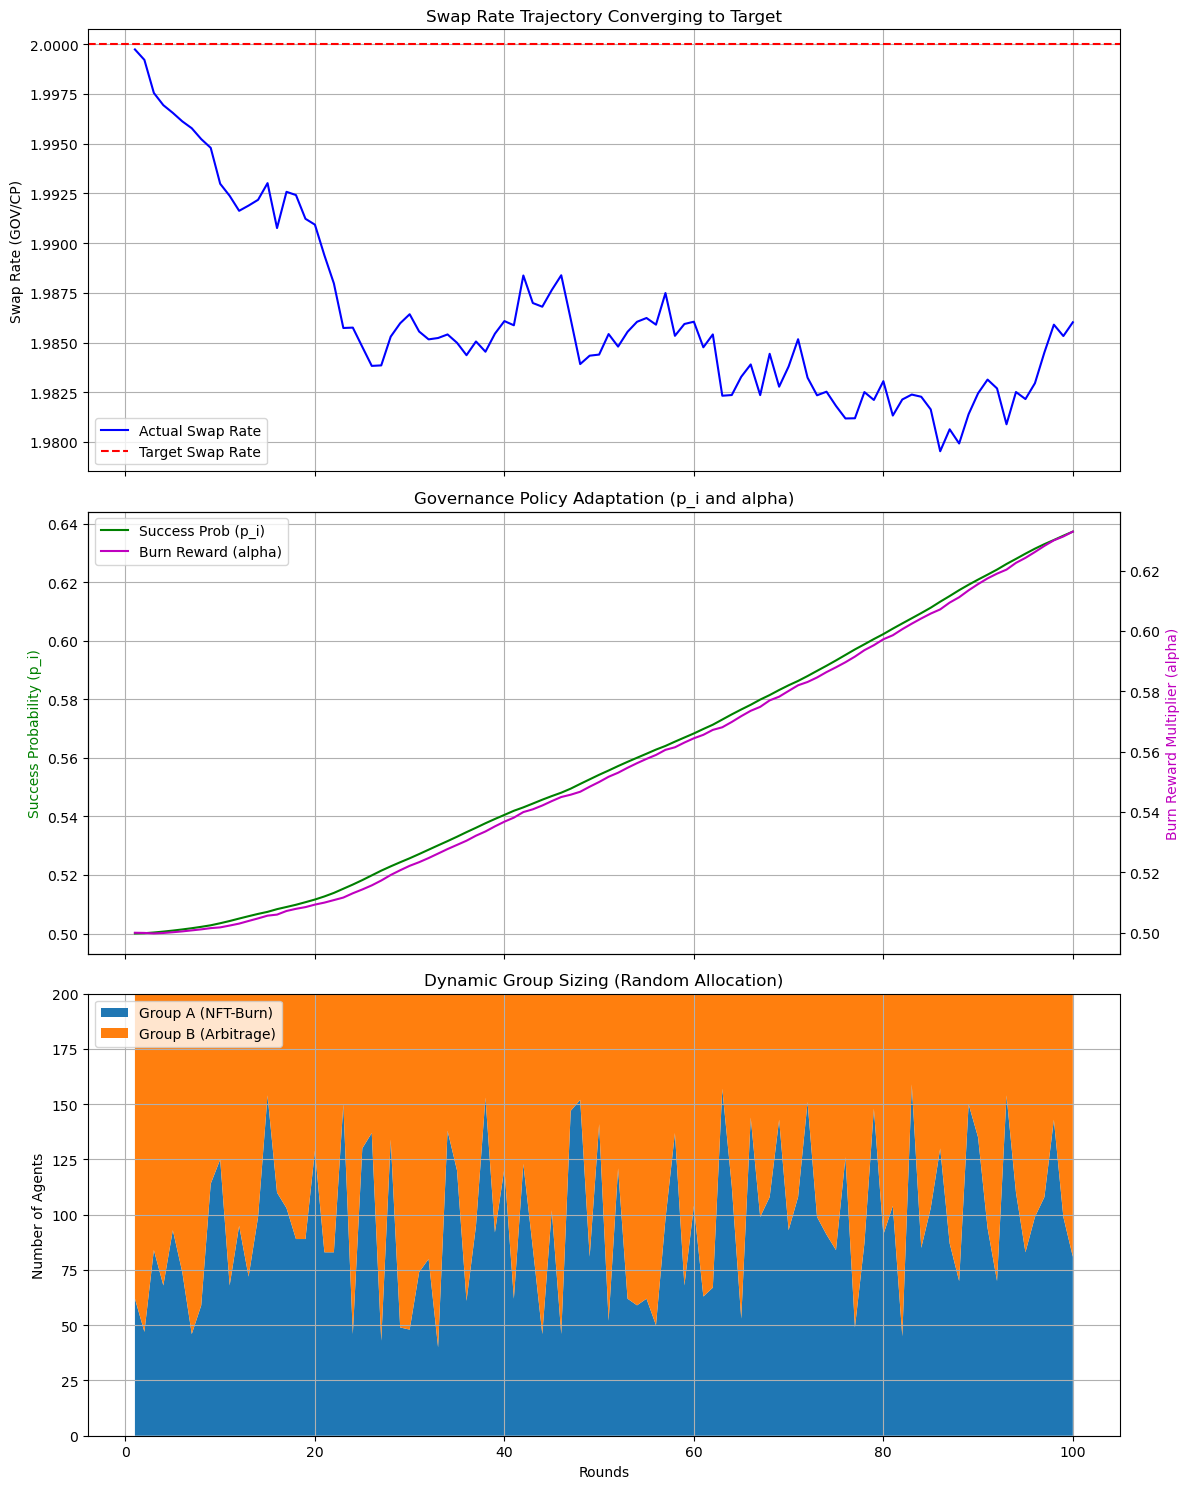

In [ ]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200

# AMM & Token Parameters
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE

# NFT & Reward Parameters
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2

# Governance & Agent Behavior Parameters
ETA_P = 0.1
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
    
    def get_k(self):
        return self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool
    
    def get_cp_pool_amount(self):
        return self.cp_pool
    
    def get_gov_pool_amount(self):
        return self.gov_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def get_gov_out_for_cp_in(self, cp_in):
        """CP를 넣었을 때 받게 될 GOV 양을 미리 계산 (실제 스왑은 안 함)"""
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        return self.gov_pool - new_gov_pool
        
    def get_cp_out_for_gov_in(self, gov_in):
        """GOV를 넣었을 때 받게 될 CP 양을 미리 계산 (실제 스왑은 안 함)"""
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        return self.cp_pool - new_cp_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()], 'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha], 'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # --- Group A 행동: 기대 효용 + 기회비용 기반 행동 선택 ---
        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        # --- AMM 업데이트: 매칭 스왑 로직 (핵심 수정) ---
        
        # 1. Group A가 시장에 팔려는 총 CP 양 계산
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 2. Group B는 Group A가 판 만큼만 CP를 다시 사들임 (매칭)
        #cp_to_buy_by_b = cp_to_sell_by_a
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor

        # 3. 이 두 거래가 한 라운드 내에서 발생한다고 가정하고,
        #    순 효과(Net Effect)를 계산하여 AMM에 한 번만 반영
        
        # A가 CP를 팔아서 받는 GOV 양 (미리 계산)
        gov_out_for_a = self.amm.get_gov_out_for_cp_in(cp_to_sell_by_a)
        
        # B가 CP를 사기 위해 내야 하는 GOV 양 (단순화: 현재 가격 기준)
        # (더 정확하려면 역산이 필요하지만, 우선 단순화된 모델로 안정성 확보)
        gov_in_from_b = cp_to_buy_by_b * self.amm.get_swap_rate()

        # 순 변화량 계산
        net_cp_change = cp_to_sell_by_a - self.amm.get_cp_out_for_gov_in(gov_in_from_b)
        net_gov_change = gov_in_from_b - gov_out_for_a
        
        # 이 방식은 복잡하므로, 가장 직관적인 '순차 처리'로 구현합니다.
        # 1. 판매자가 먼저 시장에 충격을 줌
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        # 2. 구매자가 그 충격이 반영된 시장에서 CP를 사들임
        #    (사려는 양은 A가 판 양과 같음)
        #    이 CP를 사기 위해 얼마의 GOV를 내야 하는지 현재 가격으로 계산
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)

        # 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)
        
    def get_pool_info(self):
        return {
            'cp_pool': self.amm.get_cp_pool_amount(),
            'gov_pool': self.amm.get_gov_pool_amount(),
            'swap_rate': self.amm.get_swap_rate()
        }


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)'); axs[0].legend(); axs[0].grid(True)
    
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0); axs[1].grid(True)
    
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds'); axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left'); axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    print(simulation.get_pool_info())
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 20 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 30 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 40 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 50 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 60 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 70 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 80 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 90 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 100 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 110 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 120 completed. Current Swap Rate: 2.00, p_i: 0.51, alpha: 0.51
Round 130 completed. Current Swap Rate: 2.00, p_i: 0.51, alpha: 0.51
Round 140 completed. Current Swap Rate: 2.00, p_i: 0.51, alpha: 0.51
Round 150 completed.

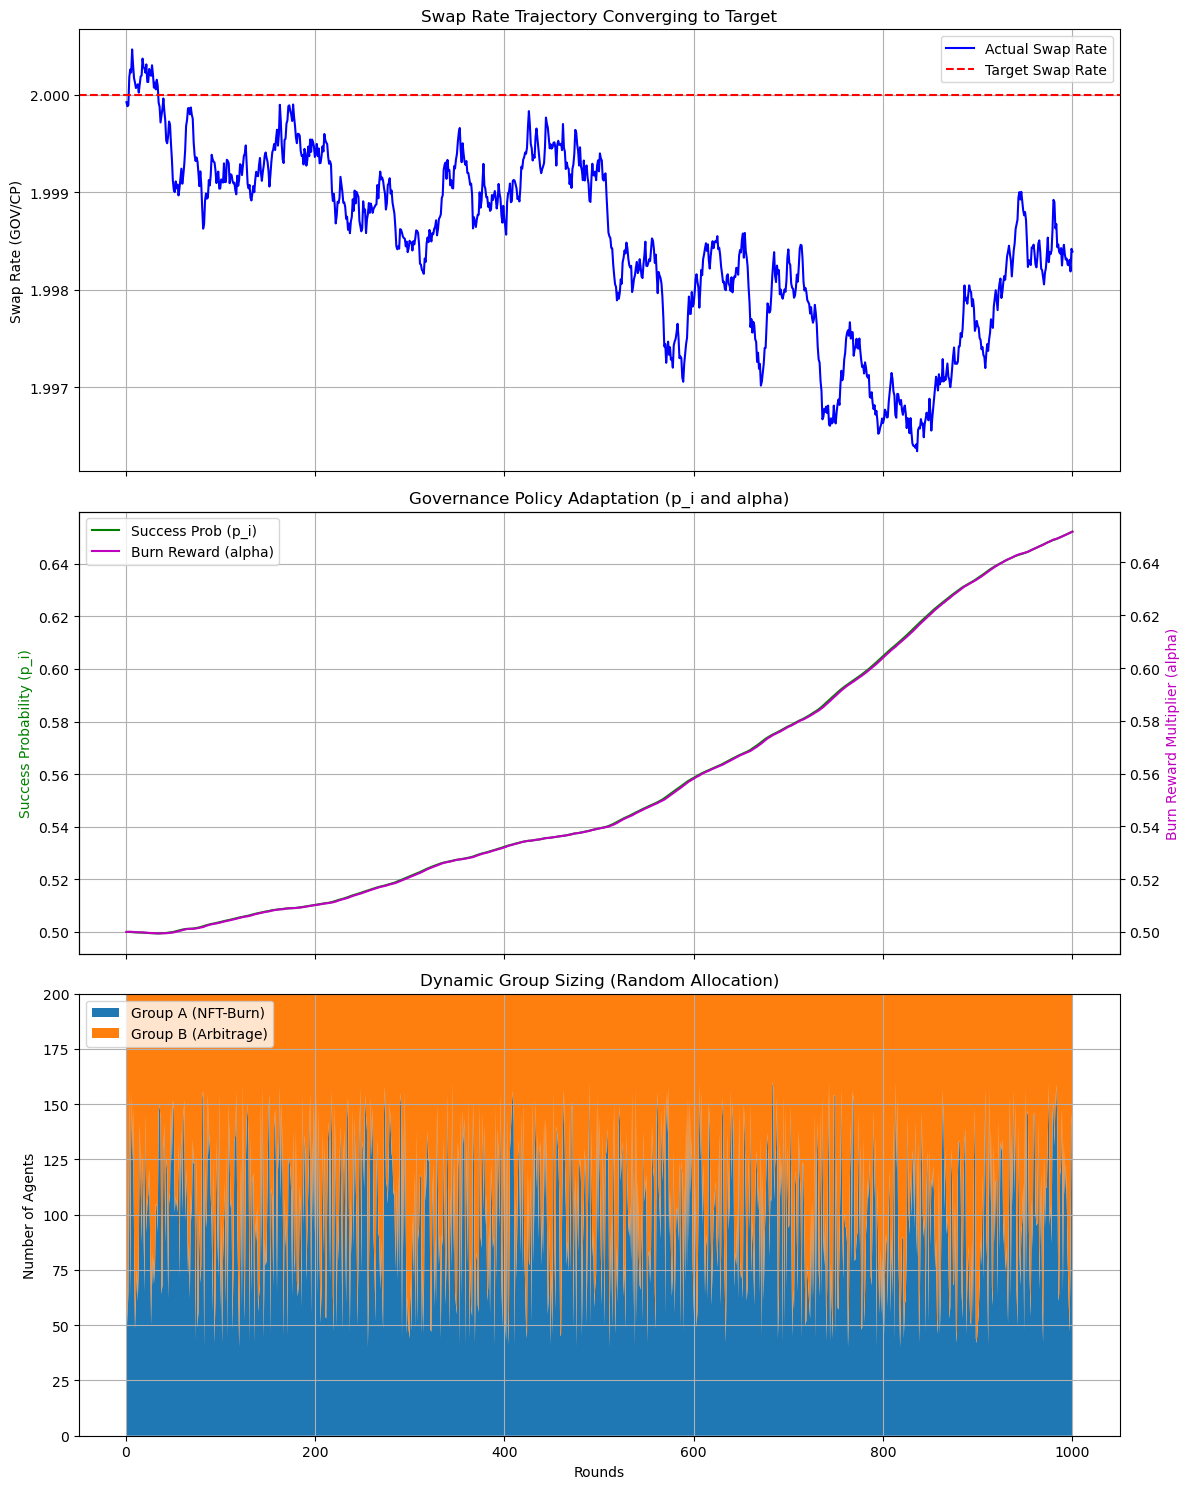

In [95]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200

# AMM & Token Parameters
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE

# NFT & Reward Parameters
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2

# Governance & Agent Behavior Parameters
ETA_P = 0.1
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
    
    def get_k(self):
        return self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool
    
    def get_cp_pool_amount(self):
        return self.cp_pool
    
    def get_gov_pool_amount(self):
        return self.gov_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def get_gov_out_for_cp_in(self, cp_in):
        """CP를 넣었을 때 받게 될 GOV 양을 미리 계산 (실제 스왑은 안 함)"""
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        return self.gov_pool - new_gov_pool
        
    def get_cp_out_for_gov_in(self, gov_in):
        """GOV를 넣었을 때 받게 될 CP 양을 미리 계산 (실제 스왑은 안 함)"""
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        return self.cp_pool - new_cp_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()], 'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha], 'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # --- Group A 행동: 기대 효용 + 기회비용 기반 행동 선택 ---
        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        # --- AMM 업데이트: 매칭 스왑 로직 (핵심 수정) ---
        
        # 1. Group A가 시장에 팔려는 총 CP 양 계산
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 2. Group B는 Group A가 판 만큼만 CP를 다시 사들임 (매칭)
        #cp_to_buy_by_b = cp_to_sell_by_a
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor

        # 3. 이 두 거래가 한 라운드 내에서 발생한다고 가정하고,
        #    순 효과(Net Effect)를 계산하여 AMM에 한 번만 반영
        
        # A가 CP를 팔아서 받는 GOV 양 (미리 계산)
        gov_out_for_a = self.amm.get_gov_out_for_cp_in(cp_to_sell_by_a)
        
        # B가 CP를 사기 위해 내야 하는 GOV 양 (단순화: 현재 가격 기준)
        # (더 정확하려면 역산이 필요하지만, 우선 단순화된 모델로 안정성 확보)
        gov_in_from_b = cp_to_buy_by_b * self.amm.get_swap_rate()

        # 순 변화량 계산
        net_cp_change = cp_to_sell_by_a - self.amm.get_cp_out_for_gov_in(gov_in_from_b)
        net_gov_change = gov_in_from_b - gov_out_for_a
        
        # 이 방식은 복잡하므로, 가장 직관적인 '순차 처리'로 구현합니다.
        # 1. 판매자가 먼저 시장에 충격을 줌
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        # 2. 구매자가 그 충격이 반영된 시장에서 CP를 사들임
        #    (사려는 양은 A가 판 양과 같음)
        #    이 CP를 사기 위해 얼마의 GOV를 내야 하는지 현재 가격으로 계산
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)

        # 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)
        
    def get_pool_info(self):
        return {
            'cp_pool': self.amm.get_cp_pool_amount(),
            'gov_pool': self.amm.get_gov_pool_amount(),
            'swap_rate': self.amm.get_swap_rate()
        }


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)'); axs[0].legend(); axs[0].grid(True)
    
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0); axs[1].grid(True)
    
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds'); axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left'); axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    print(simulation.get_pool_info())
    plot_results(simulation.history)

Starting simulation...
Round 10 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 20 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 30 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 40 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 50 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.50
Round 60 completed. Current Swap Rate: 2.00, p_i: 0.50, alpha: 0.49
Round 70 completed. Current Swap Rate: 2.00, p_i: 0.49, alpha: 0.49
Round 80 completed. Current Swap Rate: 2.00, p_i: 0.49, alpha: 0.49
Round 90 completed. Current Swap Rate: 2.00, p_i: 0.49, alpha: 0.49
Round 100 completed. Current Swap Rate: 2.00, p_i: 0.49, alpha: 0.49
Simulation finished. Plotting results...


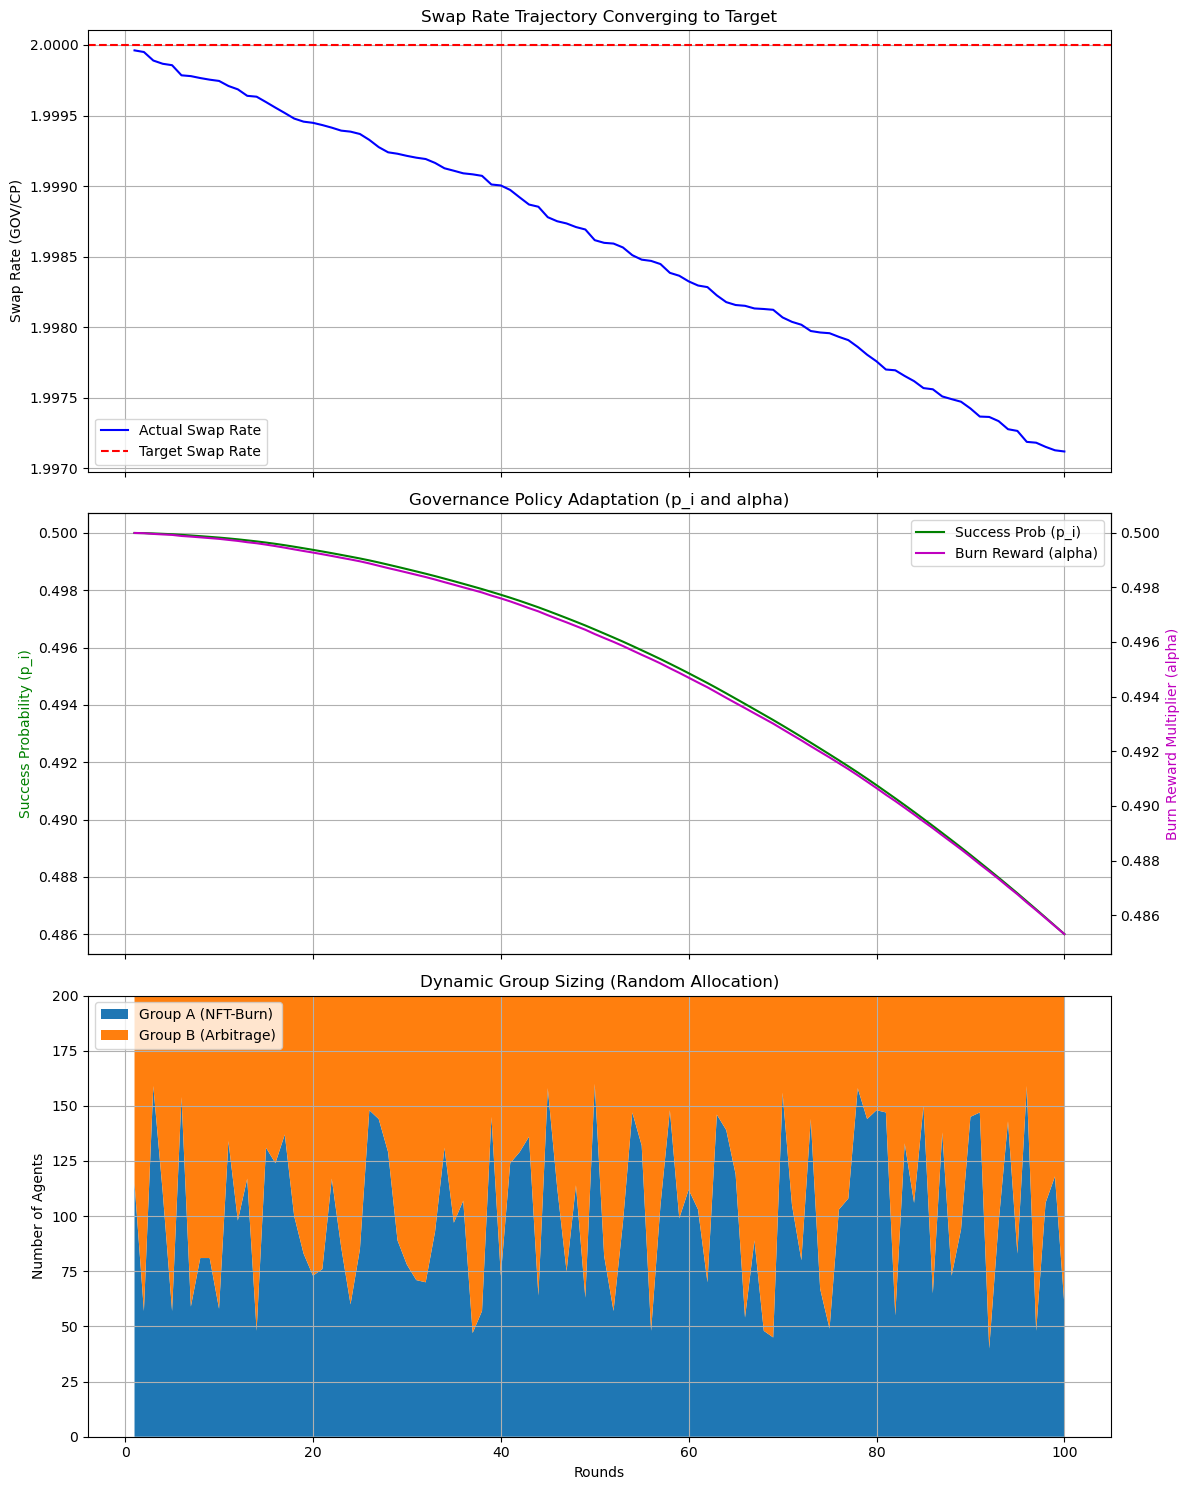

In [105]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200

# AMM & Token Parameters
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE

# NFT & Reward Parameters
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2

# Governance & Agent Behavior Parameters
ETA_P = 0.1
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
    
    def get_k(self):
        return self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def get_gov_out_for_cp_in(self, cp_in):
        """CP를 넣었을 때 받게 될 GOV 양을 미리 계산 (실제 스왑은 안 함)"""
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        return self.gov_pool - new_gov_pool
        
    def get_cp_out_for_gov_in(self, gov_in):
        """GOV를 넣었을 때 받게 될 CP 양을 미리 계산 (실제 스왑은 안 함)"""
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        return self.cp_pool - new_cp_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i + ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

class Simulation:
    def __init__(self):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()], 'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha], 'group_a_size': [], 'group_b_size': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        # --- Group A 행동: 기대 효용 + 기회비용 기반 행동 선택 ---
        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        # --- AMM 업데이트: 매칭 스왑 로직 (핵심 수정) ---
        
        # 1. Group A가 시장에 팔려는 총 CP 양 계산
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # 2. Group B는 Group A가 판 만큼만 CP를 다시 사들임 (매칭)
        cp_to_buy_by_b = cp_to_sell_by_a

        # 3. 이 두 거래가 한 라운드 내에서 발생한다고 가정하고,
        #    순 효과(Net Effect)를 계산하여 AMM에 한 번만 반영
        
        # A가 CP를 팔아서 받는 GOV 양 (미리 계산)
        gov_out_for_a = self.amm.get_gov_out_for_cp_in(cp_to_sell_by_a)
        
        # B가 CP를 사기 위해 내야 하는 GOV 양 (단순화: 현재 가격 기준)
        # (더 정확하려면 역산이 필요하지만, 우선 단순화된 모델로 안정성 확보)
        gov_in_from_b = cp_to_buy_by_b * self.amm.get_swap_rate()

        # 순 변화량 계산
        net_cp_change = cp_to_sell_by_a - self.amm.get_cp_out_for_gov_in(gov_in_from_b)
        net_gov_change = gov_in_from_b - gov_out_for_a
        
        # 이 방식은 복잡하므로, 가장 직관적인 '순차 처리'로 구현합니다.
        # 1. 판매자가 먼저 시장에 충격을 줌
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        # 2. 구매자가 그 충격이 반영된 시장에서 CP를 사들임
        #    (사려는 양은 A가 판 양과 같음)
        #    이 CP를 사기 위해 얼마의 GOV를 내야 하는지 현재 가격으로 계산
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)

        # 거버넌스 정책 피드백
        current_swap_rate = self.amm.get_swap_rate()
        self.governance.update_policy(current_swap_rate)
        
        # 기록
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)


def plot_results(history):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    actual_swap_rates = history['swap_rate'][1:]
    p_i_history = history['p_i'][1:]
    alpha_history = history['alpha'][1:]
    
    axs[0].plot(rounds, actual_swap_rates, 'b-', label='Actual Swap Rate', linewidth=1.5)
    axs[0].axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    axs[0].set_title('Swap Rate Trajectory Converging to Target')
    axs[0].set_ylabel('Swap Rate (GOV/CP)'); axs[0].legend(); axs[0].grid(True)
    
    ax2 = axs[1].twinx()
    axs[1].plot(rounds, p_i_history, 'g-', label='Success Prob (p_i)')
    ax2.plot(rounds, alpha_history, 'm-', label='Burn Reward (alpha)')
    axs[1].set_ylabel('Success Probability (p_i)', color='g')
    ax2.set_ylabel('Burn Reward Multiplier (alpha)', color='m')
    axs[1].set_title('Governance Policy Adaptation (p_i and alpha)')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0); axs[1].grid(True)
    
    axs[2].stackplot(rounds, [history['group_a_size'], history['group_b_size']], 
                     labels=['Group A (NFT-Burn)', 'Group B (Arbitrage)'], 
                     colors=['#1f77b4', '#ff7f0e'])
    axs[2].set_title('Dynamic Group Sizing (Random Allocation)')
    axs[2].set_xlabel('Rounds'); axs[2].set_ylabel('Number of Agents')
    axs[2].legend(loc='upper left'); axs[2].grid(True); axs[2].set_ylim(0, SAMPLE_SIZE)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    simulation = Simulation()
    print("Starting simulation...")
    for i in range(1, SIMULATION_ROUNDS + 1):
        simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i} completed. Current Swap Rate: {simulation.history['swap_rate'][-1]:.2f}, p_i: {simulation.governance.p_i:.2f}, alpha: {simulation.governance.alpha:.2f}")
    print("Simulation finished. Plotting results...")
    
    plot_results(simulation.history)

--- Running Simulation: WITH Governance Policy ---
Round 10: Swap Rate = 2.00
Round 20: Swap Rate = 2.00
Round 30: Swap Rate = 2.00
Round 40: Swap Rate = 2.00
Round 50: Swap Rate = 2.00
Round 60: Swap Rate = 2.00
Round 70: Swap Rate = 2.00
Round 80: Swap Rate = 2.00
Round 90: Swap Rate = 2.00
Round 100: Swap Rate = 2.00
Round 110: Swap Rate = 2.00
Round 120: Swap Rate = 2.00
Round 130: Swap Rate = 2.00
Round 140: Swap Rate = 2.00
Round 150: Swap Rate = 2.00
Round 160: Swap Rate = 2.00
Round 170: Swap Rate = 2.00
Round 180: Swap Rate = 2.00
Round 190: Swap Rate = 2.00
Round 200: Swap Rate = 2.00
Round 210: Swap Rate = 2.00
Round 220: Swap Rate = 2.00
Round 230: Swap Rate = 2.00
Round 240: Swap Rate = 2.00
Round 250: Swap Rate = 2.00
Round 260: Swap Rate = 2.00
Round 270: Swap Rate = 2.00
Round 280: Swap Rate = 2.00
Round 290: Swap Rate = 2.00
Round 300: Swap Rate = 2.00
Round 310: Swap Rate = 2.00
Round 320: Swap Rate = 2.00
Round 330: Swap Rate = 2.00
Round 340: Swap Rate = 2.00
Round 

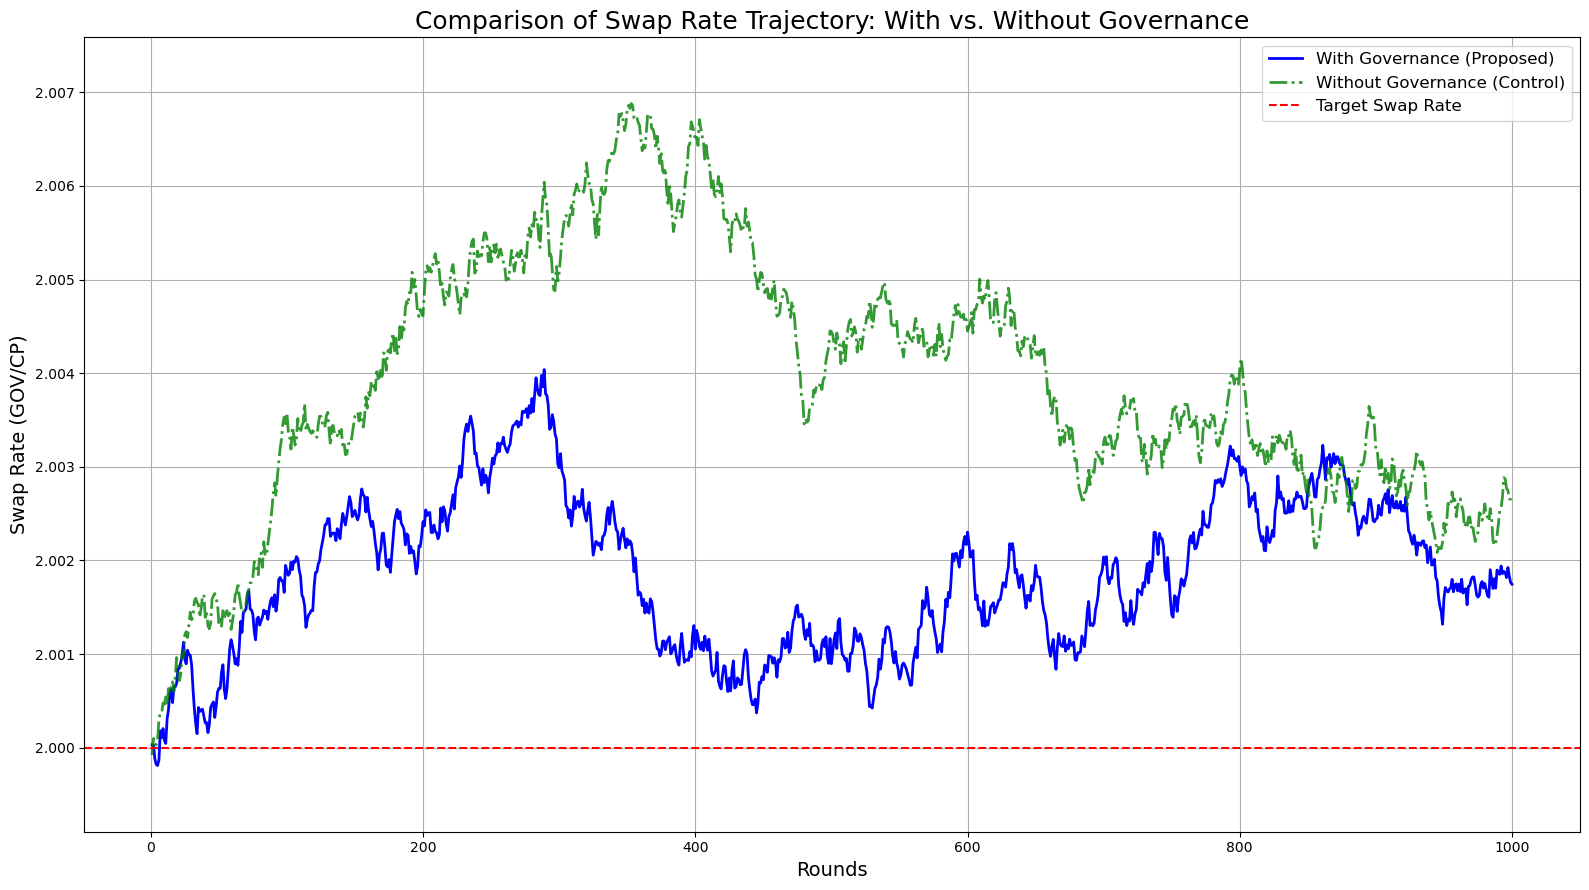

In [107]:
import random
import matplotlib.pyplot as plt
import math

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2
ETA_P = 0.1
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
    
    def get_k(self):
        return self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def get_gov_out_for_cp_in(self, cp_in):
        """CP를 넣었을 때 받게 될 GOV 양을 미리 계산 (실제 스왑은 안 함)"""
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        return self.gov_pool - new_gov_pool
        
    def get_cp_out_for_gov_in(self, gov_in):
        """GOV를 넣었을 때 받게 될 CP 양을 미리 계산 (실제 스왑은 안 함)"""
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        return self.cp_pool - new_cp_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i + ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I


# --- 3. Simulation 클래스 수정 ---
class Simulation:
    def __init__(self, use_governance=True): # <<<<<<< 1. 플래그 추가
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance()
        self.use_governance = use_governance # <<<<<<< 1. 플래그 저장
        self.history = {
            'swap_rate': [self.amm.get_swap_rate()], 'p_i': [self.governance.p_i],
            'alpha': [self.governance.alpha], 'group_a_size': [], 'group_b_size': [],
            'attempts': []
        }

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a
        self.history['group_a_size'].append(num_group_a)
        self.history['group_b_size'].append(num_group_b)

        failures_a = 0
        attempts_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                attempts_a += 1
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        self.history['attempts'].append(attempts_a)
                
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        # '불완전한 시장'을 위한 노이즈 추가
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        # <<<<<<< 2. 정책 적용 여부 결정
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)
        self.history['p_i'].append(self.governance.p_i)
        self.history['alpha'].append(self.governance.alpha)


# --- 4. Plotting 함수 수정 (ylim 설정) ---
def plot_comparison_results(exp_history, ctrl_history):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9)) # 그래프 크기 조정
    rounds = range(1, SIMULATION_ROUNDS + 1)
    
    exp_rates = exp_history['swap_rate'][1:]
    ctrl_rates = ctrl_history['swap_rate'][1:]
    
    ax.plot(rounds, exp_rates, 'b-', label='With Governance (Proposed)', linewidth=2)
    ax.plot(rounds, ctrl_rates, 'g-.', label='Without Governance (Control)', linewidth=2, alpha=0.8)
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
    
    ax.set_title('Comparison of Swap Rate Trajectory: With vs. Without Governance', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    
    # <<<<<<< 핵심 수정: Y축 범위를 수동으로 지정하여 확대
    # 모든 데이터의 최소/최대값을 찾아 동적으로 범위를 설정
    all_rates = exp_rates + ctrl_rates
    min_rate = min(all_rates)
    max_rate = max(all_rates)
    # y축에 약간의 여유 공간(padding)을 줌
    padding = (max_rate - min_rate) * 0.1
    ax.set_ylim(min_rate - padding, max_rate + padding)
    
    ax.legend(fontsize=12); ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 ---
if __name__ == '__main__':
    # 실험군 실행 (거버넌스 ON)
    print("--- Running Simulation: WITH Governance Policy ---")
    exp_simulation = Simulation(use_governance=True)
    for i in range(1, SIMULATION_ROUNDS + 1):
        exp_simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i}: Swap Rate = {exp_simulation.history['swap_rate'][-1]:.2f}")

    # 비교군 실행 (거버넌스 OFF)
    print("\n--- Running Simulation: WITHOUT Governance Policy ---")
    ctrl_simulation = Simulation(use_governance=False)
    for i in range(1, SIMULATION_ROUNDS + 1):
        ctrl_simulation.run_round(i)
        if i % 10 == 0:
            print(f"Round {i}: Swap Rate = {ctrl_simulation.history['swap_rate'][-1]:.2f}")

    print("\nSimulation finished. Plotting comparison results...")
    # 수정된 플롯 함수 호출
    plot_comparison_results(exp_simulation.history, ctrl_simulation.history)

--- Starting 30 simulation runs for each scenario ---
Completed 5/30 runs...
Completed 10/30 runs...
Completed 15/30 runs...
Completed 20/30 runs...
Completed 25/30 runs...
Completed 30/30 runs...

All simulations finished. Plotting results with confidence intervals...


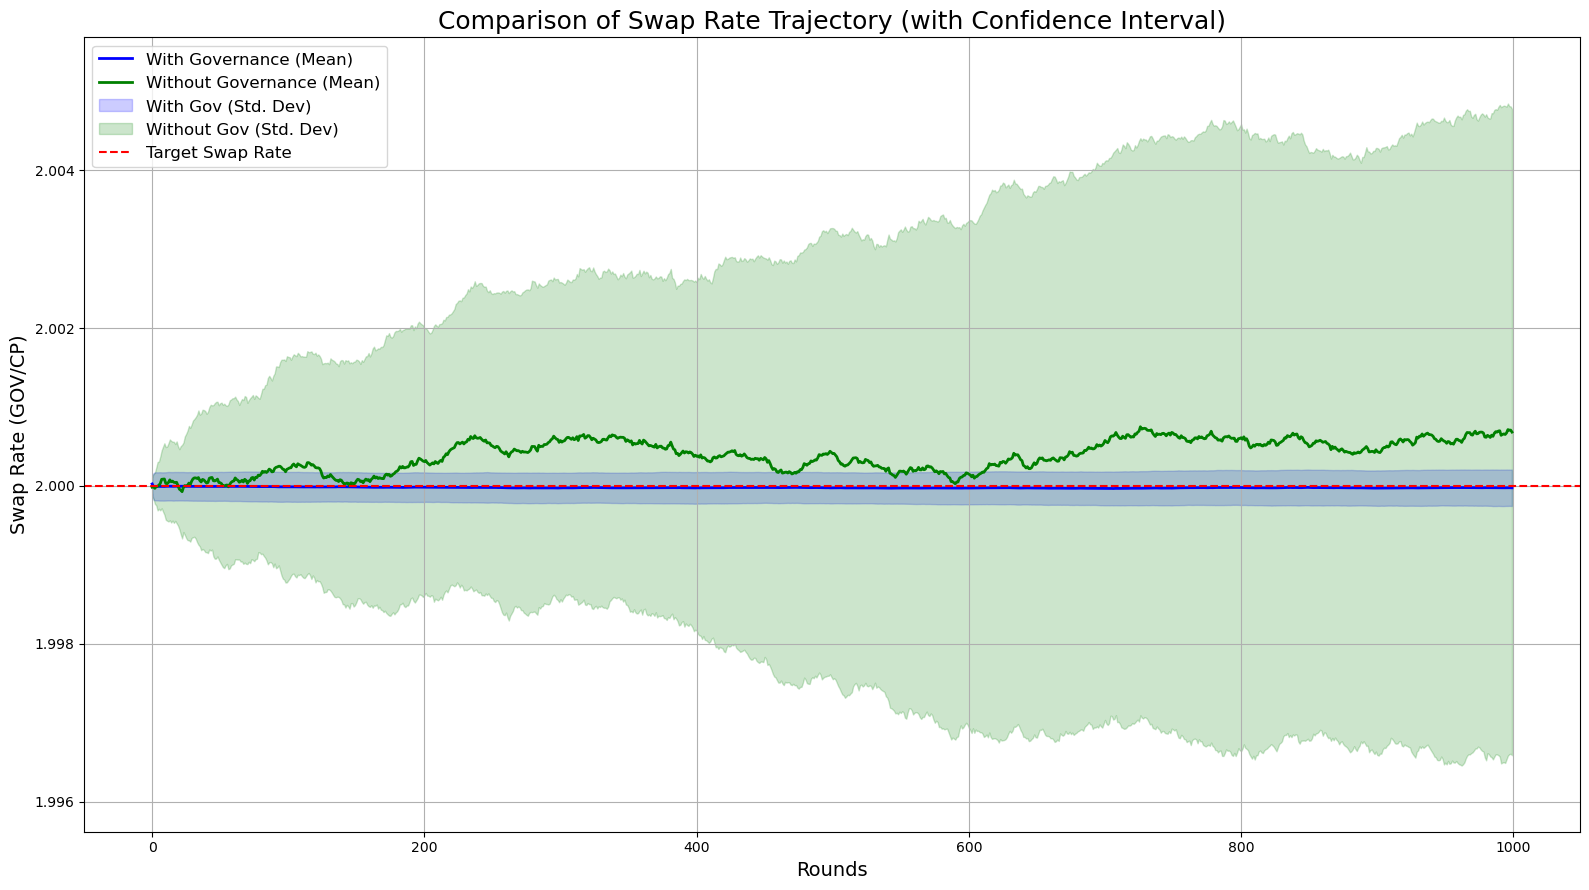

In [113]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 30           # <<<<<<< 각 시나리오를 몇 번 반복할지 결정
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2
ETA_P = 0.05 # 약간 낮춰서 더 안정적인 수렴을 유도
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
    
    def get_k(self):
        return self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def get_gov_out_for_cp_in(self, cp_in):
        """CP를 넣었을 때 받게 될 GOV 양을 미리 계산 (실제 스왑은 안 함)"""
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        return self.gov_pool - new_gov_pool
        
    def get_cp_out_for_gov_in(self, gov_in):
        """GOV를 넣었을 때 받게 될 CP 양을 미리 계산 (실제 스왑은 안 함)"""
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        return self.cp_pool - new_cp_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate + self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

# --- 3. Simulation 클래스 수정 (이전의 최종본과 거의 동일) ---
class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE) # 명시적 전달
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

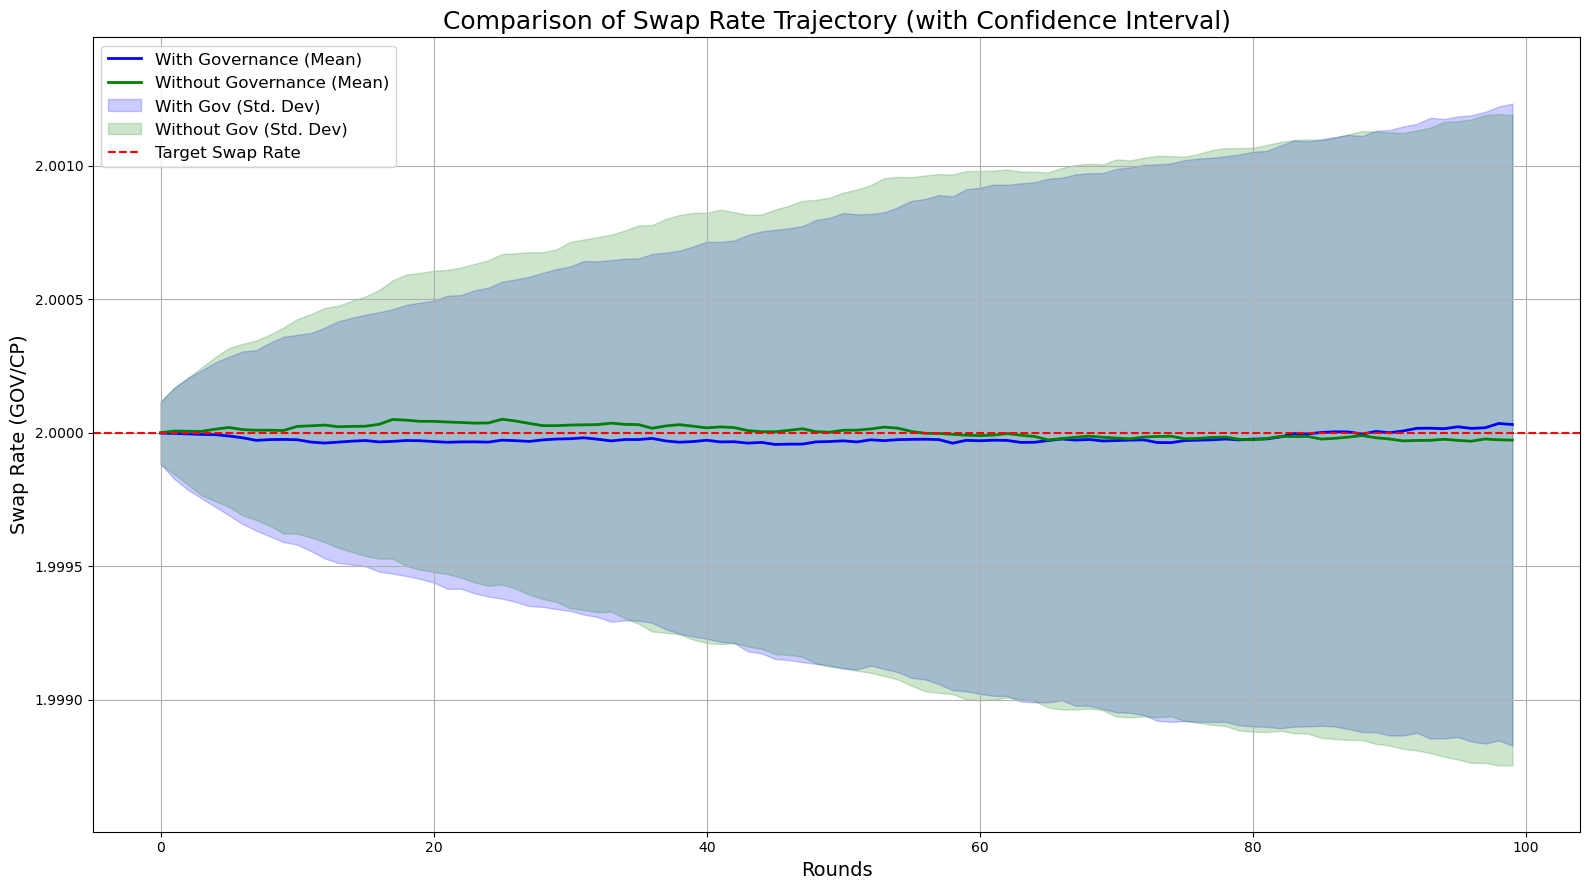

In [120]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500           # <<<<<<< 각 시나리오를 몇 번 반복할지 결정
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2
ETA_P = 0.05 # 약간 낮춰서 더 안정적인 수렴을 유도
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
    
    def get_k(self):
        return self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def get_gov_out_for_cp_in(self, cp_in):
        """CP를 넣었을 때 받게 될 GOV 양을 미리 계산 (실제 스왑은 안 함)"""
        if cp_in <= 0: return 0
        k = self.get_k()
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = k / new_cp_pool
        return self.gov_pool - new_gov_pool
        
    def get_cp_out_for_gov_in(self, gov_in):
        """GOV를 넣었을 때 받게 될 CP 양을 미리 계산 (실제 스왑은 안 함)"""
        if gov_in <= 0: return 0
        k = self.get_k()
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = k / new_gov_pool
        return self.cp_pool - new_cp_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i + ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

# --- 3. Simulation 클래스 수정 (이전의 최종본과 거의 동일) ---
class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE) # 명시적 전달
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

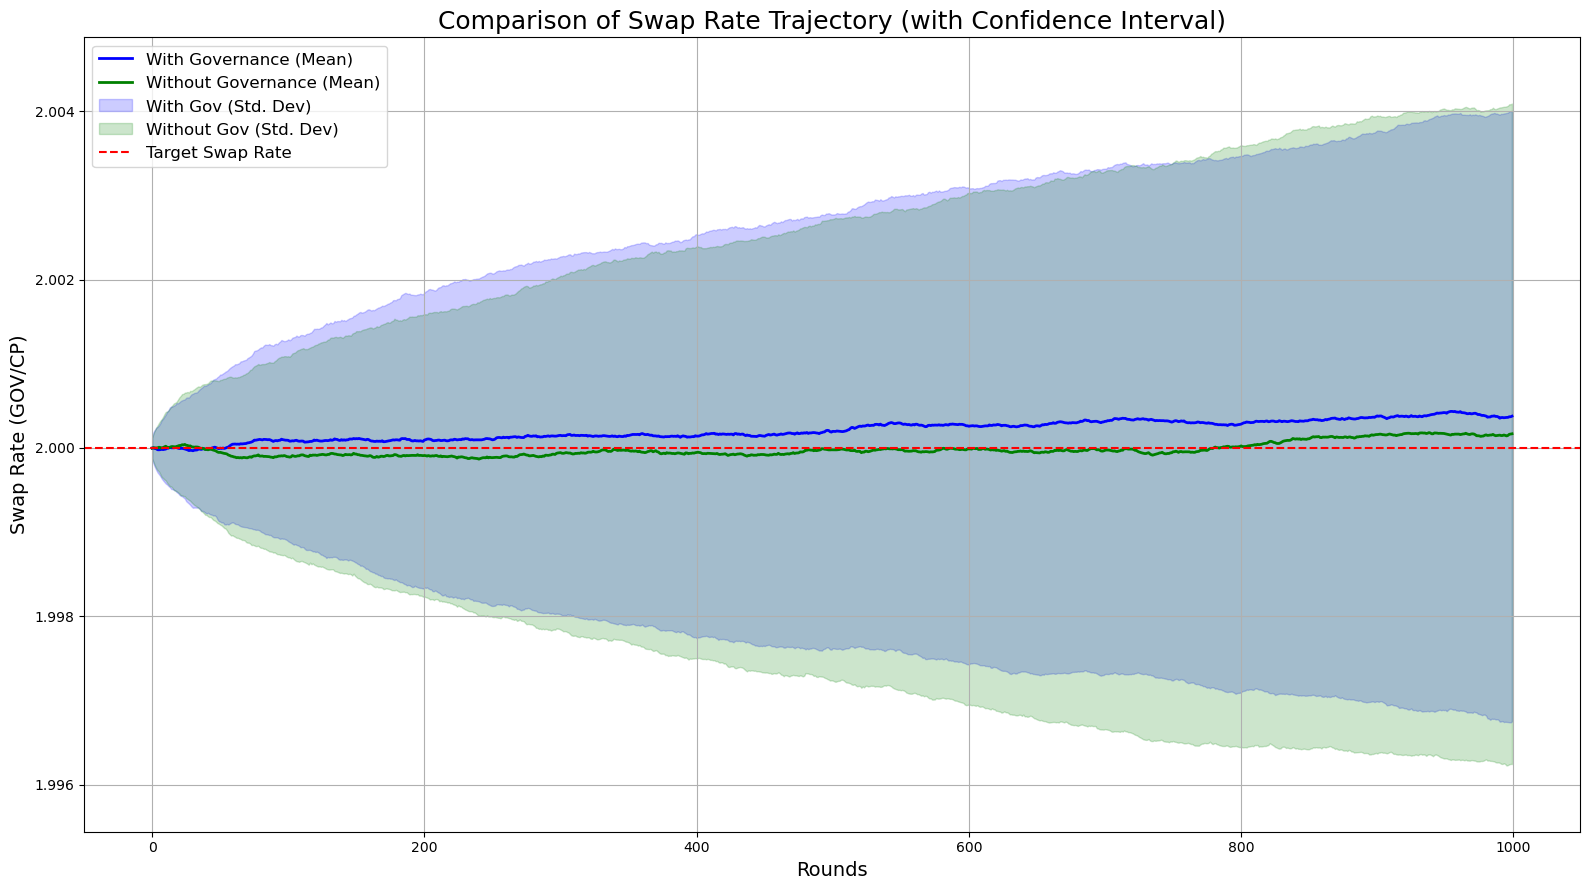

In [ ]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 10.0
RARITY_RATE = 1.2
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i + ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

# --- 3. Simulation 클래스 수정 (이전의 최종본과 거의 동일) ---
# --- 5. Simulation, plot_confidence_interval, main (수정 없음) ---
class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

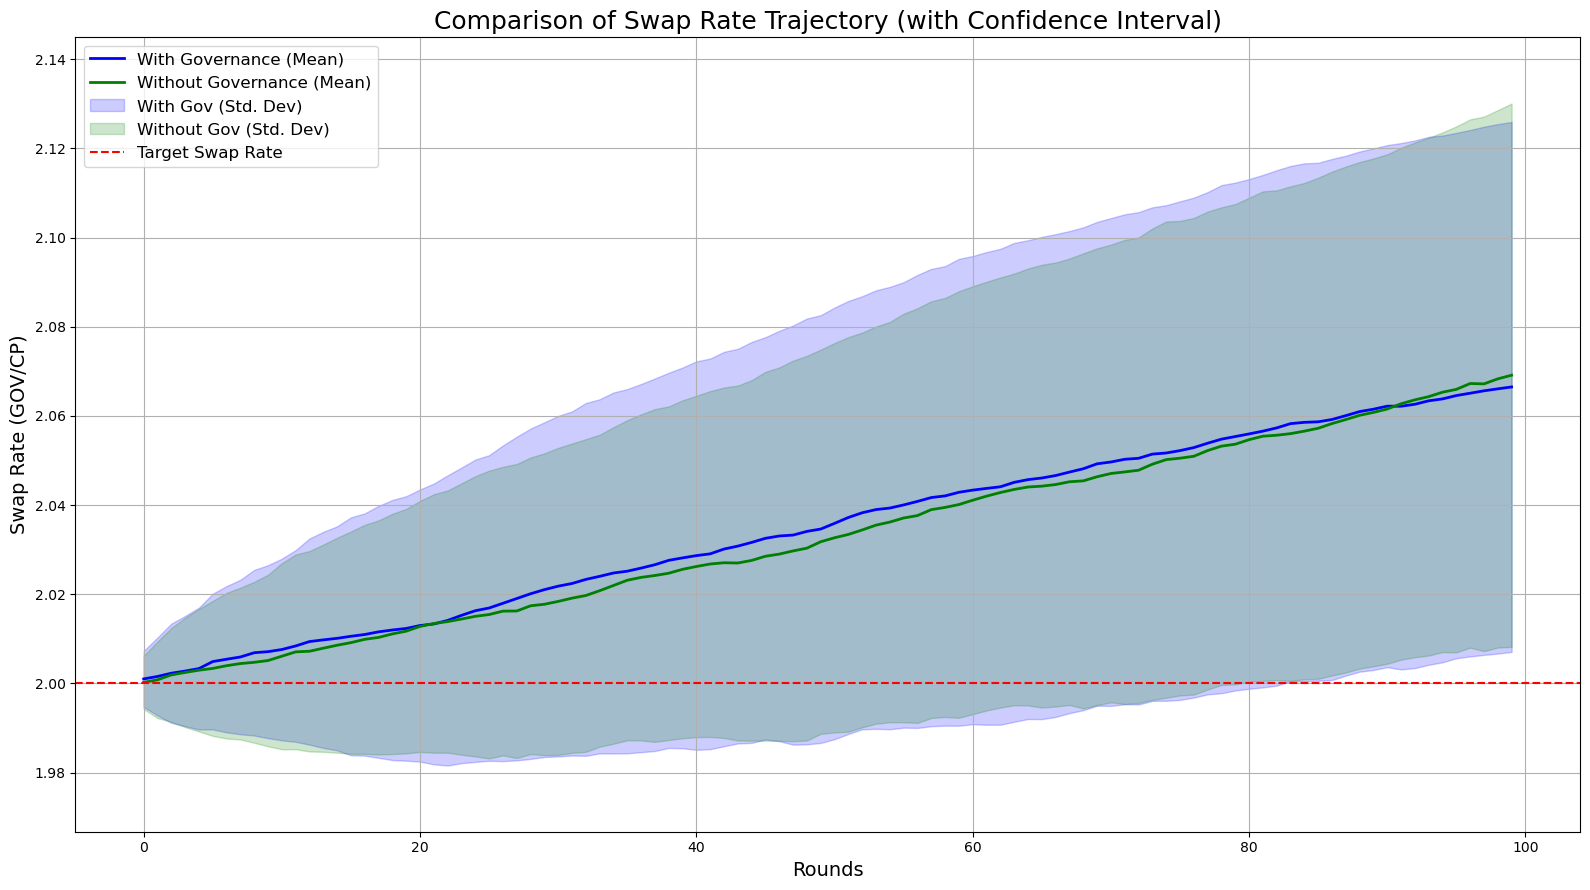

In [128]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 50.0
RARITY_RATE = 1.2
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

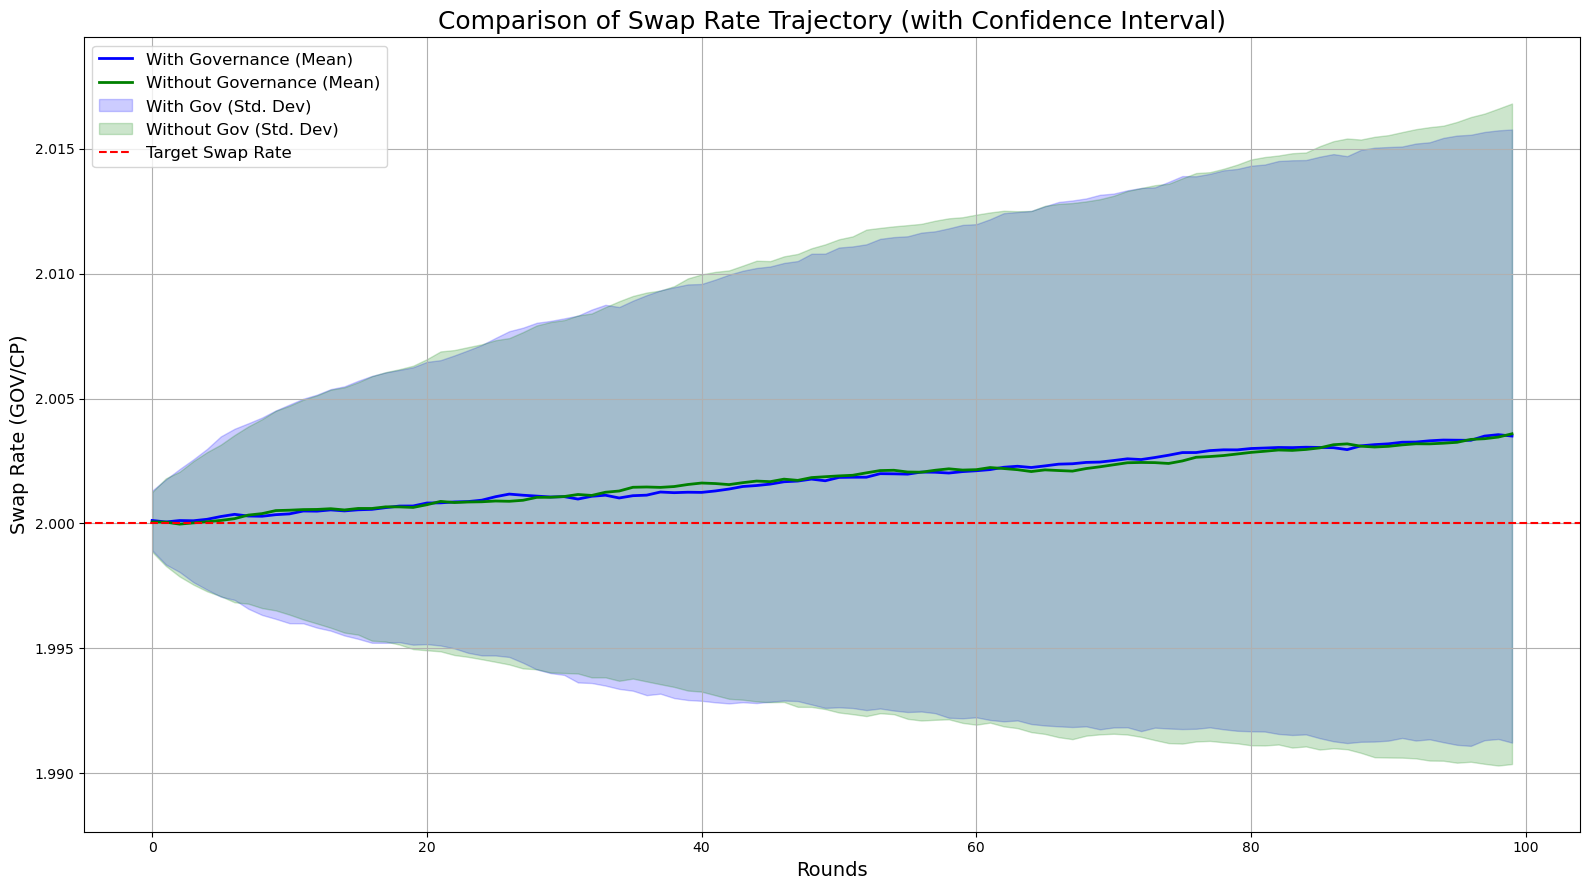

In [132]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 2.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

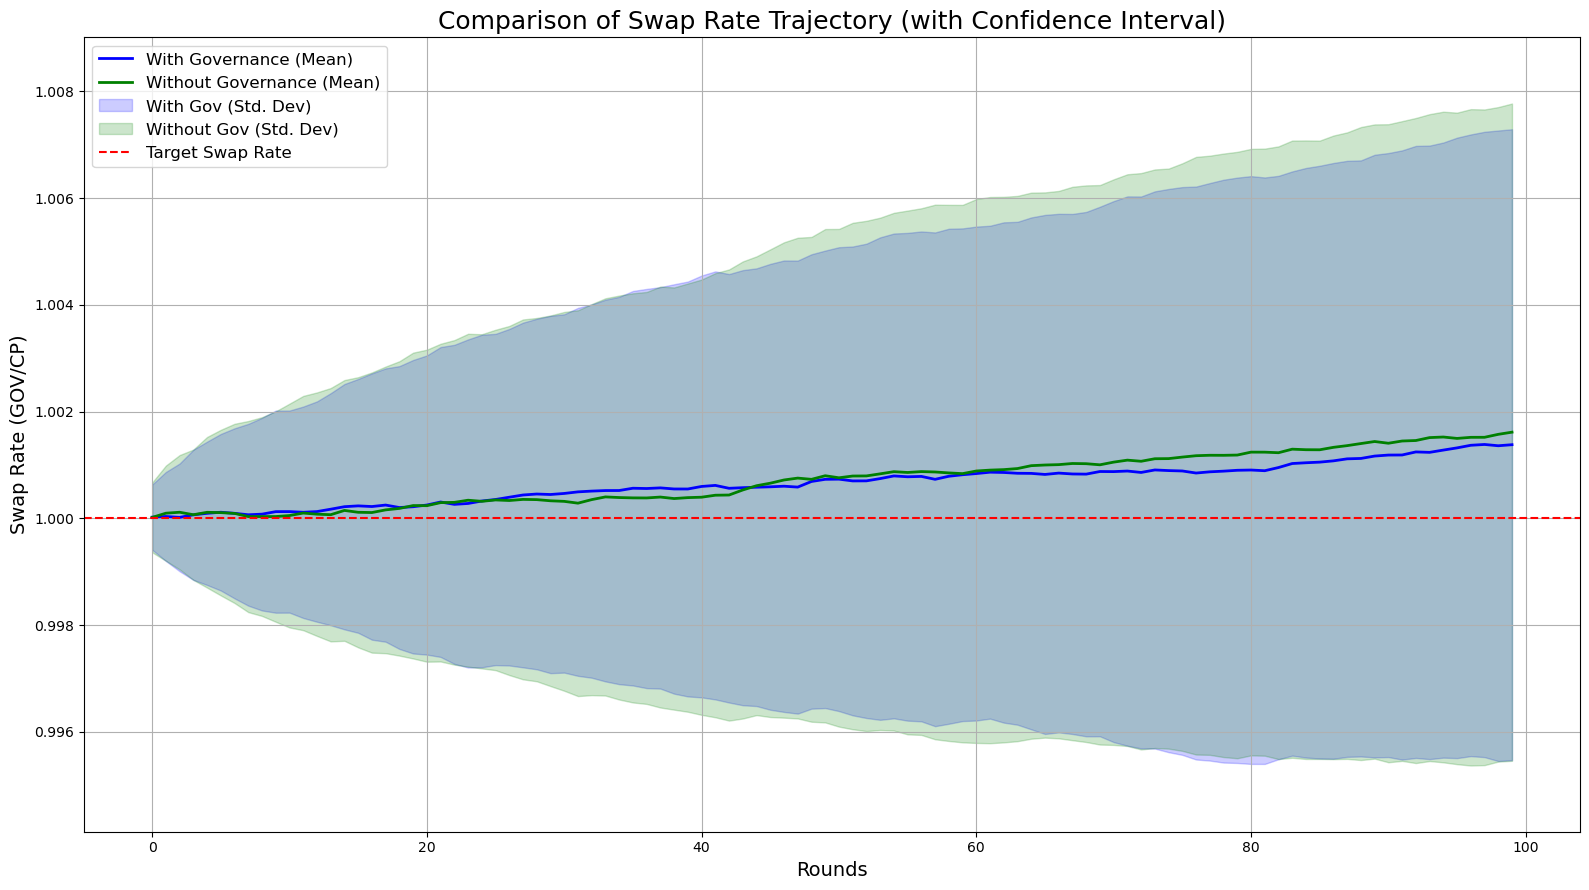

In [133]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 100
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

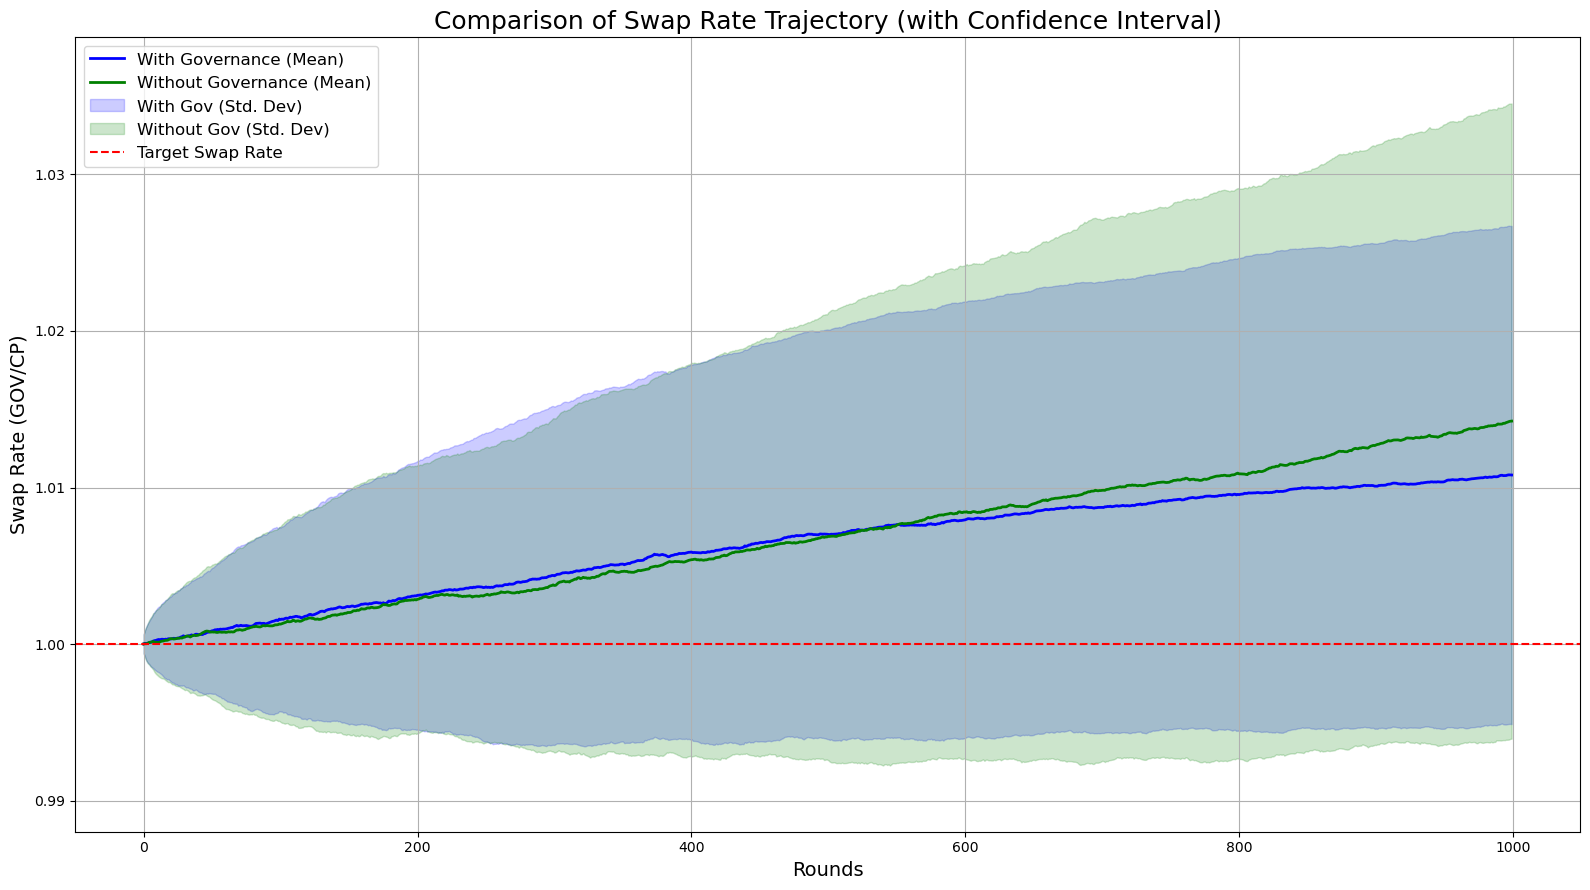

In [134]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

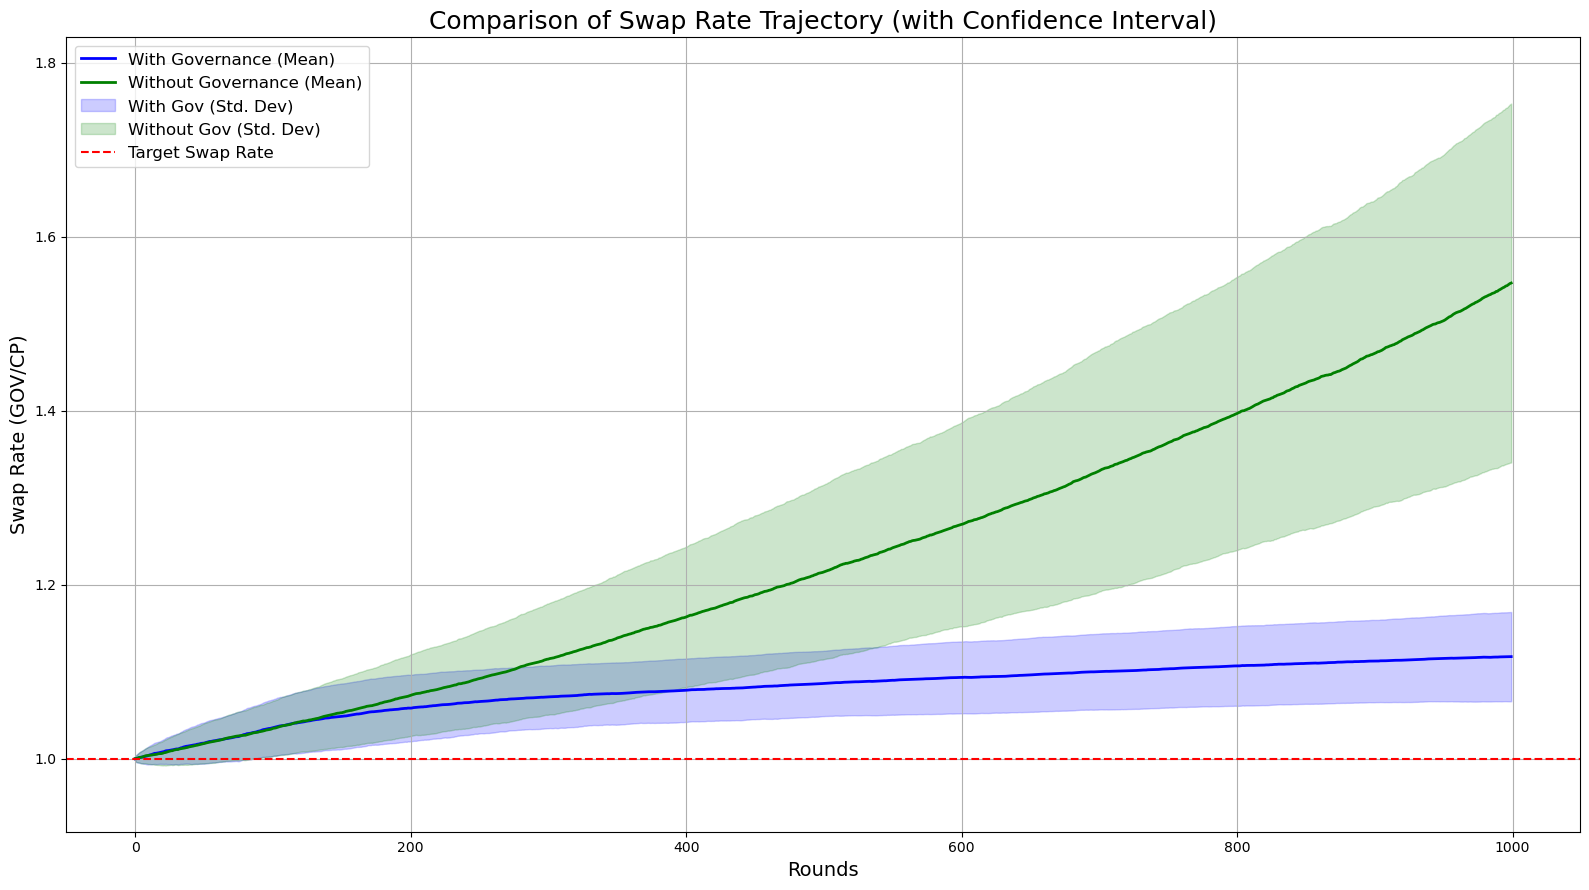

In [140]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 100000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 50.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

<>:157: SyntaxWarning: invalid escape sequence '\e'
<>:157: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_276822/3432305867.py:157: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title('Swap Rate Trajectory: Baseline Scenario ($\eta_p = 0.05$, Full Liquidity)', fontsize=18)


--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

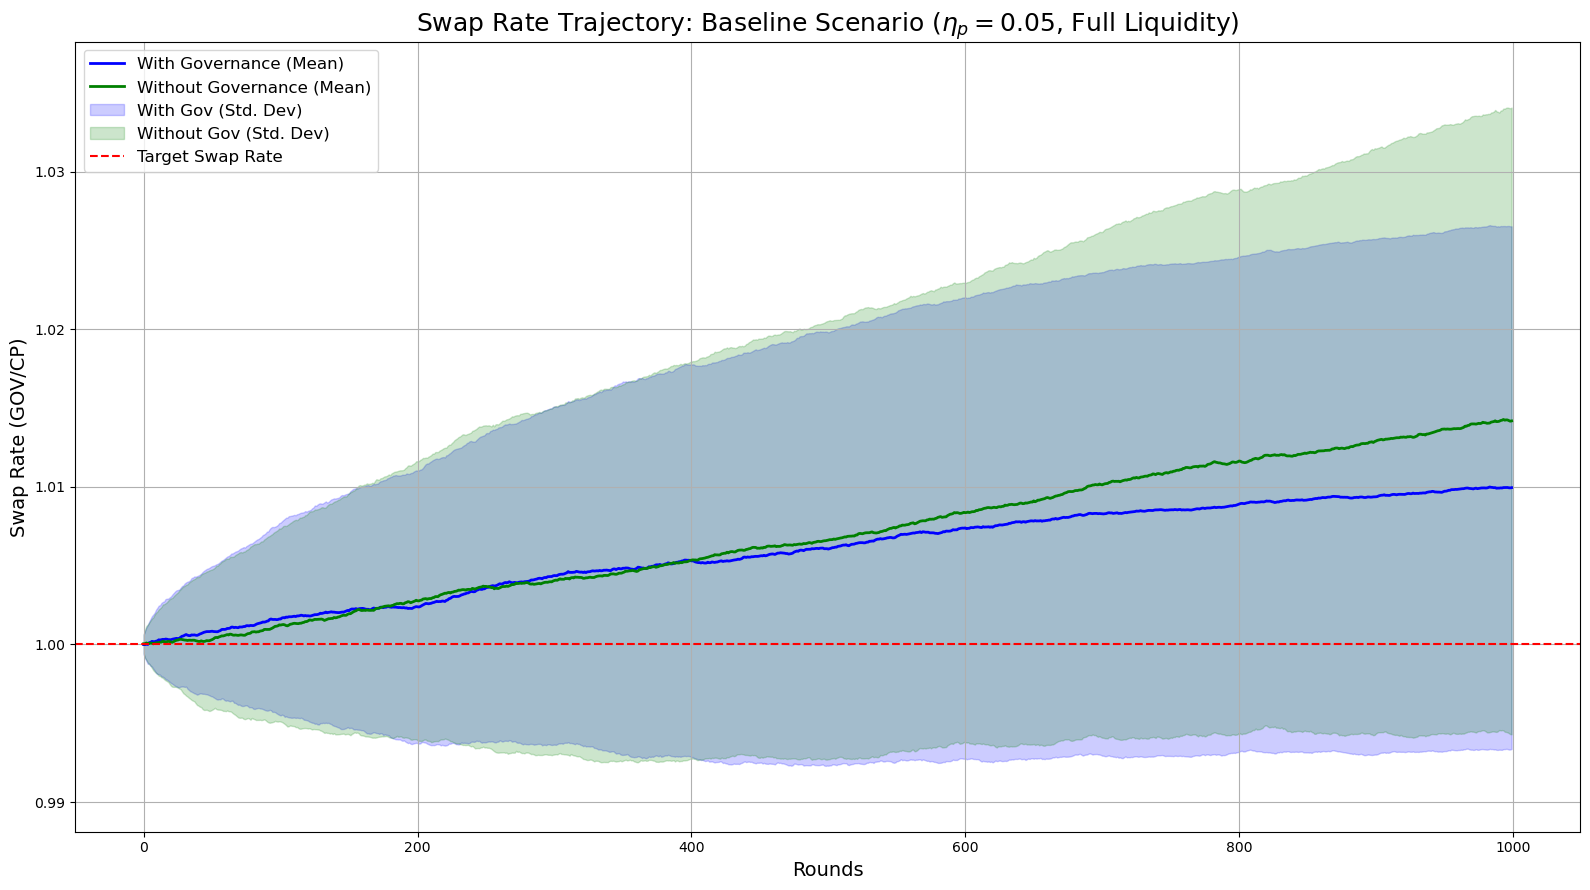

In [149]:
'''
Baseline
'''

import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Swap Rate Trajectory: Baseline Scenario ($\eta_p = 0.05$, Full Liquidity)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---


<>:158: SyntaxWarning: invalid escape sequence '\e'
<>:158: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_276822/1258559778.py:158: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title('Swap Rate Trajectory: High Policy Sensitivity ($\eta_p = 0.5$)', fontsize=18)


Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Completed 190/500 runs...
Completed 195/500 runs...
Comple

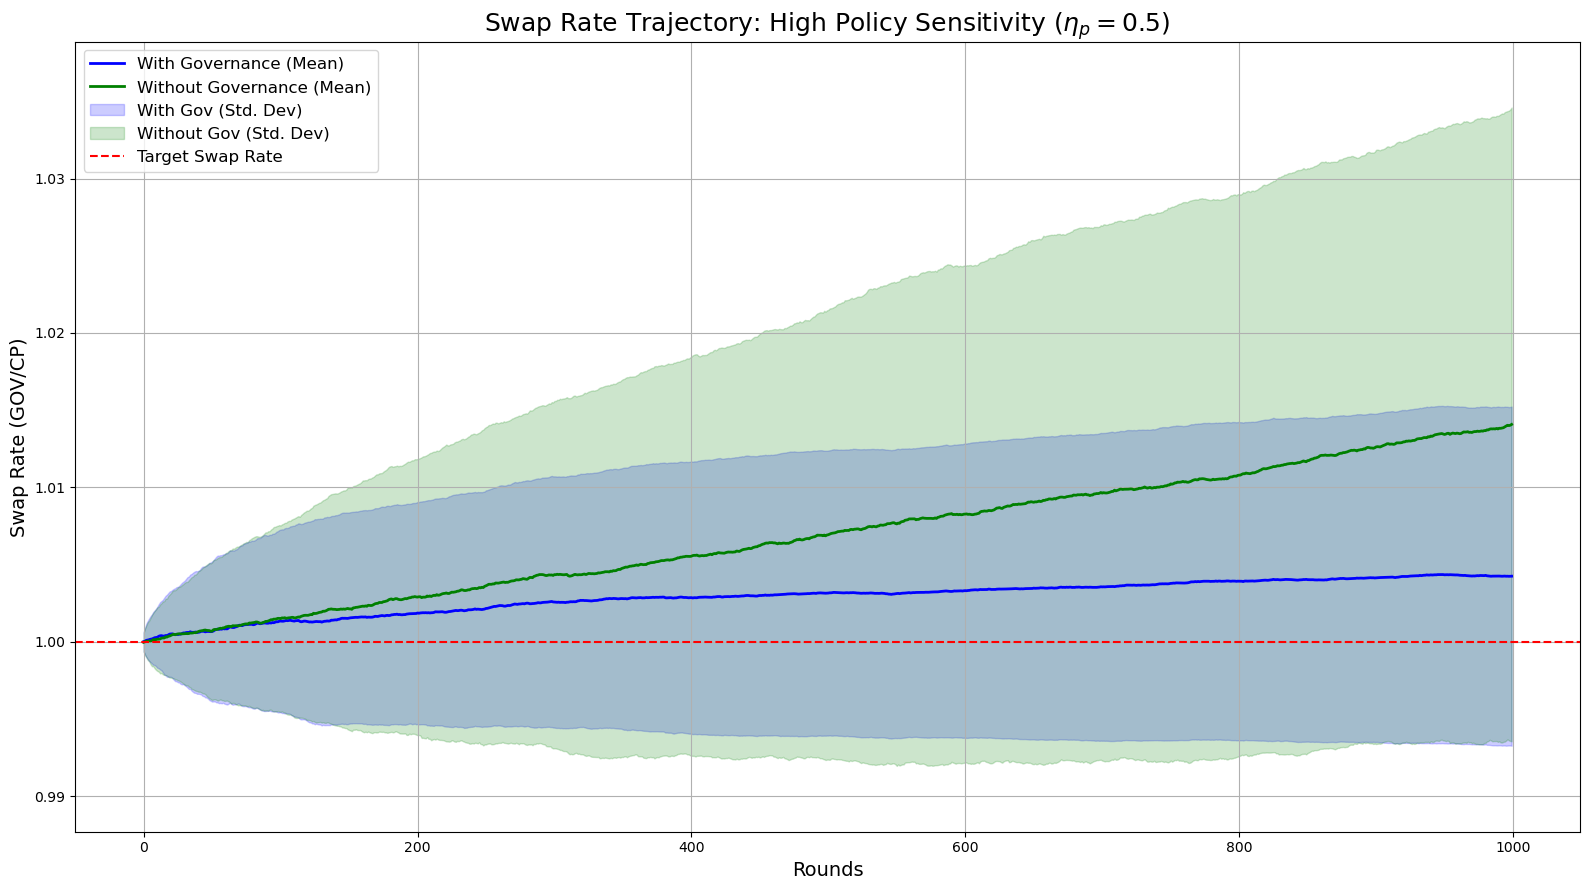

In [150]:
'''
ETA_P = 0.05 -> 0.5로 수정한 버전 (매우 빠르게 DAO 정책 반응)
'''


import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.5
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Swap Rate Trajectory: High Policy Sensitivity ($\eta_p = 0.5$)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

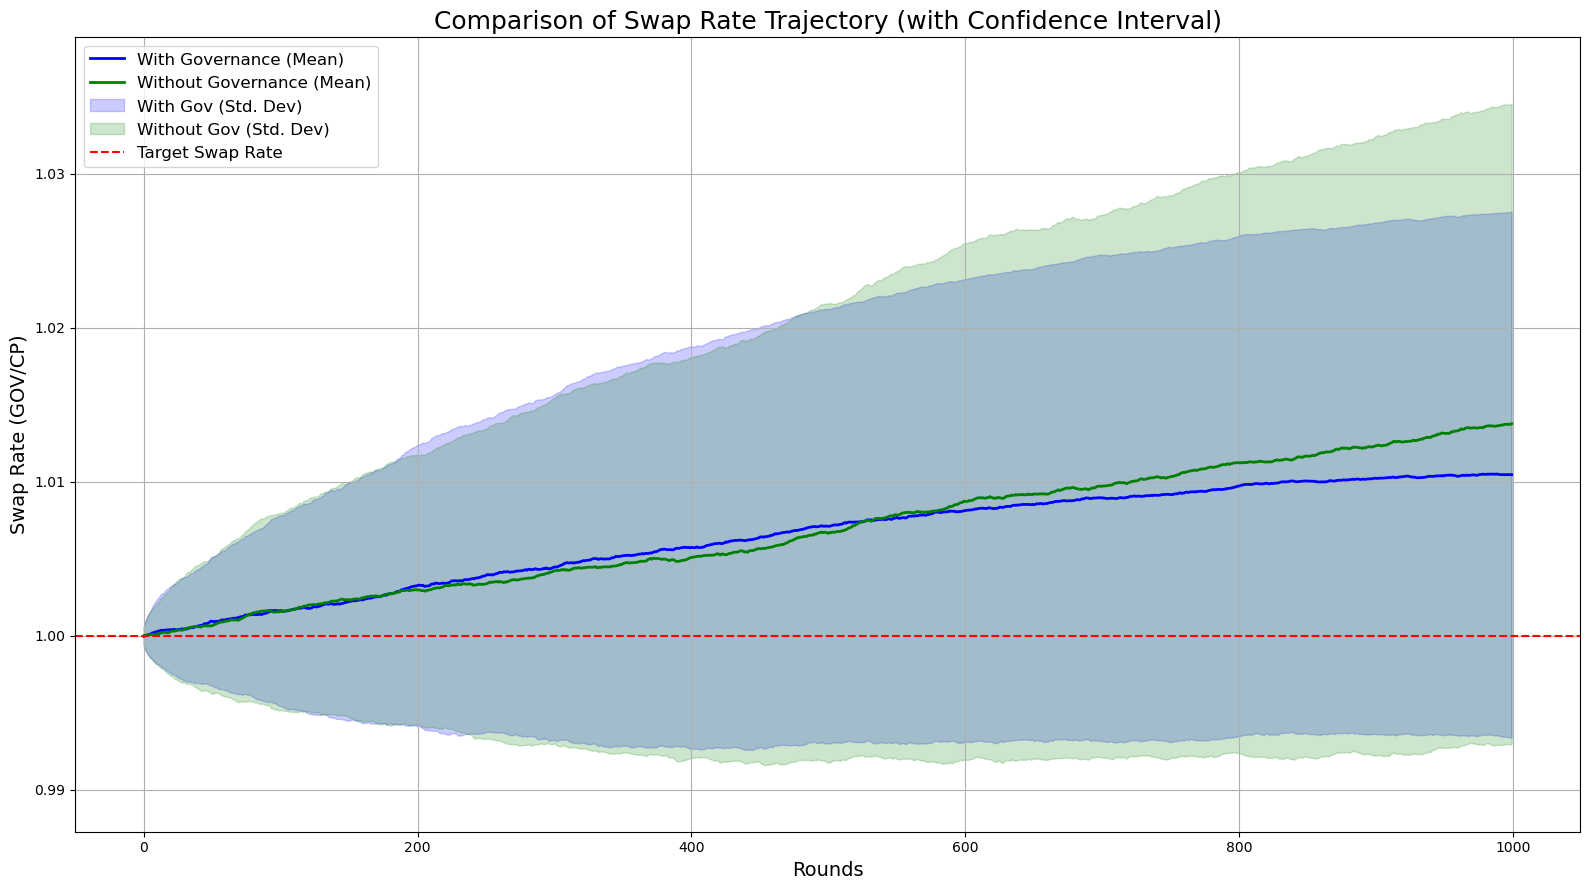

In [151]:
'''
BETA = 0.5 -> 5.0로 수정한 버전 (시도 확률을 더 높게 설정)
'''


import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

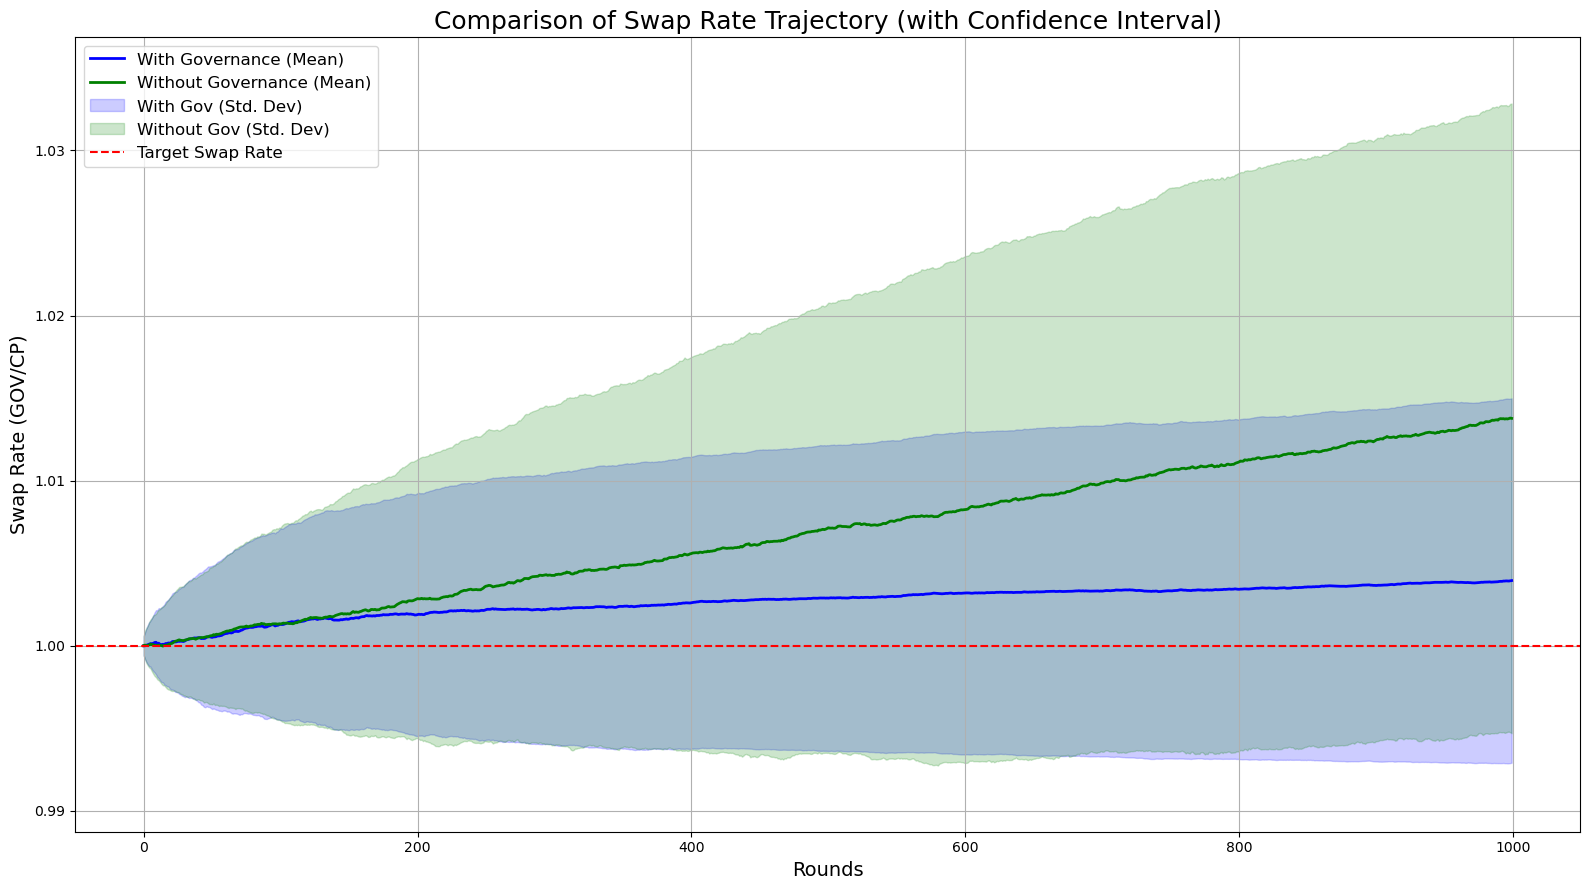

In [152]:
'''
ETA_P = 0.05 -> 0.5로 수정한 버전 (매우 빠르게 DAO 정책 반응)
BETA = 0.5 -> 5.0로 수정한 버전 (시도 확률을 더 높게 설정)

Results: Beta는 크게 영향을 주지 않는것 같음. ETA_P가 0.5로 높아지면 DAO 정책이 매우 빠르게 반응하여 스왑 비율이 안정화됨.
'''


import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.5
INFLATION_FACTOR_CAP = 2.0
BETA = 5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Comparison of Swap Rate Trajectory (with Confidence Interval)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---
Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Com

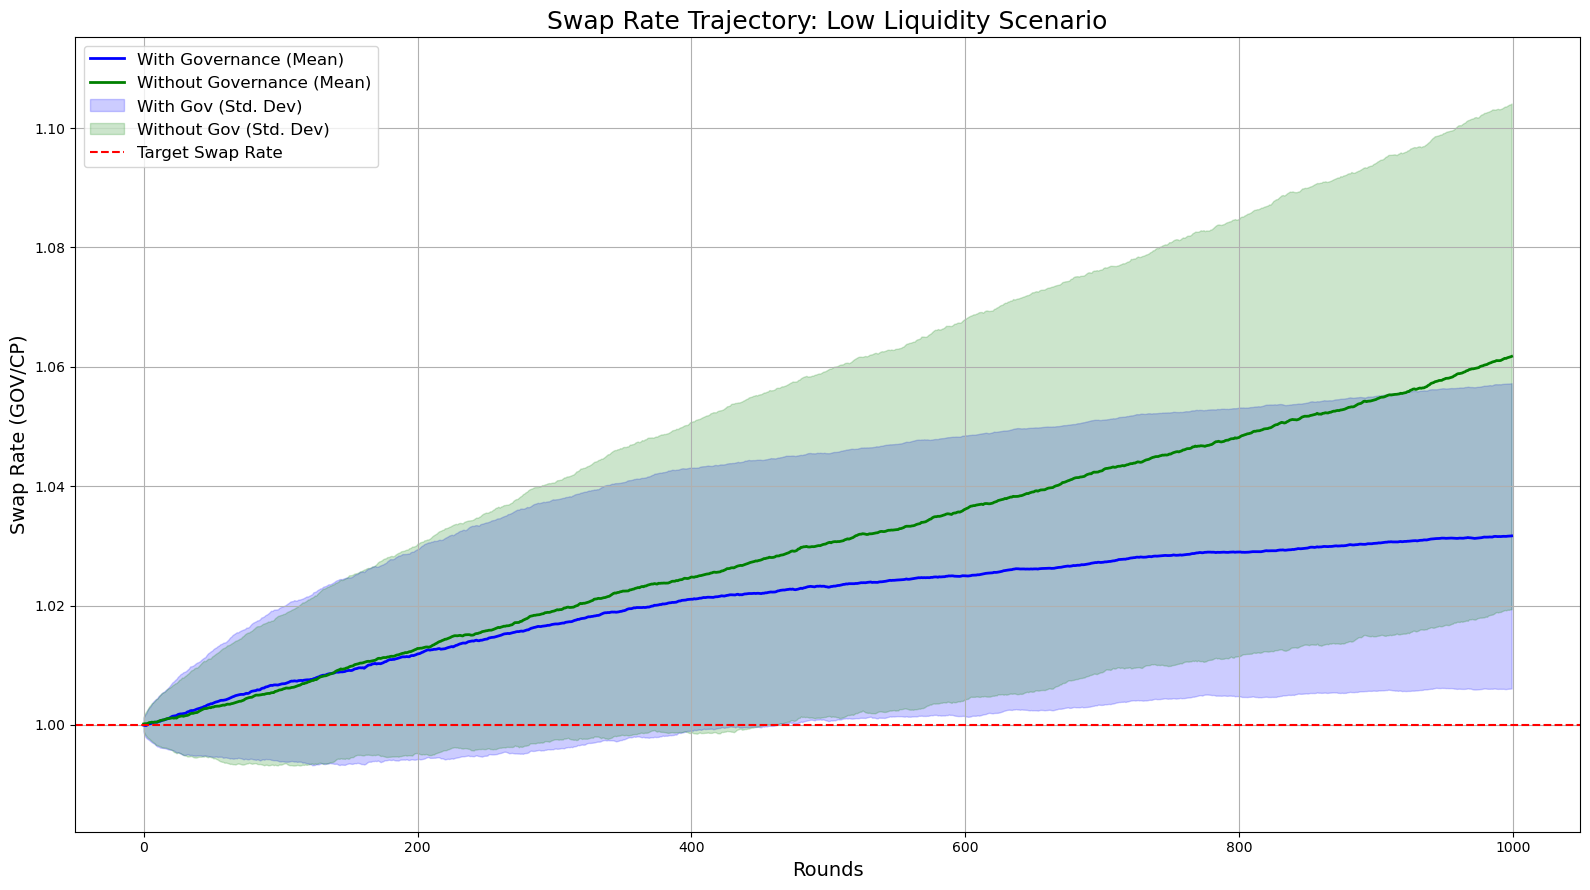

In [153]:
'''
유동성 = 1000000.0 -> 500000.0로 감소
'''


import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 500000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Swap Rate Trajectory: Low Liquidity Scenario', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

--- Starting 500 simulation runs for each scenario ---


<>:159: SyntaxWarning: invalid escape sequence '\e'
<>:159: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_276822/1803614244.py:159: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title('Swap Rate Trajectory: Combined Stress Test (Low Liquidity & $\eta_p = 0.5$)', fontsize=18)


Completed 5/500 runs...
Completed 10/500 runs...
Completed 15/500 runs...
Completed 20/500 runs...
Completed 25/500 runs...
Completed 30/500 runs...
Completed 35/500 runs...
Completed 40/500 runs...
Completed 45/500 runs...
Completed 50/500 runs...
Completed 55/500 runs...
Completed 60/500 runs...
Completed 65/500 runs...
Completed 70/500 runs...
Completed 75/500 runs...
Completed 80/500 runs...
Completed 85/500 runs...
Completed 90/500 runs...
Completed 95/500 runs...
Completed 100/500 runs...
Completed 105/500 runs...
Completed 110/500 runs...
Completed 115/500 runs...
Completed 120/500 runs...
Completed 125/500 runs...
Completed 130/500 runs...
Completed 135/500 runs...
Completed 140/500 runs...
Completed 145/500 runs...
Completed 150/500 runs...
Completed 155/500 runs...
Completed 160/500 runs...
Completed 165/500 runs...
Completed 170/500 runs...
Completed 175/500 runs...
Completed 180/500 runs...
Completed 185/500 runs...
Completed 190/500 runs...
Completed 195/500 runs...
Comple

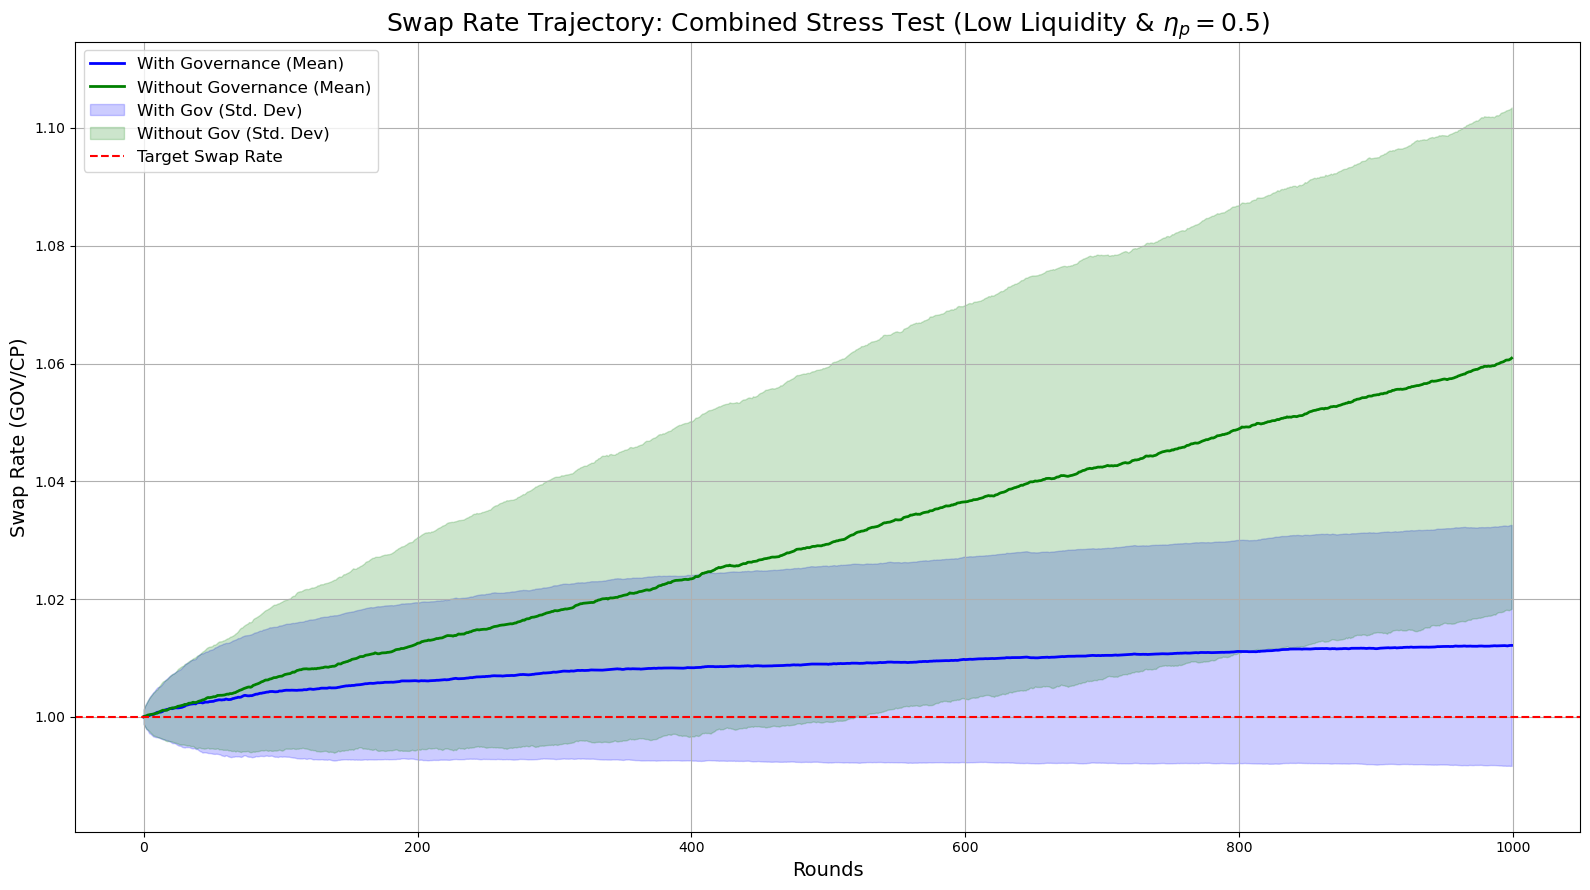

In [154]:
'''
ETA_P = 0.05 -> 0.5로 수정한 버전 (매우 빠르게 DAO 정책 반응)
유동성 = 1000000.0 -> 500000.0로 감소
'''


import random
import matplotlib.pyplot as plt
import math
import numpy as np # 통계 계산을 위해 numpy 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 500000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.5
INFLATION_FACTOR_CAP = 2.0
BETA = 5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 ---

def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        # k는 여기서 딱 한 번만 계산되고, 스왑 중에는 변하지 않음
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        # k를 매번 재계산하지 않고, 고정된 self.k를 사용
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool


class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - ETA_P * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        
        calculated_alpha = self.p_i * capped_I
        self.alpha = max(calculated_alpha, MIN_ALPHA)

class Simulation:
    def __init__(self, use_governance=True):
        self.amm = AMM(INITIAL_CP_LIQUIDITY, INITIAL_GOV_LIQUIDITY)
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)

# --- 4. Plotting 함수 수정 (신뢰 구간 플롯) ---
def plot_confidence_interval(exp_results, ctrl_results):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    rounds = range(SIMULATION_ROUNDS)

    # 데이터 통계치 계산 함수
    def get_stats(results_list):
        # 결과를 numpy 배열로 변환 (라운드 x 실행횟수)
        data = np.array(results_list).T
        mean = np.mean(data, axis=1)
        std = np.std(data, axis=1)
        return mean, std

    # 실험군(exp)과 비교군(ctrl)의 통계치 계산
    exp_mean, exp_std = get_stats(exp_results)
    ctrl_mean, ctrl_std = get_stats(ctrl_results)

    # 1. 평균 궤적 그리기
    ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
    ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2)

    # 2. 신뢰 구간(평균 ± 1*표준편차) 음영으로 그리기
    ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
    ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')

    # 3. 목표선 그리기
    ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')

    # 그래프 스타일 설정
    ax.set_title('Swap Rate Trajectory: Combined Stress Test (Low Liquidity & $\eta_p = 0.5$)', fontsize=18)
    ax.set_xlabel('Rounds', fontsize=14)
    ax.set_ylabel('Swap Rate (GOV/CP)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    # Y축 범위 동적 설정 (더 안정적으로)
    all_means = np.concatenate([exp_mean, ctrl_mean])
    all_stds = np.concatenate([exp_std, ctrl_std])
    min_val = np.min(all_means - all_stds)
    max_val = np.max(all_means + all_stds)
    padding = (max_val - min_val) * 0.1
    ax.set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout()
    plt.show()

# --- 5. 메인 실행부 수정 (반복 실행) ---
if __name__ == '__main__':
    # 각 시나리오별 결과를 저장할 리스트
    exp_all_results = []
    ctrl_all_results = []

    print(f"--- Starting {SIMULATION_RUNS} simulation runs for each scenario ---")
    
    for run in range(SIMULATION_RUNS):
        # 실험군 실행 (거버넌스 ON)
        exp_simulation = Simulation(use_governance=True)
        for i in range(SIMULATION_ROUNDS):
            exp_simulation.run_round(i)
        exp_all_results.append(exp_simulation.history['swap_rate'][1:]) # 결과 저장

        # 비교군 실행 (거버넌스 OFF)
        ctrl_simulation = Simulation(use_governance=False)
        for i in range(SIMULATION_ROUNDS):
            ctrl_simulation.run_round(i)
        ctrl_all_results.append(ctrl_simulation.history['swap_rate'][1:]) # 결과 저장
        
        if (run + 1) % 5 == 0:
             print(f"Completed {run + 1}/{SIMULATION_RUNS} runs...")

    print("\nAll simulations finished. Plotting results with confidence intervals...")
    plot_confidence_interval(exp_all_results, ctrl_all_results)

<>:186: SyntaxWarning: invalid escape sequence '\e'
<>:187: SyntaxWarning: invalid escape sequence '\e'
<>:189: SyntaxWarning: invalid escape sequence '\e'
<>:186: SyntaxWarning: invalid escape sequence '\e'
<>:187: SyntaxWarning: invalid escape sequence '\e'
<>:189: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_276822/750970817.py:186: SyntaxWarning: invalid escape sequence '\e'
  'baseline': "Swap Rate Trajectory: Baseline Scenario ($\eta_p = 0.05$, Full Liquidity)",
/tmp/ipykernel_276822/750970817.py:187: SyntaxWarning: invalid escape sequence '\e'
  'high_sensitivity': "Swap Rate Trajectory: High Policy Sensitivity ($\eta_p = 0.5$)",
/tmp/ipykernel_276822/750970817.py:189: SyntaxWarning: invalid escape sequence '\e'
  'combined_stress': "Swap Rate Trajectory: Combined Stress Test (Low Liquidity & $\eta_p = 0.5$)"
/tmp/ipykernel_276822/750970817.py:208: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyl

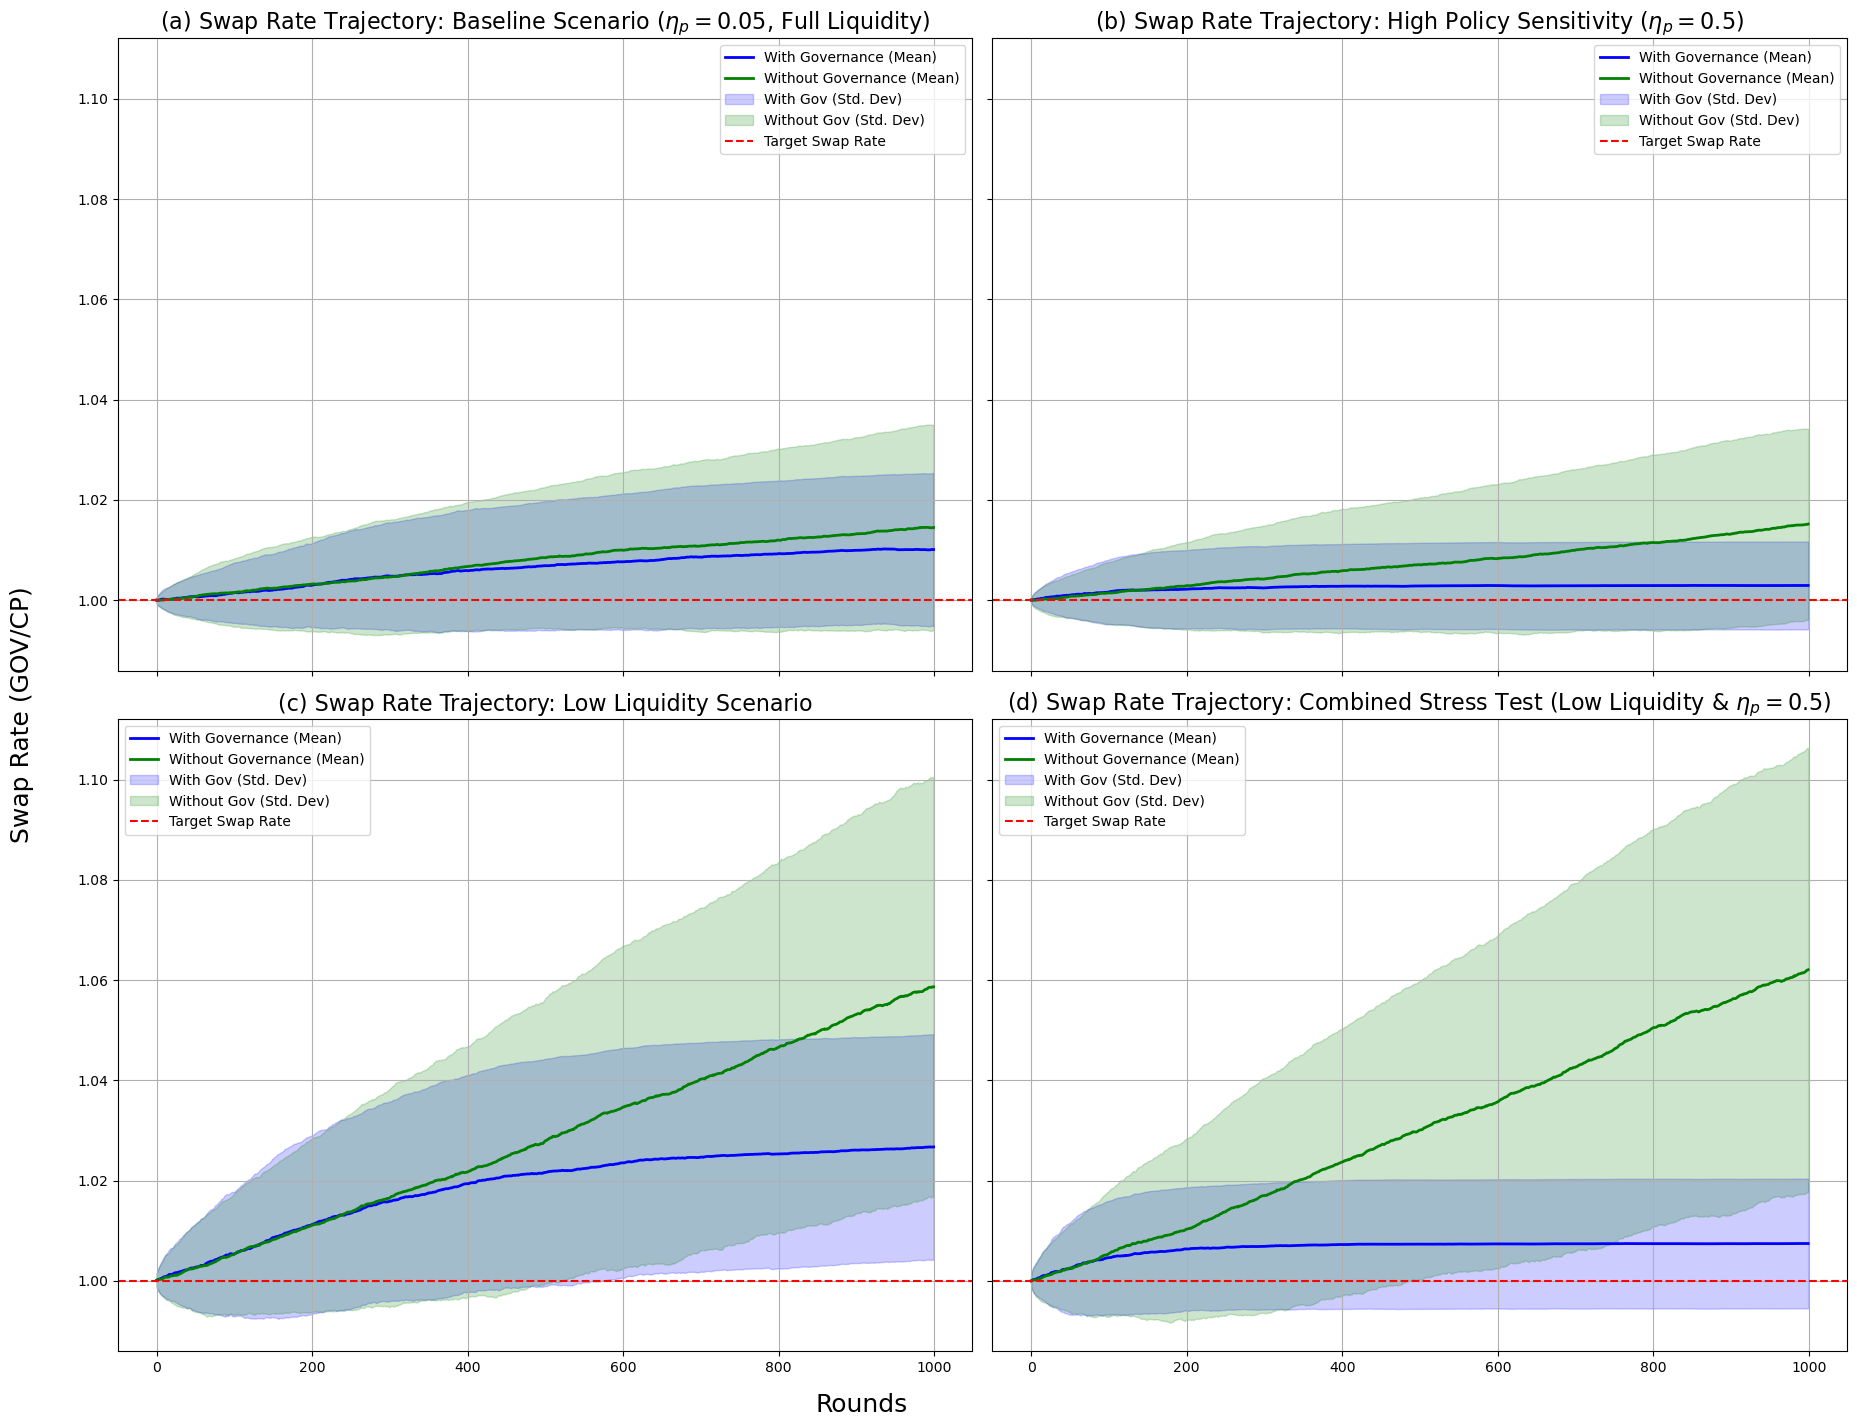

In [157]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import os # 파일 경로 관리를 위해 os 모듈 추가

# --- 1. 시뮬레이션 환경 설정 ---
SIMULATION_RUNS = 500
SIMULATION_ROUNDS = 1000
SAMPLE_SIZE = 200
INITIAL_CP_LIQUIDITY = 1000000.0
TARGET_SWAP_RATE = 1.0
INITIAL_GOV_LIQUIDITY = INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE
BASE_NFT_VALUE = 100.0
RARITY_RATE = 1.5

MIN_ALPHA = 0.1 # alpha가 이 값 밑으로 떨어지지 않도록 보장
ETA_P = 0.05
INFLATION_FACTOR_CAP = 2.0
BETA = 0.5
GAMMA = 0.5

# --- 2. 헬퍼 함수 및 핵심 클래스 정의 (수정 없음) ---
# ... (이전의 sigmoid, AMM, Governance 클래스 코드를 여기에 그대로 붙여넣으세요) ...
def sigmoid(x):
    try:
        if x >= 0:
            return 1 / (1 + math.exp(-x))
        else:
            return math.exp(x) / (1 + math.exp(x))
    except OverflowError:
        return 0.0 if x < 0 else 1.0

class AMM:
    def __init__(self, cp_pool, gov_pool):
        self.cp_pool = float(cp_pool)
        self.gov_pool = float(gov_pool)
        self.k = self.cp_pool * self.gov_pool
        
    def get_swap_rate(self):
        if self.cp_pool <= 0: return float('inf')
        return self.gov_pool / self.cp_pool

    def swap_cp_to_gov(self, cp_in):
        if cp_in <= 0: return 0
        new_cp_pool = self.cp_pool + cp_in
        if new_cp_pool <= 0: return 0
        new_gov_pool = self.k / new_cp_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

    def swap_gov_to_cp(self, gov_in):
        if gov_in <= 0: return 0
        new_gov_pool = self.gov_pool + gov_in
        if new_gov_pool <= 0: return 0
        new_cp_pool = self.k / new_gov_pool
        self.cp_pool = new_cp_pool
        self.gov_pool = new_gov_pool

class Governance:
    def __init__(self, initial_p=0.5, target_swap_rate=TARGET_SWAP_RATE, eta_p=0.1):
        self.p_i = initial_p
        self.target_swap_rate = target_swap_rate
        self.alpha = 1.0 * self.p_i
        self.eta_p = eta_p # ETA_P를 인스턴스 변수로 관리

    def update_policy(self, current_swap_rate):
        error = current_swap_rate - self.target_swap_rate
        updated_p_i = self.p_i - self.eta_p * error
        self.p_i = max(0.01, min(0.99, updated_p_i))
        inflation_factor_I = current_swap_rate / self.target_swap_rate
        capped_I = min(inflation_factor_I, INFLATION_FACTOR_CAP)
        self.alpha = self.p_i * capped_I

# --- 3. Simulation 클래스 수정 (초기값 인자 받도록) ---
class Simulation:
    def __init__(self, use_governance=True, 
                 initial_cp=DEFAULT_CP_LIQUIDITY, 
                 initial_gov=None,
                 eta_p=0.1):
        if initial_gov is None:
            initial_gov = initial_cp * TARGET_SWAP_RATE
            
        self.amm = AMM(initial_cp, initial_gov)
        # Governance 클래스에 ETA_P 전달
        self.governance = Governance(target_swap_rate=TARGET_SWAP_RATE, eta_p=eta_p)
        self.use_governance = use_governance
        self.history = {'swap_rate': [self.amm.get_swap_rate()]}

    def run_round(self, round_num):
        # ... (이전의 최종 run_round 로직을 여기에 그대로 붙여넣으세요) ...
        last_swap_rate = self.history['swap_rate'][-1]
        
        num_group_a = random.randint(int(SAMPLE_SIZE * 0.2), int(SAMPLE_SIZE * 0.8))
        num_group_b = SAMPLE_SIZE - num_group_a

        failures_a = 0
        for _ in range(num_group_a):
            value_on_success = BASE_NFT_VALUE * RARITY_RATE
            reward_on_fail = self.governance.alpha * BASE_NFT_VALUE
            utility_if_try = (self.governance.p_i * value_on_success) + \
                             ((1 - self.governance.p_i) * reward_on_fail)
            utility_if_idle = -GAMMA * (1 - self.governance.p_i)
            utility_diff = utility_if_try - utility_if_idle
            attempt_probability = sigmoid(utility_diff * BETA)
            
            if random.random() < attempt_probability:
                if random.random() > self.governance.p_i:
                    failures_a += 1
        
        cp_to_sell_by_a = failures_a * self.governance.alpha * BASE_NFT_VALUE
        
        noise_factor = random.uniform(0.8, 1.2)
        cp_to_buy_by_b = cp_to_sell_by_a * noise_factor
        
        gov_needed_for_matching_swap = cp_to_buy_by_b * self.amm.get_swap_rate()
        
        self.amm.swap_cp_to_gov(cp_to_sell_by_a)
        self.amm.swap_gov_to_cp(gov_needed_for_matching_swap)
        
        current_swap_rate = self.amm.get_swap_rate()
        
        if self.use_governance:
            self.governance.update_policy(current_swap_rate)
        
        self.history['swap_rate'].append(current_swap_rate)


# --- 4. 메인 실행 및 데이터 저장 함수 ---
def run_and_save_simulations():
    # 결과를 저장할 디렉토리 생성
    if not os.path.exists('simulation_data'):
        os.makedirs('simulation_data')

    parameter_sets = {
        'baseline': {'eta_p': 0.05, 'liquidity': DEFAULT_CP_LIQUIDITY},
        'high_sensitivity': {'eta_p': 0.5, 'liquidity': DEFAULT_CP_LIQUIDITY},
        'low_liquidity': {'eta_p': 0.05, 'liquidity': DEFAULT_CP_LIQUIDITY / 2},
        'combined_stress': {'eta_p': 0.5, 'liquidity': DEFAULT_CP_LIQUIDITY / 2}
    }

    for name, params in parameter_sets.items():
        exp_all_results = []
        ctrl_all_results = []
        
        _ETA_P = params['eta_p']
        _INITIAL_CP_LIQUIDITY = params['liquidity']
        _INITIAL_GOV_LIQUIDITY = _INITIAL_CP_LIQUIDITY * TARGET_SWAP_RATE

        print(f"\n--- Running Scenario: {name} ---")
        for run in range(SIMULATION_RUNS):
            # 실험군
            exp_sim = Simulation(use_governance=True, initial_cp=_INITIAL_CP_LIQUIDITY, initial_gov=_INITIAL_GOV_LIQUIDITY, eta_p=_ETA_P)
            for i in range(SIMULATION_ROUNDS):
                exp_sim.run_round(i)
            exp_all_results.append(exp_sim.history['swap_rate'][1:])
            
            # 비교군
            ctrl_sim = Simulation(use_governance=False, initial_cp=_INITIAL_CP_LIQUIDITY, initial_gov=_INITIAL_GOV_LIQUIDITY, eta_p=_ETA_P)
            for i in range(SIMULATION_ROUNDS):
                ctrl_sim.run_round(i)
            ctrl_all_results.append(ctrl_sim.history['swap_rate'][1:])

            if (run + 1) % 10 == 0:
                print(f"  Completed {run + 1}/{SIMULATION_RUNS} runs for {name}...")
        
        # 결과를 numpy 파일로 저장
        filepath = os.path.join('simulation_data', f'{name}_results.npz')
        np.savez(filepath, exp=np.array(exp_all_results), ctrl=np.array(ctrl_all_results))
        print(f"  Results for {name} saved to {filepath}")

# --- 5. 데이터 로드 및 시각화 함수 ---
def load_and_plot_final_figure():
    # 2x2 그리드의 서브플롯 생성
    fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=True, sharey=True)
    axs = axs.flatten() # 2x2 배열을 1차원 배열로 만들어 다루기 쉽게 함
    
    rounds = range(SIMULATION_ROUNDS)

    def get_stats(data_array):
        mean = np.mean(data_array, axis=0)
        std = np.std(data_array, axis=0)
        return mean, std

    scenario_names = {
        'baseline': "Swap Rate Trajectory: Baseline Scenario ($\eta_p = 0.05$, Full Liquidity)",
        'high_sensitivity': "Swap Rate Trajectory: High Policy Sensitivity ($\eta_p = 0.5$)",
        'low_liquidity': "Swap Rate Trajectory: Low Liquidity Scenario",
        'combined_stress': "Swap Rate Trajectory: Combined Stress Test (Low Liquidity & $\eta_p = 0.5$)"
    }
    
    for i, (name, title) in enumerate(scenario_names.items()):
        ax = axs[i]
        filepath = os.path.join('simulation_data', f'{name}_results.npz')
        
        try:
            data = np.load(filepath)
            exp_results = data['exp']
            ctrl_results = data['ctrl']
        except FileNotFoundError:
            print(f"Error: {filepath} not found. Please run the simulations first.")
            return

        exp_mean, exp_std = get_stats(exp_results)
        ctrl_mean, ctrl_std = get_stats(ctrl_results)

        ax.plot(rounds, exp_mean, 'b-', label='With Governance (Mean)', linewidth=2)
        ax.plot(rounds, ctrl_mean, 'g-', label='Without Governance (Mean)', linewidth=2, linestyle='-')
        ax.fill_between(rounds, exp_mean - exp_std, exp_mean + exp_std, color='blue', alpha=0.2, label='With Gov (Std. Dev)')
        ax.fill_between(rounds, ctrl_mean - ctrl_std, ctrl_mean + ctrl_std, color='green', alpha=0.2, label='Without Gov (Std. Dev)')
        ax.axhline(y=TARGET_SWAP_RATE, color='r', linestyle='--', label='Target Swap Rate')
        
        ax.set_title(f"({chr(97+i)}) {title}", fontsize=16)
        ax.grid(True)
        ax.legend()
    
    fig.text(0.5, 0.04, 'Rounds', ha='center', va='center', fontsize=18)
    fig.text(0.08, 0.5, 'Swap Rate (GOV/CP)', ha='center', va='center', rotation='vertical', fontsize=18)
    
    plt.tight_layout(rect=[0.1, 0.05, 1, 0.98])
    plt.savefig("simulation_results_final.png", dpi=300)
    plt.show()


# --- 메인 실행부 ---
if __name__ == '__main__':
    # 1단계: 시뮬레이션 실행 및 데이터 파일 저장
    # (시간이 오래 걸리므로, 한 번 실행 후에는 주석 처리 가능)
    #run_and_save_simulations()

    # 2단계: 저장된 데이터 파일을 불러와 최종 Figure 생성
    load_and_plot_final_figure()